In [1]:
import gc
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import time

import category_encoders as ce
import lightgbm as lgb
from sklearn import metrics

import sys
sys.path.append("../utils")
from metrics import compute_recall_at4, compute_normalized_gini, compute_amex_metric
#from messaging import send_message

pd.set_option('display.max_columns', None)

In [2]:
# metrics in lgbm format

def metric_recall_at4(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'recall_at4', compute_recall_at4(y_true, y_pred), True

def metric_normalized_gini(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'norm_gini', compute_normalized_gini(y_true, y_pred), True

def metric_amex(y_pred: np.ndarray, data: lgb.Dataset):
    y_true = data.get_label()
    return 'amex_metric', compute_amex_metric(y_true, y_pred), True

In [3]:
# CONFIG PARAMS
N_REPEATS = 5
DATASET_VERSION = "08"

In [4]:
OOF_PATH = Path(f"../data/oof/lgbm-dart-bce-dsv{DATASET_VERSION}")
SUB_PATH = Path(f"../data/subs/lgbm-dart-bce-dsv{DATASET_VERSION}")
ART_PATH = Path(f"../artifacts/lgbm-dart-bce-dsv{DATASET_VERSION}")

if not OOF_PATH.exists():
    OOF_PATH.mkdir(parents=True, exist_ok=True)
if not SUB_PATH.exists():
    SUB_PATH.mkdir(parents=True, exist_ok=True)
if not ART_PATH.exists():
    ART_PATH.mkdir(parents=True, exist_ok=True)

***
## load and prepare data

In [5]:
train = pd.read_parquet(f"../data/processed/dsv{DATASET_VERSION}/train.parquet")
train_labels = pd.read_csv("../data/raw/train_labels.csv", index_col="customer_ID")

In [6]:
input_feats = train.columns.tolist()
len(input_feats)

1149

In [7]:
train = pd.merge(train, train_labels, how="inner", left_index=True, right_index=True)
del train_labels
gc.collect()

102

***
## model training

train with repeated cross validation

In [8]:
model_params = {
    'boosting': 'dart',
    'objective': 'binary',
    'metric': 'None',
    'num_iterations': 4350,
    'num_leaves': 15,
    'learning_rate': 0.05,
    'max_bin': 63,
    'bin_construct_sample_cnt': 100000000,
    'bagging_freq': 1,
    'bagging_fraction': 1.0,
    'feature_fraction': 0.15,
    'lambda_l1': 5.996099571922015,
    'lambda_l2': 2.8900783163910697,
    'min_data_in_leaf': 1000,
    'path_smooth': 1.476306537276899,
    'min_gain_to_split': 0.313937968985787,
    'seed': 2112,
    'force_col_wise': True,
    'feature_pre_filter': True,
    'verbosity': -1,
    # dropout params
    'drop_rate': 0.1,
    'max_drop': 40,
    'skip_drop': 0.7,
}

In [9]:
def train_models(dataframe: pd.DataFrame, n_folds: int = 5,) -> tuple:
    
    models = list()
    
    # dataframe to store the oof predictions
    oof = dataframe[["target"]].copy()
    oof["pred"] = -1

    for fold in range(n_folds):
        
        seed = repetition*5 + fold
        _model_params = dict(model_params)
        _model_params["seed"] = seed
        
        print(f" training model {fold+1}/{n_folds} ".center(100, "#"))
        print("seed:", seed)
        
        train_df = dataframe.query("fold != @fold").copy()
        valid_df = dataframe.query("fold == @fold").copy()
                
        train_dset = lgb.Dataset(
            data=train_df.loc[:,input_feats],
            label=train_df.loc[:,"target"].values,
            free_raw_data=True,
        )
        valid_dset = lgb.Dataset(
            data=valid_df.loc[:,input_feats],
            label=valid_df.loc[:,"target"].values,
            free_raw_data=True,
        )
                
        model = lgb.train(
            params=_model_params,
            train_set=train_dset,
            valid_sets=[valid_dset,],
            feval=[metric_amex, metric_recall_at4, metric_normalized_gini],
            callbacks=[lgb.log_evaluation(period=50),],
        )
        
        lgb.plot_importance(model, figsize=(8,15), importance_type="split", max_num_features=30)
        lgb.plot_importance(model, figsize=(8,15), importance_type="gain", max_num_features=30)
        plt.show()        
        
        oof.loc[valid_df.index,"pred"] = model.predict(valid_df.loc[:,input_feats])
        
        models.append(model)
        del train_df,valid_df,train_dset,valid_dset
        gc.collect()
    
    return models,oof

In [10]:
# implement repeated cross validation
sorted(glob("../data/processed/cv*.csv"))

['../data/processed/cv0.csv',
 '../data/processed/cv1.csv',
 '../data/processed/cv2.csv',
 '../data/processed/cv3.csv',
 '../data/processed/cv4.csv',
 '../data/processed/cv5.csv',
 '../data/processed/cv6.csv',
 '../data/processed/cv7.csv',
 '../data/processed/cv8.csv',
 '../data/processed/cv9.csv']

############################### repeated cross-validation step: 1/5 ################################


######################################## training model 1/5 ########################################
seed: 0


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[50]	valid_0's amex_metric: 0.756376	valid_0's recall_at4: 0.610662	valid_0's norm_gini: 0.902089


[100]	valid_0's amex_metric: 0.767146	valid_0's recall_at4: 0.625768	valid_0's norm_gini: 0.908524


[150]	valid_0's amex_metric: 0.774681	valid_0's recall_at4: 0.636329	valid_0's norm_gini: 0.913032


[200]	valid_0's amex_metric: 0.779466	valid_0's recall_at4: 0.643188	valid_0's norm_gini: 0.915744


[250]	valid_0's amex_metric: 0.782324	valid_0's recall_at4: 0.647227	valid_0's norm_gini: 0.91742


[300]	valid_0's amex_metric: 0.784537	valid_0's recall_at4: 0.650425	valid_0's norm_gini: 0.918649


[350]	valid_0's amex_metric: 0.786356	valid_0's recall_at4: 0.653202	valid_0's norm_gini: 0.919511


[400]	valid_0's amex_metric: 0.787898	valid_0's recall_at4: 0.655516	valid_0's norm_gini: 0.920279


[450]	valid_0's amex_metric: 0.789296	valid_0's recall_at4: 0.657578	valid_0's norm_gini: 0.921013


[500]	valid_0's amex_metric: 0.790311	valid_0's recall_at4: 0.659093	valid_0's norm_gini: 0.921529


[550]	valid_0's amex_metric: 0.791039	valid_0's recall_at4: 0.660103	valid_0's norm_gini: 0.921976


[600]	valid_0's amex_metric: 0.791489	valid_0's recall_at4: 0.660523	valid_0's norm_gini: 0.922454


[650]	valid_0's amex_metric: 0.792832	valid_0's recall_at4: 0.662796	valid_0's norm_gini: 0.922868


[700]	valid_0's amex_metric: 0.793546	valid_0's recall_at4: 0.66389	valid_0's norm_gini: 0.923203


[750]	valid_0's amex_metric: 0.793972	valid_0's recall_at4: 0.664437	valid_0's norm_gini: 0.923507


[800]	valid_0's amex_metric: 0.794208	valid_0's recall_at4: 0.664731	valid_0's norm_gini: 0.923685


[850]	valid_0's amex_metric: 0.795054	valid_0's recall_at4: 0.666204	valid_0's norm_gini: 0.923903


[900]	valid_0's amex_metric: 0.795369	valid_0's recall_at4: 0.666667	valid_0's norm_gini: 0.924071


[950]	valid_0's amex_metric: 0.795155	valid_0's recall_at4: 0.66612	valid_0's norm_gini: 0.92419


[1000]	valid_0's amex_metric: 0.795724	valid_0's recall_at4: 0.66713	valid_0's norm_gini: 0.924319


[1050]	valid_0's amex_metric: 0.79605	valid_0's recall_at4: 0.667677	valid_0's norm_gini: 0.924424


[1100]	valid_0's amex_metric: 0.796213	valid_0's recall_at4: 0.667929	valid_0's norm_gini: 0.924497


[1150]	valid_0's amex_metric: 0.796502	valid_0's recall_at4: 0.668392	valid_0's norm_gini: 0.924613


[1200]	valid_0's amex_metric: 0.796899	valid_0's recall_at4: 0.669107	valid_0's norm_gini: 0.924691


[1250]	valid_0's amex_metric: 0.797329	valid_0's recall_at4: 0.669865	valid_0's norm_gini: 0.924793


[1300]	valid_0's amex_metric: 0.796897	valid_0's recall_at4: 0.668981	valid_0's norm_gini: 0.924812


[1350]	valid_0's amex_metric: 0.796845	valid_0's recall_at4: 0.668813	valid_0's norm_gini: 0.924878


[1400]	valid_0's amex_metric: 0.796985	valid_0's recall_at4: 0.669023	valid_0's norm_gini: 0.924947


[1450]	valid_0's amex_metric: 0.797098	valid_0's recall_at4: 0.669191	valid_0's norm_gini: 0.925004


[1500]	valid_0's amex_metric: 0.797894	valid_0's recall_at4: 0.670706	valid_0's norm_gini: 0.925082


[1550]	valid_0's amex_metric: 0.79748	valid_0's recall_at4: 0.669822	valid_0's norm_gini: 0.925137


[1600]	valid_0's amex_metric: 0.797307	valid_0's recall_at4: 0.669444	valid_0's norm_gini: 0.925171


[1650]	valid_0's amex_metric: 0.797606	valid_0's recall_at4: 0.669991	valid_0's norm_gini: 0.925221


[1700]	valid_0's amex_metric: 0.797674	valid_0's recall_at4: 0.670075	valid_0's norm_gini: 0.925272


[1750]	valid_0's amex_metric: 0.798236	valid_0's recall_at4: 0.671169	valid_0's norm_gini: 0.925303


[1800]	valid_0's amex_metric: 0.797779	valid_0's recall_at4: 0.670243	valid_0's norm_gini: 0.925315


[1850]	valid_0's amex_metric: 0.798112	valid_0's recall_at4: 0.670874	valid_0's norm_gini: 0.92535


[1900]	valid_0's amex_metric: 0.798158	valid_0's recall_at4: 0.670916	valid_0's norm_gini: 0.925399


[1950]	valid_0's amex_metric: 0.797789	valid_0's recall_at4: 0.670159	valid_0's norm_gini: 0.925419


[2000]	valid_0's amex_metric: 0.797882	valid_0's recall_at4: 0.670327	valid_0's norm_gini: 0.925437


[2050]	valid_0's amex_metric: 0.797967	valid_0's recall_at4: 0.670496	valid_0's norm_gini: 0.925438


[2100]	valid_0's amex_metric: 0.797679	valid_0's recall_at4: 0.669907	valid_0's norm_gini: 0.925452


[2150]	valid_0's amex_metric: 0.797921	valid_0's recall_at4: 0.670369	valid_0's norm_gini: 0.925473


[2200]	valid_0's amex_metric: 0.797437	valid_0's recall_at4: 0.66936	valid_0's norm_gini: 0.925515


[2250]	valid_0's amex_metric: 0.797891	valid_0's recall_at4: 0.670243	valid_0's norm_gini: 0.92554


[2300]	valid_0's amex_metric: 0.797964	valid_0's recall_at4: 0.670369	valid_0's norm_gini: 0.925558


[2350]	valid_0's amex_metric: 0.798711	valid_0's recall_at4: 0.671842	valid_0's norm_gini: 0.92558


[2400]	valid_0's amex_metric: 0.798323	valid_0's recall_at4: 0.671043	valid_0's norm_gini: 0.925604


[2450]	valid_0's amex_metric: 0.798611	valid_0's recall_at4: 0.67159	valid_0's norm_gini: 0.925632


[2500]	valid_0's amex_metric: 0.798029	valid_0's recall_at4: 0.670412	valid_0's norm_gini: 0.925646


[2550]	valid_0's amex_metric: 0.798118	valid_0's recall_at4: 0.67058	valid_0's norm_gini: 0.925657


[2600]	valid_0's amex_metric: 0.797947	valid_0's recall_at4: 0.670243	valid_0's norm_gini: 0.925651


[2650]	valid_0's amex_metric: 0.798032	valid_0's recall_at4: 0.670412	valid_0's norm_gini: 0.925652


[2700]	valid_0's amex_metric: 0.798442	valid_0's recall_at4: 0.671211	valid_0's norm_gini: 0.925673


[2750]	valid_0's amex_metric: 0.798701	valid_0's recall_at4: 0.671716	valid_0's norm_gini: 0.925686


[2800]	valid_0's amex_metric: 0.798607	valid_0's recall_at4: 0.671506	valid_0's norm_gini: 0.925708


[2850]	valid_0's amex_metric: 0.79878	valid_0's recall_at4: 0.671842	valid_0's norm_gini: 0.925717


[2900]	valid_0's amex_metric: 0.798298	valid_0's recall_at4: 0.670874	valid_0's norm_gini: 0.925721


[2950]	valid_0's amex_metric: 0.7985	valid_0's recall_at4: 0.671253	valid_0's norm_gini: 0.925747


[3000]	valid_0's amex_metric: 0.79846	valid_0's recall_at4: 0.671169	valid_0's norm_gini: 0.925752


[3050]	valid_0's amex_metric: 0.798343	valid_0's recall_at4: 0.670916	valid_0's norm_gini: 0.92577


[3100]	valid_0's amex_metric: 0.798035	valid_0's recall_at4: 0.670285	valid_0's norm_gini: 0.925785


[3150]	valid_0's amex_metric: 0.79776	valid_0's recall_at4: 0.669738	valid_0's norm_gini: 0.925782


[3200]	valid_0's amex_metric: 0.79799	valid_0's recall_at4: 0.670201	valid_0's norm_gini: 0.92578


[3250]	valid_0's amex_metric: 0.798475	valid_0's recall_at4: 0.671169	valid_0's norm_gini: 0.925781


[3300]	valid_0's amex_metric: 0.798603	valid_0's recall_at4: 0.671421	valid_0's norm_gini: 0.925784


[3350]	valid_0's amex_metric: 0.798317	valid_0's recall_at4: 0.670832	valid_0's norm_gini: 0.925801


[3400]	valid_0's amex_metric: 0.798282	valid_0's recall_at4: 0.67079	valid_0's norm_gini: 0.925774


[3450]	valid_0's amex_metric: 0.798556	valid_0's recall_at4: 0.671337	valid_0's norm_gini: 0.925774


[3500]	valid_0's amex_metric: 0.798566	valid_0's recall_at4: 0.671337	valid_0's norm_gini: 0.925795


[3550]	valid_0's amex_metric: 0.798734	valid_0's recall_at4: 0.671674	valid_0's norm_gini: 0.925793


[3600]	valid_0's amex_metric: 0.798379	valid_0's recall_at4: 0.670959	valid_0's norm_gini: 0.925799


[3650]	valid_0's amex_metric: 0.798567	valid_0's recall_at4: 0.671337	valid_0's norm_gini: 0.925796


[3700]	valid_0's amex_metric: 0.798587	valid_0's recall_at4: 0.671379	valid_0's norm_gini: 0.925795


[3750]	valid_0's amex_metric: 0.798532	valid_0's recall_at4: 0.671295	valid_0's norm_gini: 0.925769


[3800]	valid_0's amex_metric: 0.798351	valid_0's recall_at4: 0.670916	valid_0's norm_gini: 0.925785


[3850]	valid_0's amex_metric: 0.798359	valid_0's recall_at4: 0.670916	valid_0's norm_gini: 0.925801


[3900]	valid_0's amex_metric: 0.798344	valid_0's recall_at4: 0.670874	valid_0's norm_gini: 0.925815


[3950]	valid_0's amex_metric: 0.797964	valid_0's recall_at4: 0.670117	valid_0's norm_gini: 0.92581


[4000]	valid_0's amex_metric: 0.798214	valid_0's recall_at4: 0.670622	valid_0's norm_gini: 0.925806


[4050]	valid_0's amex_metric: 0.798506	valid_0's recall_at4: 0.671211	valid_0's norm_gini: 0.925801


[4100]	valid_0's amex_metric: 0.798211	valid_0's recall_at4: 0.670622	valid_0's norm_gini: 0.9258


[4150]	valid_0's amex_metric: 0.798374	valid_0's recall_at4: 0.670959	valid_0's norm_gini: 0.925789


[4200]	valid_0's amex_metric: 0.798071	valid_0's recall_at4: 0.670369	valid_0's norm_gini: 0.925773


[4250]	valid_0's amex_metric: 0.797844	valid_0's recall_at4: 0.669907	valid_0's norm_gini: 0.925782


[4300]	valid_0's amex_metric: 0.797668	valid_0's recall_at4: 0.66957	valid_0's norm_gini: 0.925766


[4350]	valid_0's amex_metric: 0.798044	valid_0's recall_at4: 0.670327	valid_0's norm_gini: 0.92576


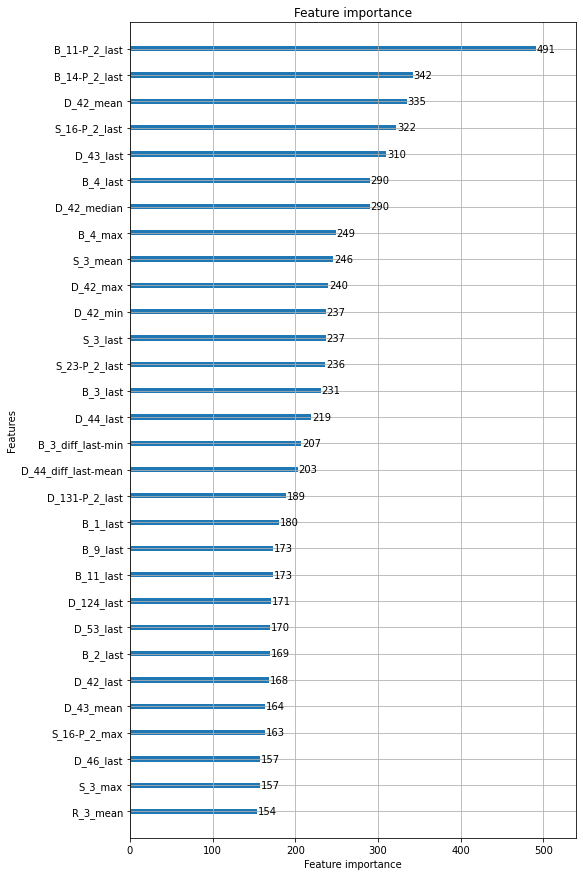

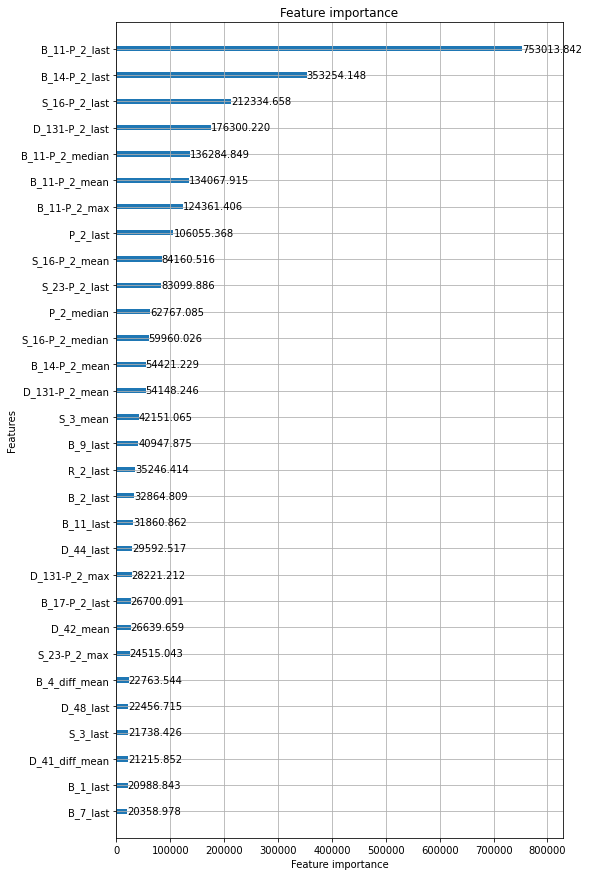

######################################## training model 2/5 ########################################
seed: 1


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[50]	valid_0's amex_metric: 0.74769	valid_0's recall_at4: 0.59644	valid_0's norm_gini: 0.898939


[100]	valid_0's amex_metric: 0.762922	valid_0's recall_at4: 0.619625	valid_0's norm_gini: 0.906219


[150]	valid_0's amex_metric: 0.771589	valid_0's recall_at4: 0.631827	valid_0's norm_gini: 0.911351


[200]	valid_0's amex_metric: 0.775762	valid_0's recall_at4: 0.637339	valid_0's norm_gini: 0.914184


[250]	valid_0's amex_metric: 0.779476	valid_0's recall_at4: 0.643188	valid_0's norm_gini: 0.915764


[300]	valid_0's amex_metric: 0.781619	valid_0's recall_at4: 0.646133	valid_0's norm_gini: 0.917104


[350]	valid_0's amex_metric: 0.784088	valid_0's recall_at4: 0.650004	valid_0's norm_gini: 0.918172


[400]	valid_0's amex_metric: 0.786138	valid_0's recall_at4: 0.653455	valid_0's norm_gini: 0.918822


[450]	valid_0's amex_metric: 0.787511	valid_0's recall_at4: 0.65539	valid_0's norm_gini: 0.919631


[500]	valid_0's amex_metric: 0.78949	valid_0's recall_at4: 0.65863	valid_0's norm_gini: 0.920351


[550]	valid_0's amex_metric: 0.78993	valid_0's recall_at4: 0.659009	valid_0's norm_gini: 0.920852


[600]	valid_0's amex_metric: 0.790456	valid_0's recall_at4: 0.659556	valid_0's norm_gini: 0.921357


[650]	valid_0's amex_metric: 0.790942	valid_0's recall_at4: 0.660103	valid_0's norm_gini: 0.921782


[700]	valid_0's amex_metric: 0.791009	valid_0's recall_at4: 0.659934	valid_0's norm_gini: 0.922084


[750]	valid_0's amex_metric: 0.791339	valid_0's recall_at4: 0.660355	valid_0's norm_gini: 0.922324


[800]	valid_0's amex_metric: 0.791737	valid_0's recall_at4: 0.660818	valid_0's norm_gini: 0.922657


[850]	valid_0's amex_metric: 0.792662	valid_0's recall_at4: 0.662459	valid_0's norm_gini: 0.922864


[900]	valid_0's amex_metric: 0.7931	valid_0's recall_at4: 0.663132	valid_0's norm_gini: 0.923067


[950]	valid_0's amex_metric: 0.793566	valid_0's recall_at4: 0.663974	valid_0's norm_gini: 0.923159


[1000]	valid_0's amex_metric: 0.793452	valid_0's recall_at4: 0.663553	valid_0's norm_gini: 0.923352


[1050]	valid_0's amex_metric: 0.794033	valid_0's recall_at4: 0.664605	valid_0's norm_gini: 0.923462


[1100]	valid_0's amex_metric: 0.793899	valid_0's recall_at4: 0.664184	valid_0's norm_gini: 0.923613


[1150]	valid_0's amex_metric: 0.794392	valid_0's recall_at4: 0.665026	valid_0's norm_gini: 0.923758


[1200]	valid_0's amex_metric: 0.794423	valid_0's recall_at4: 0.664984	valid_0's norm_gini: 0.923862


[1250]	valid_0's amex_metric: 0.794187	valid_0's recall_at4: 0.664394	valid_0's norm_gini: 0.923979


[1300]	valid_0's amex_metric: 0.794187	valid_0's recall_at4: 0.66431	valid_0's norm_gini: 0.924064


[1350]	valid_0's amex_metric: 0.793968	valid_0's recall_at4: 0.663763	valid_0's norm_gini: 0.924174


[1400]	valid_0's amex_metric: 0.793883	valid_0's recall_at4: 0.663511	valid_0's norm_gini: 0.924255


[1450]	valid_0's amex_metric: 0.794507	valid_0's recall_at4: 0.664689	valid_0's norm_gini: 0.924325


[1500]	valid_0's amex_metric: 0.794604	valid_0's recall_at4: 0.664815	valid_0's norm_gini: 0.924393


[1550]	valid_0's amex_metric: 0.795051	valid_0's recall_at4: 0.665615	valid_0's norm_gini: 0.924488


[1600]	valid_0's amex_metric: 0.795185	valid_0's recall_at4: 0.665825	valid_0's norm_gini: 0.924545


[1650]	valid_0's amex_metric: 0.795216	valid_0's recall_at4: 0.665825	valid_0's norm_gini: 0.924607


[1700]	valid_0's amex_metric: 0.795511	valid_0's recall_at4: 0.666372	valid_0's norm_gini: 0.92465


[1750]	valid_0's amex_metric: 0.795812	valid_0's recall_at4: 0.666919	valid_0's norm_gini: 0.924705


[1800]	valid_0's amex_metric: 0.796004	valid_0's recall_at4: 0.667256	valid_0's norm_gini: 0.924753


[1850]	valid_0's amex_metric: 0.796177	valid_0's recall_at4: 0.66755	valid_0's norm_gini: 0.924803


[1900]	valid_0's amex_metric: 0.796595	valid_0's recall_at4: 0.66835	valid_0's norm_gini: 0.92484


[1950]	valid_0's amex_metric: 0.797041	valid_0's recall_at4: 0.669191	valid_0's norm_gini: 0.924892


[2000]	valid_0's amex_metric: 0.797122	valid_0's recall_at4: 0.669317	valid_0's norm_gini: 0.924927


[2050]	valid_0's amex_metric: 0.797386	valid_0's recall_at4: 0.669822	valid_0's norm_gini: 0.924949


[2100]	valid_0's amex_metric: 0.797491	valid_0's recall_at4: 0.670033	valid_0's norm_gini: 0.924949


[2150]	valid_0's amex_metric: 0.797314	valid_0's recall_at4: 0.669654	valid_0's norm_gini: 0.924975


[2200]	valid_0's amex_metric: 0.797479	valid_0's recall_at4: 0.669949	valid_0's norm_gini: 0.925009


[2250]	valid_0's amex_metric: 0.797519	valid_0's recall_at4: 0.669991	valid_0's norm_gini: 0.925047


[2300]	valid_0's amex_metric: 0.797188	valid_0's recall_at4: 0.669317	valid_0's norm_gini: 0.925059


[2350]	valid_0's amex_metric: 0.797124	valid_0's recall_at4: 0.669149	valid_0's norm_gini: 0.9251


[2400]	valid_0's amex_metric: 0.797578	valid_0's recall_at4: 0.670033	valid_0's norm_gini: 0.925124


[2450]	valid_0's amex_metric: 0.797295	valid_0's recall_at4: 0.669444	valid_0's norm_gini: 0.925146


[2500]	valid_0's amex_metric: 0.798101	valid_0's recall_at4: 0.671001	valid_0's norm_gini: 0.925202


[2550]	valid_0's amex_metric: 0.797795	valid_0's recall_at4: 0.670369	valid_0's norm_gini: 0.92522


[2600]	valid_0's amex_metric: 0.797709	valid_0's recall_at4: 0.670201	valid_0's norm_gini: 0.925218


[2650]	valid_0's amex_metric: 0.798059	valid_0's recall_at4: 0.670874	valid_0's norm_gini: 0.925243


[2700]	valid_0's amex_metric: 0.797398	valid_0's recall_at4: 0.669528	valid_0's norm_gini: 0.925269


[2750]	valid_0's amex_metric: 0.797655	valid_0's recall_at4: 0.670033	valid_0's norm_gini: 0.925276


[2800]	valid_0's amex_metric: 0.7979	valid_0's recall_at4: 0.670496	valid_0's norm_gini: 0.925305


[2850]	valid_0's amex_metric: 0.797815	valid_0's recall_at4: 0.670327	valid_0's norm_gini: 0.925303


[2900]	valid_0's amex_metric: 0.797629	valid_0's recall_at4: 0.669949	valid_0's norm_gini: 0.92531


[2950]	valid_0's amex_metric: 0.797515	valid_0's recall_at4: 0.669696	valid_0's norm_gini: 0.925335


[3000]	valid_0's amex_metric: 0.797131	valid_0's recall_at4: 0.668897	valid_0's norm_gini: 0.925366


[3050]	valid_0's amex_metric: 0.797435	valid_0's recall_at4: 0.669486	valid_0's norm_gini: 0.925385


[3100]	valid_0's amex_metric: 0.797602	valid_0's recall_at4: 0.669822	valid_0's norm_gini: 0.925382


[3150]	valid_0's amex_metric: 0.797092	valid_0's recall_at4: 0.668813	valid_0's norm_gini: 0.925371


[3200]	valid_0's amex_metric: 0.797243	valid_0's recall_at4: 0.669107	valid_0's norm_gini: 0.925378


[3250]	valid_0's amex_metric: 0.797247	valid_0's recall_at4: 0.669107	valid_0's norm_gini: 0.925388


[3300]	valid_0's amex_metric: 0.797416	valid_0's recall_at4: 0.669444	valid_0's norm_gini: 0.925388


[3350]	valid_0's amex_metric: 0.797469	valid_0's recall_at4: 0.669528	valid_0's norm_gini: 0.925409


[3400]	valid_0's amex_metric: 0.797115	valid_0's recall_at4: 0.668813	valid_0's norm_gini: 0.925418


[3450]	valid_0's amex_metric: 0.796883	valid_0's recall_at4: 0.66835	valid_0's norm_gini: 0.925416


[3500]	valid_0's amex_metric: 0.797035	valid_0's recall_at4: 0.668644	valid_0's norm_gini: 0.925425


[3550]	valid_0's amex_metric: 0.797184	valid_0's recall_at4: 0.668939	valid_0's norm_gini: 0.92543


[3600]	valid_0's amex_metric: 0.797165	valid_0's recall_at4: 0.668897	valid_0's norm_gini: 0.925434


[3650]	valid_0's amex_metric: 0.797373	valid_0's recall_at4: 0.669317	valid_0's norm_gini: 0.925429


[3700]	valid_0's amex_metric: 0.797124	valid_0's recall_at4: 0.668813	valid_0's norm_gini: 0.925436


[3750]	valid_0's amex_metric: 0.79734	valid_0's recall_at4: 0.669233	valid_0's norm_gini: 0.925447


[3800]	valid_0's amex_metric: 0.797148	valid_0's recall_at4: 0.668855	valid_0's norm_gini: 0.925441


[3850]	valid_0's amex_metric: 0.79727	valid_0's recall_at4: 0.669107	valid_0's norm_gini: 0.925432


[3900]	valid_0's amex_metric: 0.797337	valid_0's recall_at4: 0.669233	valid_0's norm_gini: 0.92544


[3950]	valid_0's amex_metric: 0.796896	valid_0's recall_at4: 0.66835	valid_0's norm_gini: 0.925442


[4000]	valid_0's amex_metric: 0.797043	valid_0's recall_at4: 0.668644	valid_0's norm_gini: 0.925441


[4050]	valid_0's amex_metric: 0.797696	valid_0's recall_at4: 0.669949	valid_0's norm_gini: 0.925444


[4100]	valid_0's amex_metric: 0.797341	valid_0's recall_at4: 0.669233	valid_0's norm_gini: 0.925449


[4150]	valid_0's amex_metric: 0.797203	valid_0's recall_at4: 0.668981	valid_0's norm_gini: 0.925426


[4200]	valid_0's amex_metric: 0.797013	valid_0's recall_at4: 0.668602	valid_0's norm_gini: 0.925424


[4250]	valid_0's amex_metric: 0.797369	valid_0's recall_at4: 0.669317	valid_0's norm_gini: 0.925421


[4300]	valid_0's amex_metric: 0.797304	valid_0's recall_at4: 0.669191	valid_0's norm_gini: 0.925417


[4350]	valid_0's amex_metric: 0.797314	valid_0's recall_at4: 0.669191	valid_0's norm_gini: 0.925437


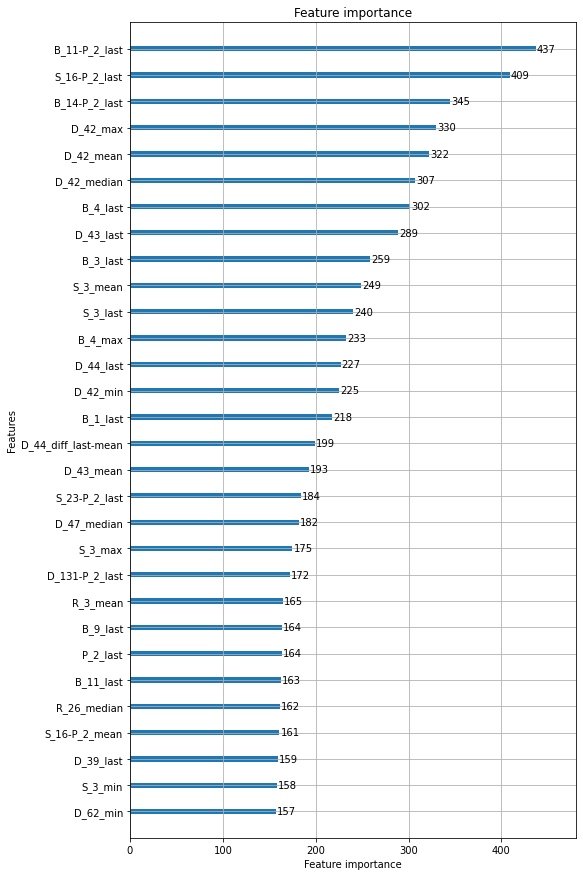

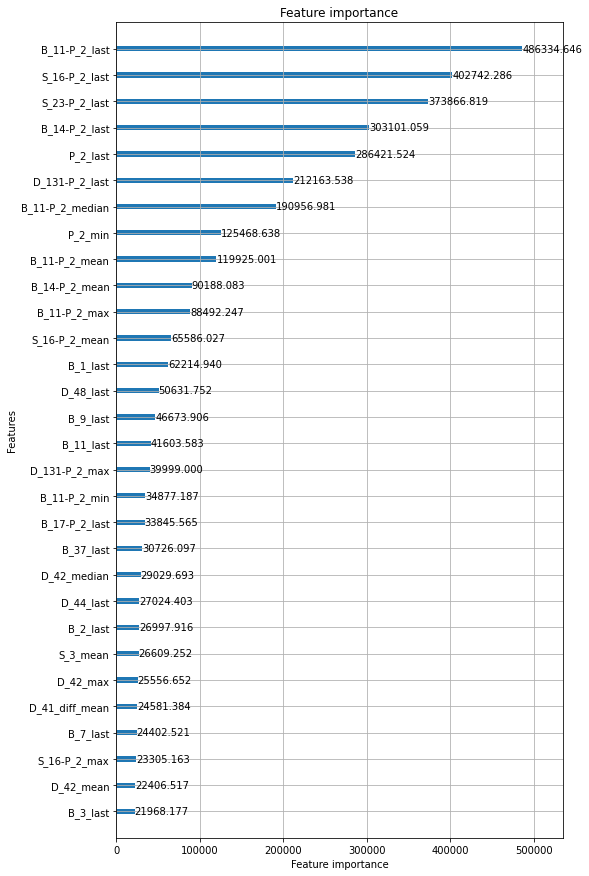

######################################## training model 3/5 ########################################
seed: 2


[50]	valid_0's amex_metric: 0.746457	valid_0's recall_at4: 0.593874	valid_0's norm_gini: 0.89904


[100]	valid_0's amex_metric: 0.758702	valid_0's recall_at4: 0.611336	valid_0's norm_gini: 0.906069


[150]	valid_0's amex_metric: 0.765396	valid_0's recall_at4: 0.620803	valid_0's norm_gini: 0.909989


[200]	valid_0's amex_metric: 0.768555	valid_0's recall_at4: 0.625305	valid_0's norm_gini: 0.911805


[250]	valid_0's amex_metric: 0.772206	valid_0's recall_at4: 0.630859	valid_0's norm_gini: 0.913552


[300]	valid_0's amex_metric: 0.774581	valid_0's recall_at4: 0.63372	valid_0's norm_gini: 0.915442


[350]	valid_0's amex_metric: 0.777213	valid_0's recall_at4: 0.637592	valid_0's norm_gini: 0.916834


[400]	valid_0's amex_metric: 0.778383	valid_0's recall_at4: 0.639317	valid_0's norm_gini: 0.91745


[450]	valid_0's amex_metric: 0.779922	valid_0's recall_at4: 0.641715	valid_0's norm_gini: 0.91813


[500]	valid_0's amex_metric: 0.781601	valid_0's recall_at4: 0.64424	valid_0's norm_gini: 0.918963


[550]	valid_0's amex_metric: 0.78343	valid_0's recall_at4: 0.647353	valid_0's norm_gini: 0.919506


[600]	valid_0's amex_metric: 0.784069	valid_0's recall_at4: 0.648321	valid_0's norm_gini: 0.919817


[650]	valid_0's amex_metric: 0.784928	valid_0's recall_at4: 0.649668	valid_0's norm_gini: 0.920189


[700]	valid_0's amex_metric: 0.785921	valid_0's recall_at4: 0.651351	valid_0's norm_gini: 0.920491


[750]	valid_0's amex_metric: 0.786586	valid_0's recall_at4: 0.65236	valid_0's norm_gini: 0.920811


[800]	valid_0's amex_metric: 0.787207	valid_0's recall_at4: 0.653328	valid_0's norm_gini: 0.921087


[850]	valid_0's amex_metric: 0.787077	valid_0's recall_at4: 0.652865	valid_0's norm_gini: 0.921289


[900]	valid_0's amex_metric: 0.787924	valid_0's recall_at4: 0.65438	valid_0's norm_gini: 0.921467


[950]	valid_0's amex_metric: 0.788385	valid_0's recall_at4: 0.655096	valid_0's norm_gini: 0.921675


[1000]	valid_0's amex_metric: 0.788135	valid_0's recall_at4: 0.654464	valid_0's norm_gini: 0.921806


[1050]	valid_0's amex_metric: 0.788123	valid_0's recall_at4: 0.654254	valid_0's norm_gini: 0.921993


[1100]	valid_0's amex_metric: 0.788737	valid_0's recall_at4: 0.65539	valid_0's norm_gini: 0.922085


[1150]	valid_0's amex_metric: 0.789364	valid_0's recall_at4: 0.656568	valid_0's norm_gini: 0.92216


[1200]	valid_0's amex_metric: 0.789388	valid_0's recall_at4: 0.656526	valid_0's norm_gini: 0.922249


[1250]	valid_0's amex_metric: 0.789458	valid_0's recall_at4: 0.656568	valid_0's norm_gini: 0.922348


[1300]	valid_0's amex_metric: 0.789003	valid_0's recall_at4: 0.655558	valid_0's norm_gini: 0.922447


[1350]	valid_0's amex_metric: 0.789257	valid_0's recall_at4: 0.655979	valid_0's norm_gini: 0.922535


[1400]	valid_0's amex_metric: 0.789589	valid_0's recall_at4: 0.656568	valid_0's norm_gini: 0.922611


[1450]	valid_0's amex_metric: 0.790045	valid_0's recall_at4: 0.65741	valid_0's norm_gini: 0.92268


[1500]	valid_0's amex_metric: 0.789811	valid_0's recall_at4: 0.656863	valid_0's norm_gini: 0.922759


[1550]	valid_0's amex_metric: 0.790788	valid_0's recall_at4: 0.658756	valid_0's norm_gini: 0.92282


[1600]	valid_0's amex_metric: 0.790972	valid_0's recall_at4: 0.659093	valid_0's norm_gini: 0.922852


[1650]	valid_0's amex_metric: 0.791511	valid_0's recall_at4: 0.660103	valid_0's norm_gini: 0.92292


[1700]	valid_0's amex_metric: 0.791401	valid_0's recall_at4: 0.659808	valid_0's norm_gini: 0.922994


[1750]	valid_0's amex_metric: 0.791496	valid_0's recall_at4: 0.659934	valid_0's norm_gini: 0.923057


[1800]	valid_0's amex_metric: 0.79136	valid_0's recall_at4: 0.65964	valid_0's norm_gini: 0.923081


[1850]	valid_0's amex_metric: 0.791444	valid_0's recall_at4: 0.659766	valid_0's norm_gini: 0.923122


[1900]	valid_0's amex_metric: 0.791433	valid_0's recall_at4: 0.659682	valid_0's norm_gini: 0.923185


[1950]	valid_0's amex_metric: 0.791306	valid_0's recall_at4: 0.659387	valid_0's norm_gini: 0.923224


[2000]	valid_0's amex_metric: 0.791068	valid_0's recall_at4: 0.658882	valid_0's norm_gini: 0.923254


[2050]	valid_0's amex_metric: 0.791202	valid_0's recall_at4: 0.659093	valid_0's norm_gini: 0.923312


[2100]	valid_0's amex_metric: 0.791619	valid_0's recall_at4: 0.659892	valid_0's norm_gini: 0.923346


[2150]	valid_0's amex_metric: 0.791608	valid_0's recall_at4: 0.65985	valid_0's norm_gini: 0.923365


[2200]	valid_0's amex_metric: 0.791621	valid_0's recall_at4: 0.65985	valid_0's norm_gini: 0.923393


[2250]	valid_0's amex_metric: 0.79128	valid_0's recall_at4: 0.659135	valid_0's norm_gini: 0.923426


[2300]	valid_0's amex_metric: 0.791467	valid_0's recall_at4: 0.659514	valid_0's norm_gini: 0.923421


[2350]	valid_0's amex_metric: 0.791616	valid_0's recall_at4: 0.659808	valid_0's norm_gini: 0.923425


[2400]	valid_0's amex_metric: 0.79142	valid_0's recall_at4: 0.659387	valid_0's norm_gini: 0.923453


[2450]	valid_0's amex_metric: 0.791788	valid_0's recall_at4: 0.660103	valid_0's norm_gini: 0.923474


[2500]	valid_0's amex_metric: 0.791324	valid_0's recall_at4: 0.659135	valid_0's norm_gini: 0.923512


[2550]	valid_0's amex_metric: 0.791902	valid_0's recall_at4: 0.660271	valid_0's norm_gini: 0.923534


[2600]	valid_0's amex_metric: 0.792298	valid_0's recall_at4: 0.661028	valid_0's norm_gini: 0.923568


[2650]	valid_0's amex_metric: 0.792452	valid_0's recall_at4: 0.661323	valid_0's norm_gini: 0.923582


[2700]	valid_0's amex_metric: 0.792087	valid_0's recall_at4: 0.660565	valid_0's norm_gini: 0.923608


[2750]	valid_0's amex_metric: 0.792307	valid_0's recall_at4: 0.660986	valid_0's norm_gini: 0.923628


[2800]	valid_0's amex_metric: 0.792248	valid_0's recall_at4: 0.66086	valid_0's norm_gini: 0.923636


[2850]	valid_0's amex_metric: 0.791846	valid_0's recall_at4: 0.660061	valid_0's norm_gini: 0.923631


[2900]	valid_0's amex_metric: 0.792068	valid_0's recall_at4: 0.660523	valid_0's norm_gini: 0.923612


[2950]	valid_0's amex_metric: 0.792085	valid_0's recall_at4: 0.660523	valid_0's norm_gini: 0.923646


[3000]	valid_0's amex_metric: 0.792212	valid_0's recall_at4: 0.660776	valid_0's norm_gini: 0.923649


[3050]	valid_0's amex_metric: 0.79184	valid_0's recall_at4: 0.660019	valid_0's norm_gini: 0.923661


[3100]	valid_0's amex_metric: 0.792137	valid_0's recall_at4: 0.660608	valid_0's norm_gini: 0.923666


[3150]	valid_0's amex_metric: 0.792092	valid_0's recall_at4: 0.660523	valid_0's norm_gini: 0.923661


[3200]	valid_0's amex_metric: 0.791804	valid_0's recall_at4: 0.659934	valid_0's norm_gini: 0.923673


[3250]	valid_0's amex_metric: 0.792164	valid_0's recall_at4: 0.66065	valid_0's norm_gini: 0.923679


[3300]	valid_0's amex_metric: 0.792123	valid_0's recall_at4: 0.660565	valid_0's norm_gini: 0.92368


[3350]	valid_0's amex_metric: 0.792094	valid_0's recall_at4: 0.660481	valid_0's norm_gini: 0.923707


[3400]	valid_0's amex_metric: 0.791887	valid_0's recall_at4: 0.660061	valid_0's norm_gini: 0.923713


[3450]	valid_0's amex_metric: 0.792035	valid_0's recall_at4: 0.660355	valid_0's norm_gini: 0.923716


[3500]	valid_0's amex_metric: 0.792241	valid_0's recall_at4: 0.660776	valid_0's norm_gini: 0.923706


[3550]	valid_0's amex_metric: 0.792492	valid_0's recall_at4: 0.661281	valid_0's norm_gini: 0.923702


[3600]	valid_0's amex_metric: 0.792657	valid_0's recall_at4: 0.661617	valid_0's norm_gini: 0.923697


[3650]	valid_0's amex_metric: 0.792622	valid_0's recall_at4: 0.661533	valid_0's norm_gini: 0.923711


[3700]	valid_0's amex_metric: 0.792652	valid_0's recall_at4: 0.661617	valid_0's norm_gini: 0.923686


[3750]	valid_0's amex_metric: 0.792253	valid_0's recall_at4: 0.660818	valid_0's norm_gini: 0.923688


[3800]	valid_0's amex_metric: 0.792331	valid_0's recall_at4: 0.660986	valid_0's norm_gini: 0.923675


[3850]	valid_0's amex_metric: 0.792613	valid_0's recall_at4: 0.661533	valid_0's norm_gini: 0.923693


[3900]	valid_0's amex_metric: 0.792594	valid_0's recall_at4: 0.661491	valid_0's norm_gini: 0.923696


[3950]	valid_0's amex_metric: 0.792636	valid_0's recall_at4: 0.661575	valid_0's norm_gini: 0.923697


[4000]	valid_0's amex_metric: 0.792166	valid_0's recall_at4: 0.66065	valid_0's norm_gini: 0.923683


[4050]	valid_0's amex_metric: 0.792209	valid_0's recall_at4: 0.660734	valid_0's norm_gini: 0.923685


[4100]	valid_0's amex_metric: 0.791824	valid_0's recall_at4: 0.659976	valid_0's norm_gini: 0.923672


[4150]	valid_0's amex_metric: 0.791796	valid_0's recall_at4: 0.659934	valid_0's norm_gini: 0.923658


[4200]	valid_0's amex_metric: 0.791837	valid_0's recall_at4: 0.660019	valid_0's norm_gini: 0.923656


[4250]	valid_0's amex_metric: 0.792027	valid_0's recall_at4: 0.660397	valid_0's norm_gini: 0.923656


[4300]	valid_0's amex_metric: 0.792322	valid_0's recall_at4: 0.660986	valid_0's norm_gini: 0.923659


[4350]	valid_0's amex_metric: 0.792155	valid_0's recall_at4: 0.66065	valid_0's norm_gini: 0.923661


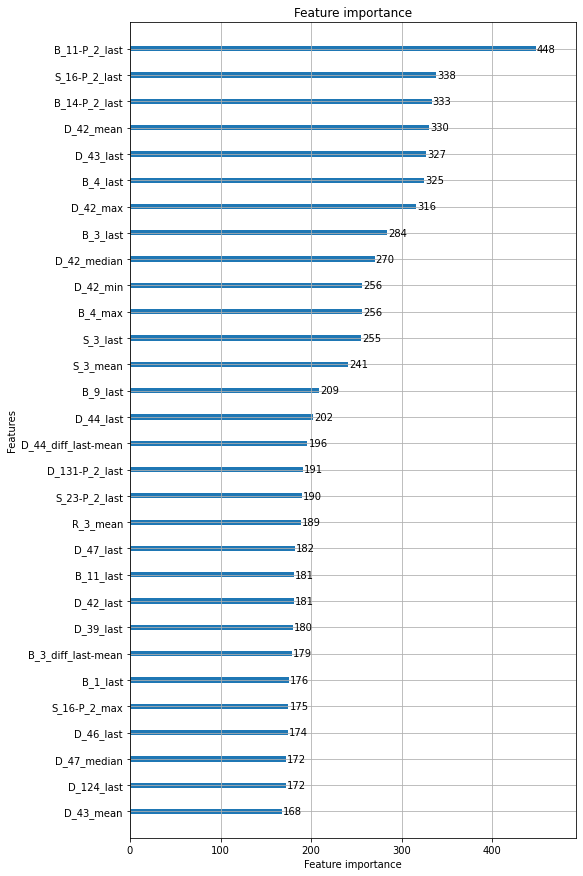

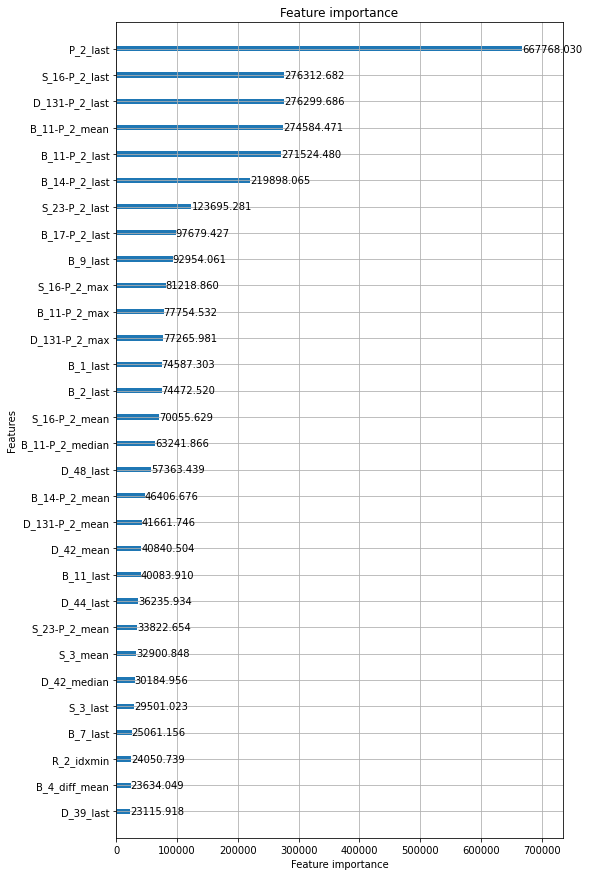

######################################## training model 4/5 ########################################
seed: 3


[50]	valid_0's amex_metric: 0.746772	valid_0's recall_at4: 0.595456	valid_0's norm_gini: 0.898088


[100]	valid_0's amex_metric: 0.757296	valid_0's recall_at4: 0.610141	valid_0's norm_gini: 0.904452


[150]	valid_0's amex_metric: 0.767668	valid_0's recall_at4: 0.625205	valid_0's norm_gini: 0.910131


[200]	valid_0's amex_metric: 0.772123	valid_0's recall_at4: 0.631054	valid_0's norm_gini: 0.913193


[250]	valid_0's amex_metric: 0.774803	valid_0's recall_at4: 0.634631	valid_0's norm_gini: 0.914976


[300]	valid_0's amex_metric: 0.776803	valid_0's recall_at4: 0.637408	valid_0's norm_gini: 0.916198


[350]	valid_0's amex_metric: 0.77904	valid_0's recall_at4: 0.640606	valid_0's norm_gini: 0.917474


[400]	valid_0's amex_metric: 0.781287	valid_0's recall_at4: 0.644225	valid_0's norm_gini: 0.91835


[450]	valid_0's amex_metric: 0.78176	valid_0's recall_at4: 0.644646	valid_0's norm_gini: 0.918874


[500]	valid_0's amex_metric: 0.783534	valid_0's recall_at4: 0.647549	valid_0's norm_gini: 0.919519


[550]	valid_0's amex_metric: 0.784463	valid_0's recall_at4: 0.648895	valid_0's norm_gini: 0.92003


[600]	valid_0's amex_metric: 0.785752	valid_0's recall_at4: 0.651041	valid_0's norm_gini: 0.920462


[650]	valid_0's amex_metric: 0.786584	valid_0's recall_at4: 0.652388	valid_0's norm_gini: 0.92078


[700]	valid_0's amex_metric: 0.786724	valid_0's recall_at4: 0.652388	valid_0's norm_gini: 0.92106


[750]	valid_0's amex_metric: 0.787171	valid_0's recall_at4: 0.652977	valid_0's norm_gini: 0.921365


[800]	valid_0's amex_metric: 0.788064	valid_0's recall_at4: 0.654534	valid_0's norm_gini: 0.921594


[850]	valid_0's amex_metric: 0.788539	valid_0's recall_at4: 0.655123	valid_0's norm_gini: 0.921954


[900]	valid_0's amex_metric: 0.788752	valid_0's recall_at4: 0.655333	valid_0's norm_gini: 0.922171


[950]	valid_0's amex_metric: 0.789303	valid_0's recall_at4: 0.656259	valid_0's norm_gini: 0.922348


[1000]	valid_0's amex_metric: 0.789136	valid_0's recall_at4: 0.655754	valid_0's norm_gini: 0.922517


[1050]	valid_0's amex_metric: 0.789164	valid_0's recall_at4: 0.655628	valid_0's norm_gini: 0.9227


[1100]	valid_0's amex_metric: 0.789927	valid_0's recall_at4: 0.657059	valid_0's norm_gini: 0.922796


[1150]	valid_0's amex_metric: 0.789532	valid_0's recall_at4: 0.656175	valid_0's norm_gini: 0.92289


[1200]	valid_0's amex_metric: 0.789792	valid_0's recall_at4: 0.656596	valid_0's norm_gini: 0.922989


[1250]	valid_0's amex_metric: 0.789838	valid_0's recall_at4: 0.656596	valid_0's norm_gini: 0.923081


[1300]	valid_0's amex_metric: 0.789698	valid_0's recall_at4: 0.656217	valid_0's norm_gini: 0.923179


[1350]	valid_0's amex_metric: 0.790168	valid_0's recall_at4: 0.657059	valid_0's norm_gini: 0.923276


[1400]	valid_0's amex_metric: 0.790359	valid_0's recall_at4: 0.657353	valid_0's norm_gini: 0.923365


[1450]	valid_0's amex_metric: 0.790097	valid_0's recall_at4: 0.656764	valid_0's norm_gini: 0.92343


[1500]	valid_0's amex_metric: 0.790705	valid_0's recall_at4: 0.6579	valid_0's norm_gini: 0.92351


[1550]	valid_0's amex_metric: 0.790716	valid_0's recall_at4: 0.657858	valid_0's norm_gini: 0.923574


[1600]	valid_0's amex_metric: 0.791209	valid_0's recall_at4: 0.658742	valid_0's norm_gini: 0.923677


[1650]	valid_0's amex_metric: 0.791067	valid_0's recall_at4: 0.658405	valid_0's norm_gini: 0.923729


[1700]	valid_0's amex_metric: 0.791364	valid_0's recall_at4: 0.658952	valid_0's norm_gini: 0.923777


[1750]	valid_0's amex_metric: 0.791466	valid_0's recall_at4: 0.659121	valid_0's norm_gini: 0.923812


[1800]	valid_0's amex_metric: 0.791567	valid_0's recall_at4: 0.659289	valid_0's norm_gini: 0.923845


[1850]	valid_0's amex_metric: 0.791915	valid_0's recall_at4: 0.65992	valid_0's norm_gini: 0.923909


[1900]	valid_0's amex_metric: 0.792094	valid_0's recall_at4: 0.660257	valid_0's norm_gini: 0.923931


[1950]	valid_0's amex_metric: 0.791962	valid_0's recall_at4: 0.659962	valid_0's norm_gini: 0.923962


[2000]	valid_0's amex_metric: 0.792048	valid_0's recall_at4: 0.660088	valid_0's norm_gini: 0.924008


[2050]	valid_0's amex_metric: 0.792082	valid_0's recall_at4: 0.66013	valid_0's norm_gini: 0.924033


[2100]	valid_0's amex_metric: 0.7917	valid_0's recall_at4: 0.659331	valid_0's norm_gini: 0.924069


[2150]	valid_0's amex_metric: 0.791755	valid_0's recall_at4: 0.659415	valid_0's norm_gini: 0.924095


[2200]	valid_0's amex_metric: 0.792317	valid_0's recall_at4: 0.660509	valid_0's norm_gini: 0.924125


[2250]	valid_0's amex_metric: 0.792431	valid_0's recall_at4: 0.66072	valid_0's norm_gini: 0.924142


[2300]	valid_0's amex_metric: 0.792044	valid_0's recall_at4: 0.65992	valid_0's norm_gini: 0.924168


[2350]	valid_0's amex_metric: 0.792052	valid_0's recall_at4: 0.65992	valid_0's norm_gini: 0.924185


[2400]	valid_0's amex_metric: 0.792076	valid_0's recall_at4: 0.659962	valid_0's norm_gini: 0.92419


[2450]	valid_0's amex_metric: 0.791659	valid_0's recall_at4: 0.659121	valid_0's norm_gini: 0.924198


[2500]	valid_0's amex_metric: 0.79166	valid_0's recall_at4: 0.659121	valid_0's norm_gini: 0.9242


[2550]	valid_0's amex_metric: 0.791865	valid_0's recall_at4: 0.659499	valid_0's norm_gini: 0.92423


[2600]	valid_0's amex_metric: 0.792528	valid_0's recall_at4: 0.660804	valid_0's norm_gini: 0.924253


[2650]	valid_0's amex_metric: 0.792314	valid_0's recall_at4: 0.660341	valid_0's norm_gini: 0.924286


[2700]	valid_0's amex_metric: 0.792401	valid_0's recall_at4: 0.660509	valid_0's norm_gini: 0.924294


[2750]	valid_0's amex_metric: 0.792495	valid_0's recall_at4: 0.660677	valid_0's norm_gini: 0.924313


[2800]	valid_0's amex_metric: 0.792784	valid_0's recall_at4: 0.661224	valid_0's norm_gini: 0.924344


[2850]	valid_0's amex_metric: 0.792587	valid_0's recall_at4: 0.660804	valid_0's norm_gini: 0.92437


[2900]	valid_0's amex_metric: 0.792653	valid_0's recall_at4: 0.66093	valid_0's norm_gini: 0.924376


[2950]	valid_0's amex_metric: 0.792517	valid_0's recall_at4: 0.660677	valid_0's norm_gini: 0.924356


[3000]	valid_0's amex_metric: 0.793086	valid_0's recall_at4: 0.661772	valid_0's norm_gini: 0.9244


[3050]	valid_0's amex_metric: 0.793494	valid_0's recall_at4: 0.662571	valid_0's norm_gini: 0.924417


[3100]	valid_0's amex_metric: 0.793433	valid_0's recall_at4: 0.662445	valid_0's norm_gini: 0.924421


[3150]	valid_0's amex_metric: 0.793353	valid_0's recall_at4: 0.662276	valid_0's norm_gini: 0.924429


[3200]	valid_0's amex_metric: 0.793289	valid_0's recall_at4: 0.66215	valid_0's norm_gini: 0.924428


[3250]	valid_0's amex_metric: 0.793175	valid_0's recall_at4: 0.66194	valid_0's norm_gini: 0.92441


[3300]	valid_0's amex_metric: 0.793368	valid_0's recall_at4: 0.662319	valid_0's norm_gini: 0.924418


[3350]	valid_0's amex_metric: 0.793269	valid_0's recall_at4: 0.662108	valid_0's norm_gini: 0.92443


[3400]	valid_0's amex_metric: 0.793213	valid_0's recall_at4: 0.661982	valid_0's norm_gini: 0.924445


[3450]	valid_0's amex_metric: 0.793067	valid_0's recall_at4: 0.661687	valid_0's norm_gini: 0.924448


[3500]	valid_0's amex_metric: 0.792985	valid_0's recall_at4: 0.661519	valid_0's norm_gini: 0.92445


[3550]	valid_0's amex_metric: 0.792946	valid_0's recall_at4: 0.661435	valid_0's norm_gini: 0.924458


[3600]	valid_0's amex_metric: 0.792546	valid_0's recall_at4: 0.660635	valid_0's norm_gini: 0.924457


[3650]	valid_0's amex_metric: 0.792295	valid_0's recall_at4: 0.66013	valid_0's norm_gini: 0.92446


[3700]	valid_0's amex_metric: 0.792664	valid_0's recall_at4: 0.660846	valid_0's norm_gini: 0.924483


[3750]	valid_0's amex_metric: 0.792896	valid_0's recall_at4: 0.661309	valid_0's norm_gini: 0.924483


[3800]	valid_0's amex_metric: 0.792239	valid_0's recall_at4: 0.660004	valid_0's norm_gini: 0.924473


[3850]	valid_0's amex_metric: 0.792686	valid_0's recall_at4: 0.660888	valid_0's norm_gini: 0.924484


[3900]	valid_0's amex_metric: 0.792942	valid_0's recall_at4: 0.661393	valid_0's norm_gini: 0.924492


[3950]	valid_0's amex_metric: 0.793003	valid_0's recall_at4: 0.661519	valid_0's norm_gini: 0.924486


[4000]	valid_0's amex_metric: 0.79307	valid_0's recall_at4: 0.661645	valid_0's norm_gini: 0.924494


[4050]	valid_0's amex_metric: 0.792654	valid_0's recall_at4: 0.660804	valid_0's norm_gini: 0.924504


[4100]	valid_0's amex_metric: 0.792969	valid_0's recall_at4: 0.661435	valid_0's norm_gini: 0.924503


[4150]	valid_0's amex_metric: 0.792694	valid_0's recall_at4: 0.660888	valid_0's norm_gini: 0.924501


[4200]	valid_0's amex_metric: 0.792821	valid_0's recall_at4: 0.66114	valid_0's norm_gini: 0.924501


[4250]	valid_0's amex_metric: 0.792815	valid_0's recall_at4: 0.66114	valid_0's norm_gini: 0.92449


[4300]	valid_0's amex_metric: 0.793261	valid_0's recall_at4: 0.662024	valid_0's norm_gini: 0.924497


[4350]	valid_0's amex_metric: 0.793096	valid_0's recall_at4: 0.661687	valid_0's norm_gini: 0.924505


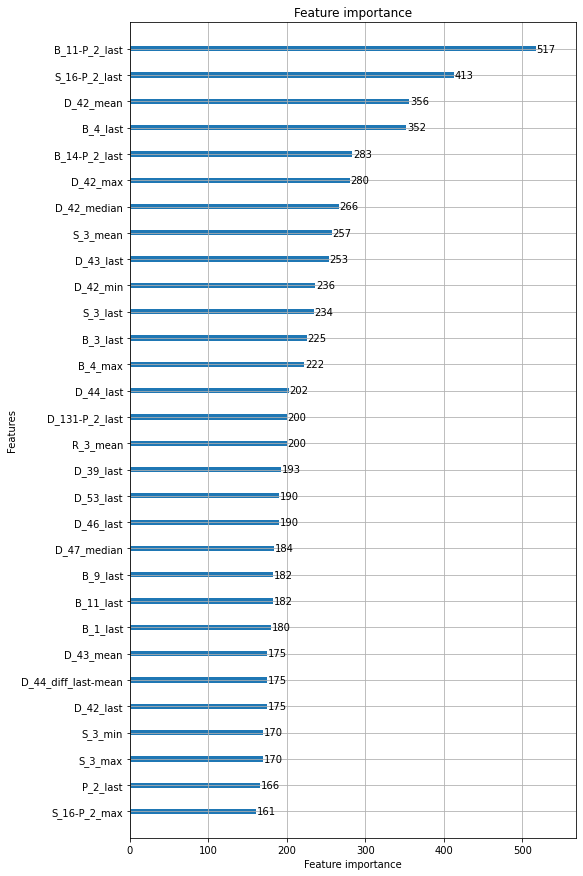

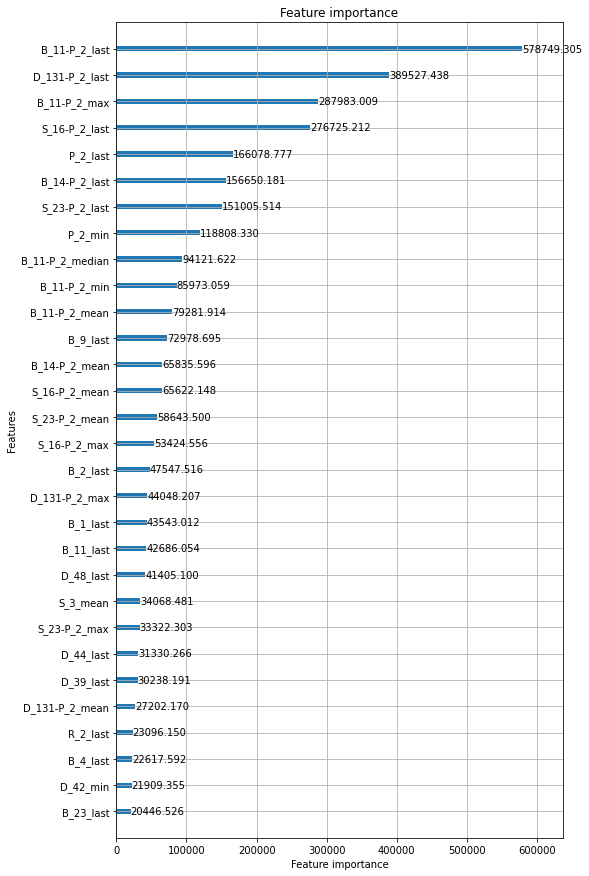

######################################## training model 5/5 ########################################
seed: 4


[50]	valid_0's amex_metric: 0.756312	valid_0's recall_at4: 0.611151	valid_0's norm_gini: 0.901472


[100]	valid_0's amex_metric: 0.766872	valid_0's recall_at4: 0.625836	valid_0's norm_gini: 0.907907


[150]	valid_0's amex_metric: 0.775364	valid_0's recall_at4: 0.637871	valid_0's norm_gini: 0.912856


[200]	valid_0's amex_metric: 0.779875	valid_0's recall_at4: 0.643383	valid_0's norm_gini: 0.916367


[250]	valid_0's amex_metric: 0.783412	valid_0's recall_at4: 0.648433	valid_0's norm_gini: 0.918392


[300]	valid_0's amex_metric: 0.786373	valid_0's recall_at4: 0.653103	valid_0's norm_gini: 0.919643


[350]	valid_0's amex_metric: 0.787937	valid_0's recall_at4: 0.655165	valid_0's norm_gini: 0.92071


[400]	valid_0's amex_metric: 0.791185	valid_0's recall_at4: 0.660509	valid_0's norm_gini: 0.921861


[450]	valid_0's amex_metric: 0.791837	valid_0's recall_at4: 0.661393	valid_0's norm_gini: 0.922281


[500]	valid_0's amex_metric: 0.793599	valid_0's recall_at4: 0.664465	valid_0's norm_gini: 0.922734


[550]	valid_0's amex_metric: 0.794667	valid_0's recall_at4: 0.666064	valid_0's norm_gini: 0.92327


[600]	valid_0's amex_metric: 0.795123	valid_0's recall_at4: 0.666526	valid_0's norm_gini: 0.92372


[650]	valid_0's amex_metric: 0.795666	valid_0's recall_at4: 0.667284	valid_0's norm_gini: 0.924048


[700]	valid_0's amex_metric: 0.796324	valid_0's recall_at4: 0.668378	valid_0's norm_gini: 0.92427


[750]	valid_0's amex_metric: 0.796476	valid_0's recall_at4: 0.668336	valid_0's norm_gini: 0.924617


[800]	valid_0's amex_metric: 0.797223	valid_0's recall_at4: 0.66964	valid_0's norm_gini: 0.924805


[850]	valid_0's amex_metric: 0.797557	valid_0's recall_at4: 0.670103	valid_0's norm_gini: 0.925012


[900]	valid_0's amex_metric: 0.797498	valid_0's recall_at4: 0.669809	valid_0's norm_gini: 0.925187


[950]	valid_0's amex_metric: 0.797533	valid_0's recall_at4: 0.669682	valid_0's norm_gini: 0.925385


[1000]	valid_0's amex_metric: 0.797785	valid_0's recall_at4: 0.670061	valid_0's norm_gini: 0.925509


[1050]	valid_0's amex_metric: 0.798345	valid_0's recall_at4: 0.670987	valid_0's norm_gini: 0.925703


[1100]	valid_0's amex_metric: 0.798444	valid_0's recall_at4: 0.671029	valid_0's norm_gini: 0.92586


[1150]	valid_0's amex_metric: 0.798916	valid_0's recall_at4: 0.671828	valid_0's norm_gini: 0.926003


[1200]	valid_0's amex_metric: 0.798888	valid_0's recall_at4: 0.67166	valid_0's norm_gini: 0.926116


[1250]	valid_0's amex_metric: 0.799221	valid_0's recall_at4: 0.672249	valid_0's norm_gini: 0.926194


[1300]	valid_0's amex_metric: 0.799425	valid_0's recall_at4: 0.672586	valid_0's norm_gini: 0.926264


[1350]	valid_0's amex_metric: 0.799559	valid_0's recall_at4: 0.672712	valid_0's norm_gini: 0.926406


[1400]	valid_0's amex_metric: 0.800212	valid_0's recall_at4: 0.673932	valid_0's norm_gini: 0.926492


[1450]	valid_0's amex_metric: 0.800756	valid_0's recall_at4: 0.674942	valid_0's norm_gini: 0.92657


[1500]	valid_0's amex_metric: 0.800618	valid_0's recall_at4: 0.674563	valid_0's norm_gini: 0.926674


[1550]	valid_0's amex_metric: 0.800554	valid_0's recall_at4: 0.674353	valid_0's norm_gini: 0.926754


[1600]	valid_0's amex_metric: 0.800877	valid_0's recall_at4: 0.674942	valid_0's norm_gini: 0.926812


[1650]	valid_0's amex_metric: 0.801057	valid_0's recall_at4: 0.675237	valid_0's norm_gini: 0.926878


[1700]	valid_0's amex_metric: 0.800975	valid_0's recall_at4: 0.675026	valid_0's norm_gini: 0.926924


[1750]	valid_0's amex_metric: 0.800999	valid_0's recall_at4: 0.675026	valid_0's norm_gini: 0.926971


[1800]	valid_0's amex_metric: 0.801531	valid_0's recall_at4: 0.676036	valid_0's norm_gini: 0.927027


[1850]	valid_0's amex_metric: 0.801518	valid_0's recall_at4: 0.675952	valid_0's norm_gini: 0.927083


[1900]	valid_0's amex_metric: 0.801318	valid_0's recall_at4: 0.675531	valid_0's norm_gini: 0.927104


[1950]	valid_0's amex_metric: 0.801506	valid_0's recall_at4: 0.675868	valid_0's norm_gini: 0.927143


[2000]	valid_0's amex_metric: 0.801855	valid_0's recall_at4: 0.676541	valid_0's norm_gini: 0.927169


[2050]	valid_0's amex_metric: 0.801464	valid_0's recall_at4: 0.6757	valid_0's norm_gini: 0.927228


[2100]	valid_0's amex_metric: 0.801514	valid_0's recall_at4: 0.675784	valid_0's norm_gini: 0.927244


[2150]	valid_0's amex_metric: 0.801868	valid_0's recall_at4: 0.676457	valid_0's norm_gini: 0.92728


[2200]	valid_0's amex_metric: 0.801999	valid_0's recall_at4: 0.676667	valid_0's norm_gini: 0.92733


[2250]	valid_0's amex_metric: 0.801984	valid_0's recall_at4: 0.676583	valid_0's norm_gini: 0.927385


[2300]	valid_0's amex_metric: 0.801631	valid_0's recall_at4: 0.675868	valid_0's norm_gini: 0.927393


[2350]	valid_0's amex_metric: 0.802676	valid_0's recall_at4: 0.67793	valid_0's norm_gini: 0.927422


[2400]	valid_0's amex_metric: 0.802401	valid_0's recall_at4: 0.677341	valid_0's norm_gini: 0.927461


[2450]	valid_0's amex_metric: 0.802182	valid_0's recall_at4: 0.676878	valid_0's norm_gini: 0.927487


[2500]	valid_0's amex_metric: 0.802283	valid_0's recall_at4: 0.677088	valid_0's norm_gini: 0.927478


[2550]	valid_0's amex_metric: 0.802184	valid_0's recall_at4: 0.676878	valid_0's norm_gini: 0.92749


[2600]	valid_0's amex_metric: 0.801921	valid_0's recall_at4: 0.676331	valid_0's norm_gini: 0.927511


[2650]	valid_0's amex_metric: 0.802641	valid_0's recall_at4: 0.677761	valid_0's norm_gini: 0.927521


[2700]	valid_0's amex_metric: 0.802041	valid_0's recall_at4: 0.676541	valid_0's norm_gini: 0.927541


[2750]	valid_0's amex_metric: 0.801815	valid_0's recall_at4: 0.676078	valid_0's norm_gini: 0.927552


[2800]	valid_0's amex_metric: 0.802247	valid_0's recall_at4: 0.67692	valid_0's norm_gini: 0.927573


[2850]	valid_0's amex_metric: 0.802467	valid_0's recall_at4: 0.677341	valid_0's norm_gini: 0.927594


[2900]	valid_0's amex_metric: 0.802635	valid_0's recall_at4: 0.677635	valid_0's norm_gini: 0.927635


[2950]	valid_0's amex_metric: 0.802537	valid_0's recall_at4: 0.677425	valid_0's norm_gini: 0.92765


[3000]	valid_0's amex_metric: 0.802441	valid_0's recall_at4: 0.677214	valid_0's norm_gini: 0.927668


[3050]	valid_0's amex_metric: 0.802562	valid_0's recall_at4: 0.677425	valid_0's norm_gini: 0.927699


[3100]	valid_0's amex_metric: 0.802822	valid_0's recall_at4: 0.67793	valid_0's norm_gini: 0.927713


[3150]	valid_0's amex_metric: 0.803086	valid_0's recall_at4: 0.678435	valid_0's norm_gini: 0.927738


[3200]	valid_0's amex_metric: 0.802918	valid_0's recall_at4: 0.678098	valid_0's norm_gini: 0.927738


[3250]	valid_0's amex_metric: 0.802688	valid_0's recall_at4: 0.677635	valid_0's norm_gini: 0.92774


[3300]	valid_0's amex_metric: 0.802817	valid_0's recall_at4: 0.677888	valid_0's norm_gini: 0.927746


[3350]	valid_0's amex_metric: 0.802986	valid_0's recall_at4: 0.678224	valid_0's norm_gini: 0.927748


[3400]	valid_0's amex_metric: 0.802687	valid_0's recall_at4: 0.677635	valid_0's norm_gini: 0.927739


[3450]	valid_0's amex_metric: 0.802673	valid_0's recall_at4: 0.677593	valid_0's norm_gini: 0.927752


[3500]	valid_0's amex_metric: 0.802455	valid_0's recall_at4: 0.677172	valid_0's norm_gini: 0.927738


[3550]	valid_0's amex_metric: 0.802093	valid_0's recall_at4: 0.676457	valid_0's norm_gini: 0.927728


[3600]	valid_0's amex_metric: 0.801991	valid_0's recall_at4: 0.676247	valid_0's norm_gini: 0.927736


[3650]	valid_0's amex_metric: 0.802421	valid_0's recall_at4: 0.677088	valid_0's norm_gini: 0.927753


[3700]	valid_0's amex_metric: 0.802218	valid_0's recall_at4: 0.676667	valid_0's norm_gini: 0.927769


[3750]	valid_0's amex_metric: 0.802534	valid_0's recall_at4: 0.677299	valid_0's norm_gini: 0.927769


[3800]	valid_0's amex_metric: 0.802702	valid_0's recall_at4: 0.677635	valid_0's norm_gini: 0.927768


[3850]	valid_0's amex_metric: 0.802673	valid_0's recall_at4: 0.677551	valid_0's norm_gini: 0.927796


[3900]	valid_0's amex_metric: 0.802374	valid_0's recall_at4: 0.676962	valid_0's norm_gini: 0.927786


[3950]	valid_0's amex_metric: 0.80229	valid_0's recall_at4: 0.676794	valid_0's norm_gini: 0.927786


[4000]	valid_0's amex_metric: 0.802372	valid_0's recall_at4: 0.676962	valid_0's norm_gini: 0.927782


[4050]	valid_0's amex_metric: 0.802702	valid_0's recall_at4: 0.677635	valid_0's norm_gini: 0.927769


[4100]	valid_0's amex_metric: 0.802697	valid_0's recall_at4: 0.677635	valid_0's norm_gini: 0.927759


[4150]	valid_0's amex_metric: 0.80267	valid_0's recall_at4: 0.677593	valid_0's norm_gini: 0.927747


[4200]	valid_0's amex_metric: 0.802477	valid_0's recall_at4: 0.677214	valid_0's norm_gini: 0.92774


[4250]	valid_0's amex_metric: 0.802269	valid_0's recall_at4: 0.676794	valid_0's norm_gini: 0.927744


[4300]	valid_0's amex_metric: 0.802553	valid_0's recall_at4: 0.677341	valid_0's norm_gini: 0.927765


[4350]	valid_0's amex_metric: 0.802712	valid_0's recall_at4: 0.677635	valid_0's norm_gini: 0.927789


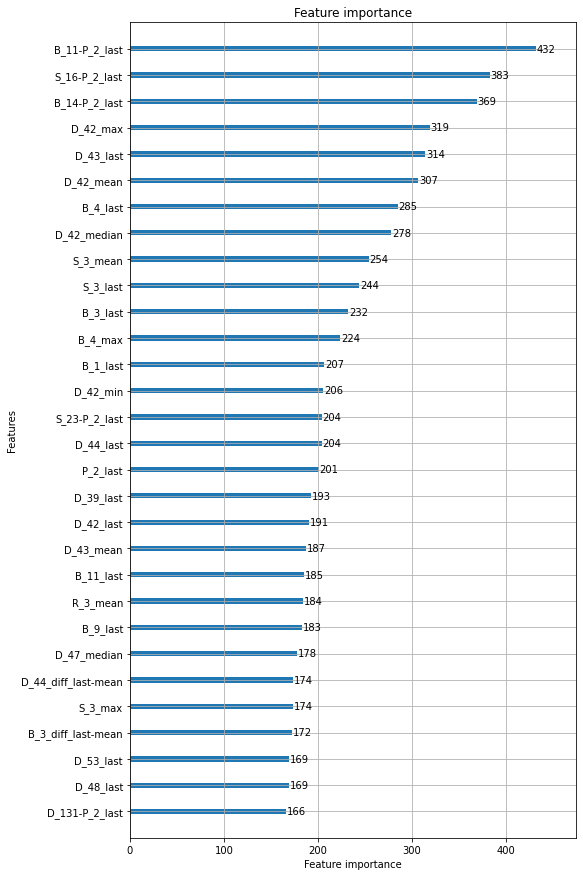

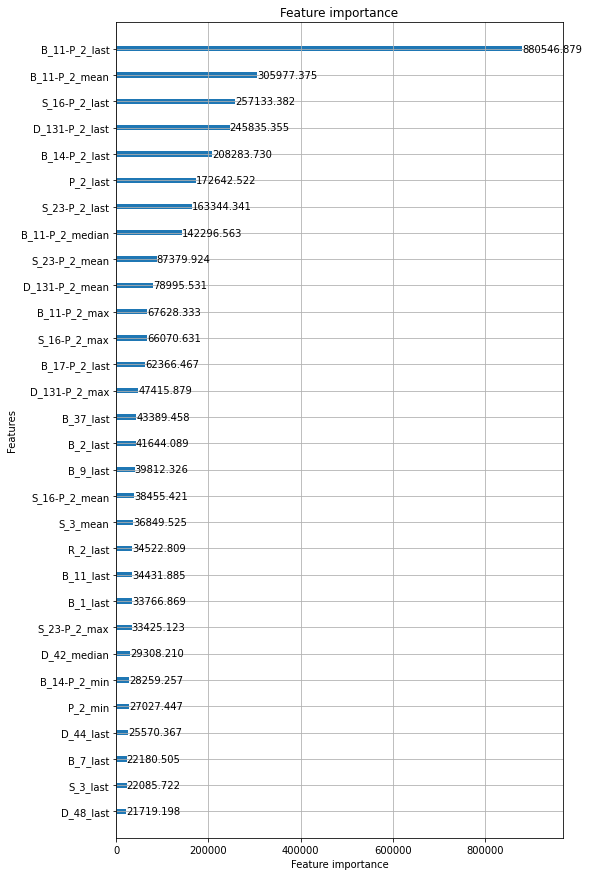

Training time: 35.073802443345386 min.


OOF recall_at4: 0.6676035951122631


OOF normalized_gini: 0.9253027261212096


OOF competition metric: 0.7964531606167363


############################### repeated cross-validation step: 2/5 ################################


######################################## training model 1/5 ########################################
seed: 5


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[50]	valid_0's amex_metric: 0.750635	valid_0's recall_at4: 0.601868	valid_0's norm_gini: 0.899402


[100]	valid_0's amex_metric: 0.762404	valid_0's recall_at4: 0.619372	valid_0's norm_gini: 0.905436


[150]	valid_0's amex_metric: 0.77069	valid_0's recall_at4: 0.63107	valid_0's norm_gini: 0.91031


[200]	valid_0's amex_metric: 0.775721	valid_0's recall_at4: 0.638391	valid_0's norm_gini: 0.913051


[250]	valid_0's amex_metric: 0.778025	valid_0's recall_at4: 0.64121	valid_0's norm_gini: 0.91484


[300]	valid_0's amex_metric: 0.781685	valid_0's recall_at4: 0.64647	valid_0's norm_gini: 0.916901


[350]	valid_0's amex_metric: 0.784335	valid_0's recall_at4: 0.650257	valid_0's norm_gini: 0.918414


[400]	valid_0's amex_metric: 0.786865	valid_0's recall_at4: 0.654086	valid_0's norm_gini: 0.919644


[450]	valid_0's amex_metric: 0.78886	valid_0's recall_at4: 0.657241	valid_0's norm_gini: 0.920479


[500]	valid_0's amex_metric: 0.78949	valid_0's recall_at4: 0.657999	valid_0's norm_gini: 0.920982


[550]	valid_0's amex_metric: 0.790603	valid_0's recall_at4: 0.659808	valid_0's norm_gini: 0.921399


[600]	valid_0's amex_metric: 0.792329	valid_0's recall_at4: 0.662669	valid_0's norm_gini: 0.921988


[650]	valid_0's amex_metric: 0.793221	valid_0's recall_at4: 0.663848	valid_0's norm_gini: 0.922594


[700]	valid_0's amex_metric: 0.794111	valid_0's recall_at4: 0.665278	valid_0's norm_gini: 0.922943


[750]	valid_0's amex_metric: 0.794874	valid_0's recall_at4: 0.666456	valid_0's norm_gini: 0.923292


[800]	valid_0's amex_metric: 0.79505	valid_0's recall_at4: 0.666456	valid_0's norm_gini: 0.923644


[850]	valid_0's amex_metric: 0.795818	valid_0's recall_at4: 0.667719	valid_0's norm_gini: 0.923917


[900]	valid_0's amex_metric: 0.795816	valid_0's recall_at4: 0.667508	valid_0's norm_gini: 0.924124


[950]	valid_0's amex_metric: 0.796442	valid_0's recall_at4: 0.66856	valid_0's norm_gini: 0.924324


[1000]	valid_0's amex_metric: 0.796289	valid_0's recall_at4: 0.668097	valid_0's norm_gini: 0.92448


[1050]	valid_0's amex_metric: 0.79695	valid_0's recall_at4: 0.669275	valid_0's norm_gini: 0.924624


[1100]	valid_0's amex_metric: 0.797111	valid_0's recall_at4: 0.669486	valid_0's norm_gini: 0.924737


[1150]	valid_0's amex_metric: 0.79769	valid_0's recall_at4: 0.670538	valid_0's norm_gini: 0.924843


[1200]	valid_0's amex_metric: 0.797802	valid_0's recall_at4: 0.670664	valid_0's norm_gini: 0.92494


[1250]	valid_0's amex_metric: 0.797678	valid_0's recall_at4: 0.670327	valid_0's norm_gini: 0.925028


[1300]	valid_0's amex_metric: 0.797221	valid_0's recall_at4: 0.669317	valid_0's norm_gini: 0.925124


[1350]	valid_0's amex_metric: 0.797644	valid_0's recall_at4: 0.670075	valid_0's norm_gini: 0.925214


[1400]	valid_0's amex_metric: 0.798039	valid_0's recall_at4: 0.67079	valid_0's norm_gini: 0.925287


[1450]	valid_0's amex_metric: 0.798262	valid_0's recall_at4: 0.671169	valid_0's norm_gini: 0.925356


[1500]	valid_0's amex_metric: 0.798108	valid_0's recall_at4: 0.67079	valid_0's norm_gini: 0.925426


[1550]	valid_0's amex_metric: 0.798024	valid_0's recall_at4: 0.670538	valid_0's norm_gini: 0.925511


[1600]	valid_0's amex_metric: 0.798453	valid_0's recall_at4: 0.671337	valid_0's norm_gini: 0.92557


[1650]	valid_0's amex_metric: 0.7986	valid_0's recall_at4: 0.671548	valid_0's norm_gini: 0.925652


[1700]	valid_0's amex_metric: 0.798871	valid_0's recall_at4: 0.672053	valid_0's norm_gini: 0.92569


[1750]	valid_0's amex_metric: 0.798807	valid_0's recall_at4: 0.671884	valid_0's norm_gini: 0.925729


[1800]	valid_0's amex_metric: 0.798721	valid_0's recall_at4: 0.671674	valid_0's norm_gini: 0.925769


[1850]	valid_0's amex_metric: 0.798969	valid_0's recall_at4: 0.672137	valid_0's norm_gini: 0.925801


[1900]	valid_0's amex_metric: 0.798998	valid_0's recall_at4: 0.672137	valid_0's norm_gini: 0.925859


[1950]	valid_0's amex_metric: 0.799153	valid_0's recall_at4: 0.672389	valid_0's norm_gini: 0.925916


[2000]	valid_0's amex_metric: 0.798924	valid_0's recall_at4: 0.671884	valid_0's norm_gini: 0.925964


[2050]	valid_0's amex_metric: 0.79927	valid_0's recall_at4: 0.672557	valid_0's norm_gini: 0.925982


[2100]	valid_0's amex_metric: 0.799015	valid_0's recall_at4: 0.67201	valid_0's norm_gini: 0.92602


[2150]	valid_0's amex_metric: 0.79912	valid_0's recall_at4: 0.672221	valid_0's norm_gini: 0.926019


[2200]	valid_0's amex_metric: 0.798888	valid_0's recall_at4: 0.671716	valid_0's norm_gini: 0.92606


[2250]	valid_0's amex_metric: 0.799006	valid_0's recall_at4: 0.671926	valid_0's norm_gini: 0.926085


[2300]	valid_0's amex_metric: 0.798961	valid_0's recall_at4: 0.6718	valid_0's norm_gini: 0.926122


[2350]	valid_0's amex_metric: 0.799268	valid_0's recall_at4: 0.672389	valid_0's norm_gini: 0.926147


[2400]	valid_0's amex_metric: 0.799794	valid_0's recall_at4: 0.673399	valid_0's norm_gini: 0.926189


[2450]	valid_0's amex_metric: 0.799384	valid_0's recall_at4: 0.672557	valid_0's norm_gini: 0.926211


[2500]	valid_0's amex_metric: 0.799778	valid_0's recall_at4: 0.673315	valid_0's norm_gini: 0.926242


[2550]	valid_0's amex_metric: 0.799478	valid_0's recall_at4: 0.672726	valid_0's norm_gini: 0.926231


[2600]	valid_0's amex_metric: 0.799415	valid_0's recall_at4: 0.672599	valid_0's norm_gini: 0.926231


[2650]	valid_0's amex_metric: 0.799643	valid_0's recall_at4: 0.67302	valid_0's norm_gini: 0.926266


[2700]	valid_0's amex_metric: 0.799332	valid_0's recall_at4: 0.672389	valid_0's norm_gini: 0.926275


[2750]	valid_0's amex_metric: 0.799958	valid_0's recall_at4: 0.673609	valid_0's norm_gini: 0.926308


[2800]	valid_0's amex_metric: 0.800051	valid_0's recall_at4: 0.673778	valid_0's norm_gini: 0.926325


[2850]	valid_0's amex_metric: 0.80029	valid_0's recall_at4: 0.674241	valid_0's norm_gini: 0.92634


[2900]	valid_0's amex_metric: 0.800018	valid_0's recall_at4: 0.673694	valid_0's norm_gini: 0.926341


[2950]	valid_0's amex_metric: 0.800051	valid_0's recall_at4: 0.673736	valid_0's norm_gini: 0.926367


[3000]	valid_0's amex_metric: 0.800085	valid_0's recall_at4: 0.67382	valid_0's norm_gini: 0.92635


[3050]	valid_0's amex_metric: 0.800115	valid_0's recall_at4: 0.673862	valid_0's norm_gini: 0.926368


[3100]	valid_0's amex_metric: 0.799919	valid_0's recall_at4: 0.673441	valid_0's norm_gini: 0.926397


[3150]	valid_0's amex_metric: 0.800338	valid_0's recall_at4: 0.674241	valid_0's norm_gini: 0.926435


[3200]	valid_0's amex_metric: 0.800257	valid_0's recall_at4: 0.674072	valid_0's norm_gini: 0.926441


[3250]	valid_0's amex_metric: 0.800315	valid_0's recall_at4: 0.674198	valid_0's norm_gini: 0.926432


[3300]	valid_0's amex_metric: 0.800186	valid_0's recall_at4: 0.673904	valid_0's norm_gini: 0.926468


[3350]	valid_0's amex_metric: 0.800312	valid_0's recall_at4: 0.674156	valid_0's norm_gini: 0.926469


[3400]	valid_0's amex_metric: 0.800239	valid_0's recall_at4: 0.67403	valid_0's norm_gini: 0.926448


[3450]	valid_0's amex_metric: 0.800545	valid_0's recall_at4: 0.674619	valid_0's norm_gini: 0.92647


[3500]	valid_0's amex_metric: 0.800374	valid_0's recall_at4: 0.674283	valid_0's norm_gini: 0.926465


[3550]	valid_0's amex_metric: 0.800523	valid_0's recall_at4: 0.674577	valid_0's norm_gini: 0.92647


[3600]	valid_0's amex_metric: 0.800418	valid_0's recall_at4: 0.674367	valid_0's norm_gini: 0.926469


[3650]	valid_0's amex_metric: 0.800631	valid_0's recall_at4: 0.674788	valid_0's norm_gini: 0.926475


[3700]	valid_0's amex_metric: 0.800227	valid_0's recall_at4: 0.673988	valid_0's norm_gini: 0.926466


[3750]	valid_0's amex_metric: 0.800396	valid_0's recall_at4: 0.674325	valid_0's norm_gini: 0.926468


[3800]	valid_0's amex_metric: 0.800674	valid_0's recall_at4: 0.674872	valid_0's norm_gini: 0.926477


[3850]	valid_0's amex_metric: 0.800362	valid_0's recall_at4: 0.674241	valid_0's norm_gini: 0.926484


[3900]	valid_0's amex_metric: 0.800787	valid_0's recall_at4: 0.675082	valid_0's norm_gini: 0.926491


[3950]	valid_0's amex_metric: 0.800425	valid_0's recall_at4: 0.674367	valid_0's norm_gini: 0.926483


[4000]	valid_0's amex_metric: 0.800137	valid_0's recall_at4: 0.673778	valid_0's norm_gini: 0.926496


[4050]	valid_0's amex_metric: 0.800112	valid_0's recall_at4: 0.673736	valid_0's norm_gini: 0.926488


[4100]	valid_0's amex_metric: 0.800537	valid_0's recall_at4: 0.674577	valid_0's norm_gini: 0.926498


[4150]	valid_0's amex_metric: 0.800416	valid_0's recall_at4: 0.674325	valid_0's norm_gini: 0.926508


[4200]	valid_0's amex_metric: 0.800227	valid_0's recall_at4: 0.673946	valid_0's norm_gini: 0.926509


[4250]	valid_0's amex_metric: 0.799678	valid_0's recall_at4: 0.672852	valid_0's norm_gini: 0.926505


[4300]	valid_0's amex_metric: 0.799615	valid_0's recall_at4: 0.672726	valid_0's norm_gini: 0.926504


[4350]	valid_0's amex_metric: 0.799765	valid_0's recall_at4: 0.67302	valid_0's norm_gini: 0.92651


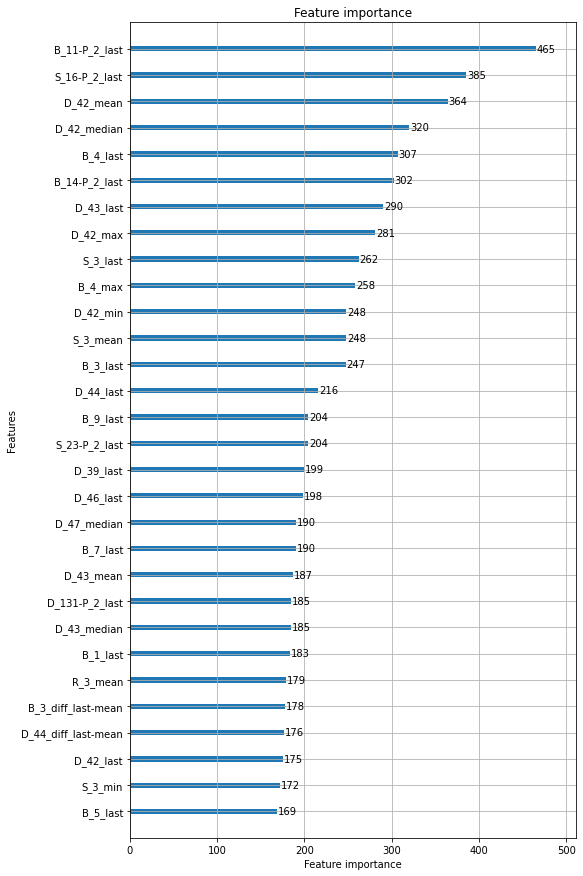

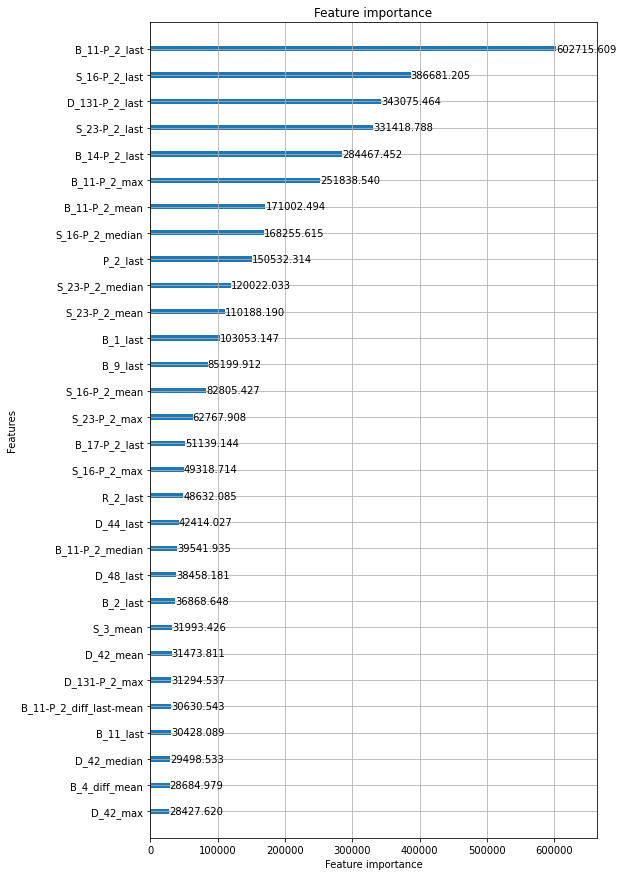

######################################## training model 2/5 ########################################
seed: 6


[50]	valid_0's amex_metric: 0.747793	valid_0's recall_at4: 0.596104	valid_0's norm_gini: 0.899483


[100]	valid_0's amex_metric: 0.761064	valid_0's recall_at4: 0.615585	valid_0's norm_gini: 0.906543


[150]	valid_0's amex_metric: 0.765793	valid_0's recall_at4: 0.621686	valid_0's norm_gini: 0.9099


[200]	valid_0's amex_metric: 0.770752	valid_0's recall_at4: 0.628755	valid_0's norm_gini: 0.912748


[250]	valid_0's amex_metric: 0.774127	valid_0's recall_at4: 0.63351	valid_0's norm_gini: 0.914745


[300]	valid_0's amex_metric: 0.777597	valid_0's recall_at4: 0.638728	valid_0's norm_gini: 0.916467


[350]	valid_0's amex_metric: 0.778654	valid_0's recall_at4: 0.639864	valid_0's norm_gini: 0.917444


[400]	valid_0's amex_metric: 0.780507	valid_0's recall_at4: 0.642557	valid_0's norm_gini: 0.918458


[450]	valid_0's amex_metric: 0.781733	valid_0's recall_at4: 0.644198	valid_0's norm_gini: 0.919268


[500]	valid_0's amex_metric: 0.783365	valid_0's recall_at4: 0.646891	valid_0's norm_gini: 0.91984


[550]	valid_0's amex_metric: 0.784429	valid_0's recall_at4: 0.648405	valid_0's norm_gini: 0.920452


[600]	valid_0's amex_metric: 0.785227	valid_0's recall_at4: 0.649541	valid_0's norm_gini: 0.920913


[650]	valid_0's amex_metric: 0.786304	valid_0's recall_at4: 0.651267	valid_0's norm_gini: 0.921342


[700]	valid_0's amex_metric: 0.787068	valid_0's recall_at4: 0.652529	valid_0's norm_gini: 0.921607


[750]	valid_0's amex_metric: 0.787505	valid_0's recall_at4: 0.653118	valid_0's norm_gini: 0.921892


[800]	valid_0's amex_metric: 0.788013	valid_0's recall_at4: 0.653875	valid_0's norm_gini: 0.922151


[850]	valid_0's amex_metric: 0.788377	valid_0's recall_at4: 0.654464	valid_0's norm_gini: 0.922289


[900]	valid_0's amex_metric: 0.78869	valid_0's recall_at4: 0.654885	valid_0's norm_gini: 0.922494


[950]	valid_0's amex_metric: 0.78892	valid_0's recall_at4: 0.655138	valid_0's norm_gini: 0.922701


[1000]	valid_0's amex_metric: 0.788702	valid_0's recall_at4: 0.654549	valid_0's norm_gini: 0.922856


[1050]	valid_0's amex_metric: 0.789476	valid_0's recall_at4: 0.655937	valid_0's norm_gini: 0.923015


[1100]	valid_0's amex_metric: 0.790124	valid_0's recall_at4: 0.657073	valid_0's norm_gini: 0.923176


[1150]	valid_0's amex_metric: 0.790444	valid_0's recall_at4: 0.657578	valid_0's norm_gini: 0.923309


[1200]	valid_0's amex_metric: 0.790408	valid_0's recall_at4: 0.65741	valid_0's norm_gini: 0.923407


[1250]	valid_0's amex_metric: 0.790892	valid_0's recall_at4: 0.658251	valid_0's norm_gini: 0.923533


[1300]	valid_0's amex_metric: 0.791372	valid_0's recall_at4: 0.659093	valid_0's norm_gini: 0.923651


[1350]	valid_0's amex_metric: 0.791872	valid_0's recall_at4: 0.660019	valid_0's norm_gini: 0.923725


[1400]	valid_0's amex_metric: 0.791812	valid_0's recall_at4: 0.659808	valid_0's norm_gini: 0.923816


[1450]	valid_0's amex_metric: 0.792239	valid_0's recall_at4: 0.660608	valid_0's norm_gini: 0.92387


[1500]	valid_0's amex_metric: 0.792383	valid_0's recall_at4: 0.660818	valid_0's norm_gini: 0.923948


[1550]	valid_0's amex_metric: 0.792404	valid_0's recall_at4: 0.660776	valid_0's norm_gini: 0.924033


[1600]	valid_0's amex_metric: 0.792959	valid_0's recall_at4: 0.661828	valid_0's norm_gini: 0.924091


[1650]	valid_0's amex_metric: 0.792434	valid_0's recall_at4: 0.660734	valid_0's norm_gini: 0.924135


[1700]	valid_0's amex_metric: 0.792957	valid_0's recall_at4: 0.661744	valid_0's norm_gini: 0.92417


[1750]	valid_0's amex_metric: 0.792922	valid_0's recall_at4: 0.661617	valid_0's norm_gini: 0.924226


[1800]	valid_0's amex_metric: 0.792577	valid_0's recall_at4: 0.66086	valid_0's norm_gini: 0.924294


[1850]	valid_0's amex_metric: 0.793061	valid_0's recall_at4: 0.661786	valid_0's norm_gini: 0.924336


[1900]	valid_0's amex_metric: 0.793383	valid_0's recall_at4: 0.662375	valid_0's norm_gini: 0.924392


[1950]	valid_0's amex_metric: 0.79356	valid_0's recall_at4: 0.662711	valid_0's norm_gini: 0.924408


[2000]	valid_0's amex_metric: 0.793582	valid_0's recall_at4: 0.662711	valid_0's norm_gini: 0.924452


[2050]	valid_0's amex_metric: 0.793385	valid_0's recall_at4: 0.662291	valid_0's norm_gini: 0.92448


[2100]	valid_0's amex_metric: 0.793547	valid_0's recall_at4: 0.662585	valid_0's norm_gini: 0.924509


[2150]	valid_0's amex_metric: 0.793608	valid_0's recall_at4: 0.662669	valid_0's norm_gini: 0.924547


[2200]	valid_0's amex_metric: 0.793827	valid_0's recall_at4: 0.663048	valid_0's norm_gini: 0.924606


[2250]	valid_0's amex_metric: 0.79359	valid_0's recall_at4: 0.662543	valid_0's norm_gini: 0.924637


[2300]	valid_0's amex_metric: 0.793449	valid_0's recall_at4: 0.662249	valid_0's norm_gini: 0.924648


[2350]	valid_0's amex_metric: 0.793798	valid_0's recall_at4: 0.662922	valid_0's norm_gini: 0.924674


[2400]	valid_0's amex_metric: 0.793831	valid_0's recall_at4: 0.662964	valid_0's norm_gini: 0.924698


[2450]	valid_0's amex_metric: 0.793671	valid_0's recall_at4: 0.662627	valid_0's norm_gini: 0.924714


[2500]	valid_0's amex_metric: 0.793765	valid_0's recall_at4: 0.662796	valid_0's norm_gini: 0.924734


[2550]	valid_0's amex_metric: 0.793903	valid_0's recall_at4: 0.663048	valid_0's norm_gini: 0.924759


[2600]	valid_0's amex_metric: 0.793949	valid_0's recall_at4: 0.663132	valid_0's norm_gini: 0.924766


[2650]	valid_0's amex_metric: 0.793942	valid_0's recall_at4: 0.66309	valid_0's norm_gini: 0.924793


[2700]	valid_0's amex_metric: 0.793929	valid_0's recall_at4: 0.663048	valid_0's norm_gini: 0.92481


[2750]	valid_0's amex_metric: 0.794067	valid_0's recall_at4: 0.663301	valid_0's norm_gini: 0.924833


[2800]	valid_0's amex_metric: 0.793748	valid_0's recall_at4: 0.662669	valid_0's norm_gini: 0.924826


[2850]	valid_0's amex_metric: 0.793792	valid_0's recall_at4: 0.662754	valid_0's norm_gini: 0.92483


[2900]	valid_0's amex_metric: 0.793848	valid_0's recall_at4: 0.66288	valid_0's norm_gini: 0.924817


[2950]	valid_0's amex_metric: 0.793645	valid_0's recall_at4: 0.662459	valid_0's norm_gini: 0.924831


[3000]	valid_0's amex_metric: 0.79371	valid_0's recall_at4: 0.662543	valid_0's norm_gini: 0.924877


[3050]	valid_0's amex_metric: 0.793824	valid_0's recall_at4: 0.662754	valid_0's norm_gini: 0.924894


[3100]	valid_0's amex_metric: 0.793773	valid_0's recall_at4: 0.662627	valid_0's norm_gini: 0.92492


[3150]	valid_0's amex_metric: 0.794353	valid_0's recall_at4: 0.663763	valid_0's norm_gini: 0.924943


[3200]	valid_0's amex_metric: 0.794313	valid_0's recall_at4: 0.663679	valid_0's norm_gini: 0.924947


[3250]	valid_0's amex_metric: 0.793906	valid_0's recall_at4: 0.66288	valid_0's norm_gini: 0.924931


[3300]	valid_0's amex_metric: 0.794109	valid_0's recall_at4: 0.663301	valid_0's norm_gini: 0.924917


[3350]	valid_0's amex_metric: 0.79401	valid_0's recall_at4: 0.66309	valid_0's norm_gini: 0.924931


[3400]	valid_0's amex_metric: 0.794057	valid_0's recall_at4: 0.663174	valid_0's norm_gini: 0.92494


[3450]	valid_0's amex_metric: 0.794369	valid_0's recall_at4: 0.663805	valid_0's norm_gini: 0.924933


[3500]	valid_0's amex_metric: 0.794605	valid_0's recall_at4: 0.664268	valid_0's norm_gini: 0.924942


[3550]	valid_0's amex_metric: 0.7945	valid_0's recall_at4: 0.664058	valid_0's norm_gini: 0.924942


[3600]	valid_0's amex_metric: 0.794444	valid_0's recall_at4: 0.663932	valid_0's norm_gini: 0.924955


[3650]	valid_0's amex_metric: 0.794632	valid_0's recall_at4: 0.66431	valid_0's norm_gini: 0.924954


[3700]	valid_0's amex_metric: 0.794611	valid_0's recall_at4: 0.664268	valid_0's norm_gini: 0.924954


[3750]	valid_0's amex_metric: 0.794716	valid_0's recall_at4: 0.664479	valid_0's norm_gini: 0.924954


[3800]	valid_0's amex_metric: 0.79489	valid_0's recall_at4: 0.664815	valid_0's norm_gini: 0.924965


[3850]	valid_0's amex_metric: 0.794684	valid_0's recall_at4: 0.664394	valid_0's norm_gini: 0.924974


[3900]	valid_0's amex_metric: 0.794648	valid_0's recall_at4: 0.66431	valid_0's norm_gini: 0.924986


[3950]	valid_0's amex_metric: 0.794709	valid_0's recall_at4: 0.664437	valid_0's norm_gini: 0.924982


[4000]	valid_0's amex_metric: 0.794629	valid_0's recall_at4: 0.664268	valid_0's norm_gini: 0.924989


[4050]	valid_0's amex_metric: 0.794361	valid_0's recall_at4: 0.663721	valid_0's norm_gini: 0.925001


[4100]	valid_0's amex_metric: 0.794606	valid_0's recall_at4: 0.664184	valid_0's norm_gini: 0.925028


[4150]	valid_0's amex_metric: 0.794514	valid_0's recall_at4: 0.663974	valid_0's norm_gini: 0.925054


[4200]	valid_0's amex_metric: 0.794606	valid_0's recall_at4: 0.664142	valid_0's norm_gini: 0.925071


[4250]	valid_0's amex_metric: 0.79465	valid_0's recall_at4: 0.664226	valid_0's norm_gini: 0.925074


[4300]	valid_0's amex_metric: 0.79463	valid_0's recall_at4: 0.664184	valid_0's norm_gini: 0.925076


[4350]	valid_0's amex_metric: 0.794402	valid_0's recall_at4: 0.663721	valid_0's norm_gini: 0.925083


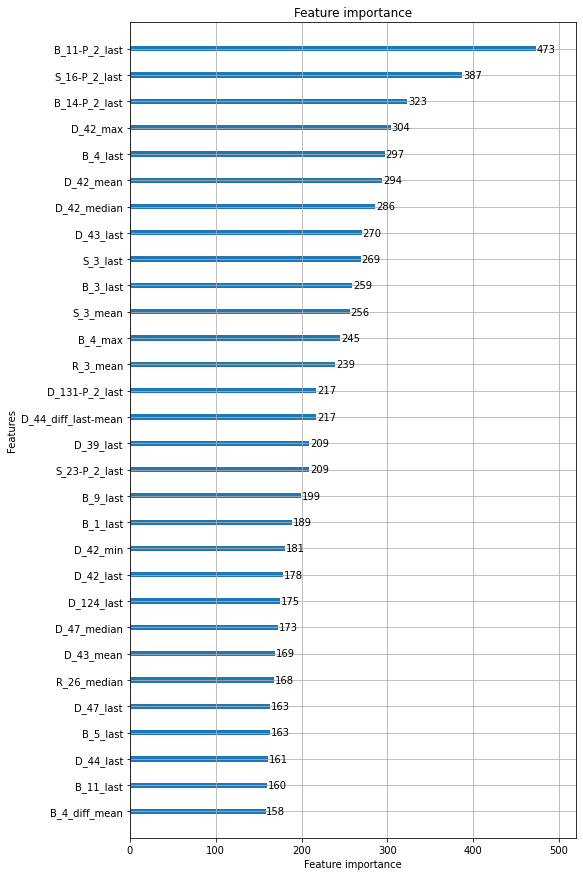

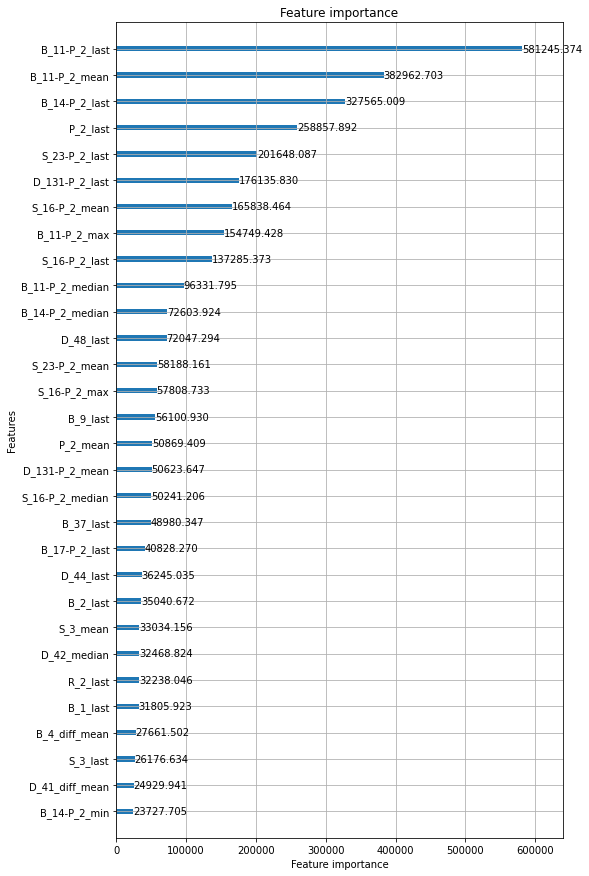

######################################## training model 3/5 ########################################
seed: 7


[50]	valid_0's amex_metric: 0.744612	valid_0's recall_at4: 0.591559	valid_0's norm_gini: 0.897664


[100]	valid_0's amex_metric: 0.757287	valid_0's recall_at4: 0.610115	valid_0's norm_gini: 0.904458


[150]	valid_0's amex_metric: 0.763063	valid_0's recall_at4: 0.618278	valid_0's norm_gini: 0.907848


[200]	valid_0's amex_metric: 0.766435	valid_0's recall_at4: 0.622738	valid_0's norm_gini: 0.910131


[250]	valid_0's amex_metric: 0.769681	valid_0's recall_at4: 0.627114	valid_0's norm_gini: 0.912247


[300]	valid_0's amex_metric: 0.77445	valid_0's recall_at4: 0.634141	valid_0's norm_gini: 0.914759


[350]	valid_0's amex_metric: 0.776645	valid_0's recall_at4: 0.636918	valid_0's norm_gini: 0.916373


[400]	valid_0's amex_metric: 0.778821	valid_0's recall_at4: 0.640284	valid_0's norm_gini: 0.917358


[450]	valid_0's amex_metric: 0.78008	valid_0's recall_at4: 0.641968	valid_0's norm_gini: 0.918192


[500]	valid_0's amex_metric: 0.78194	valid_0's recall_at4: 0.644829	valid_0's norm_gini: 0.91905


[550]	valid_0's amex_metric: 0.7826	valid_0's recall_at4: 0.645418	valid_0's norm_gini: 0.919783


[600]	valid_0's amex_metric: 0.78379	valid_0's recall_at4: 0.647311	valid_0's norm_gini: 0.920269


[650]	valid_0's amex_metric: 0.78454	valid_0's recall_at4: 0.648489	valid_0's norm_gini: 0.92059


[700]	valid_0's amex_metric: 0.785492	valid_0's recall_at4: 0.649962	valid_0's norm_gini: 0.921022


[750]	valid_0's amex_metric: 0.786038	valid_0's recall_at4: 0.650804	valid_0's norm_gini: 0.921273


[800]	valid_0's amex_metric: 0.7866	valid_0's recall_at4: 0.651687	valid_0's norm_gini: 0.921513


[850]	valid_0's amex_metric: 0.787499	valid_0's recall_at4: 0.653202	valid_0's norm_gini: 0.921796


[900]	valid_0's amex_metric: 0.78793	valid_0's recall_at4: 0.653917	valid_0's norm_gini: 0.921944


[950]	valid_0's amex_metric: 0.788315	valid_0's recall_at4: 0.654506	valid_0's norm_gini: 0.922123


[1000]	valid_0's amex_metric: 0.788525	valid_0's recall_at4: 0.654717	valid_0's norm_gini: 0.922334


[1050]	valid_0's amex_metric: 0.788717	valid_0's recall_at4: 0.654969	valid_0's norm_gini: 0.922465


[1100]	valid_0's amex_metric: 0.78924	valid_0's recall_at4: 0.655853	valid_0's norm_gini: 0.922626


[1150]	valid_0's amex_metric: 0.789776	valid_0's recall_at4: 0.656779	valid_0's norm_gini: 0.922772


[1200]	valid_0's amex_metric: 0.789638	valid_0's recall_at4: 0.656358	valid_0's norm_gini: 0.922919


[1250]	valid_0's amex_metric: 0.789729	valid_0's recall_at4: 0.6564	valid_0's norm_gini: 0.923058


[1300]	valid_0's amex_metric: 0.789795	valid_0's recall_at4: 0.656442	valid_0's norm_gini: 0.923148


[1350]	valid_0's amex_metric: 0.789826	valid_0's recall_at4: 0.656442	valid_0's norm_gini: 0.923211


[1400]	valid_0's amex_metric: 0.790282	valid_0's recall_at4: 0.657283	valid_0's norm_gini: 0.923281


[1450]	valid_0's amex_metric: 0.790621	valid_0's recall_at4: 0.657873	valid_0's norm_gini: 0.923369


[1500]	valid_0's amex_metric: 0.790692	valid_0's recall_at4: 0.657915	valid_0's norm_gini: 0.92347


[1550]	valid_0's amex_metric: 0.790562	valid_0's recall_at4: 0.657578	valid_0's norm_gini: 0.923545


[1600]	valid_0's amex_metric: 0.790448	valid_0's recall_at4: 0.657326	valid_0's norm_gini: 0.92357


[1650]	valid_0's amex_metric: 0.790816	valid_0's recall_at4: 0.657999	valid_0's norm_gini: 0.923633


[1700]	valid_0's amex_metric: 0.79042	valid_0's recall_at4: 0.657199	valid_0's norm_gini: 0.92364


[1750]	valid_0's amex_metric: 0.790799	valid_0's recall_at4: 0.657915	valid_0's norm_gini: 0.923684


[1800]	valid_0's amex_metric: 0.791359	valid_0's recall_at4: 0.658967	valid_0's norm_gini: 0.923752


[1850]	valid_0's amex_metric: 0.79126	valid_0's recall_at4: 0.658714	valid_0's norm_gini: 0.923807


[1900]	valid_0's amex_metric: 0.791372	valid_0's recall_at4: 0.658882	valid_0's norm_gini: 0.923861


[1950]	valid_0's amex_metric: 0.791808	valid_0's recall_at4: 0.659724	valid_0's norm_gini: 0.923893


[2000]	valid_0's amex_metric: 0.791703	valid_0's recall_at4: 0.659472	valid_0's norm_gini: 0.923935


[2050]	valid_0's amex_metric: 0.791531	valid_0's recall_at4: 0.659093	valid_0's norm_gini: 0.923969


[2100]	valid_0's amex_metric: 0.791861	valid_0's recall_at4: 0.659724	valid_0's norm_gini: 0.923999


[2150]	valid_0's amex_metric: 0.79198	valid_0's recall_at4: 0.659934	valid_0's norm_gini: 0.924026


[2200]	valid_0's amex_metric: 0.792106	valid_0's recall_at4: 0.660145	valid_0's norm_gini: 0.924066


[2250]	valid_0's amex_metric: 0.79241	valid_0's recall_at4: 0.660734	valid_0's norm_gini: 0.924086


[2300]	valid_0's amex_metric: 0.792311	valid_0's recall_at4: 0.660523	valid_0's norm_gini: 0.9241


[2350]	valid_0's amex_metric: 0.792082	valid_0's recall_at4: 0.660061	valid_0's norm_gini: 0.924103


[2400]	valid_0's amex_metric: 0.791992	valid_0's recall_at4: 0.65985	valid_0's norm_gini: 0.924133


[2450]	valid_0's amex_metric: 0.792106	valid_0's recall_at4: 0.660061	valid_0's norm_gini: 0.924152


[2500]	valid_0's amex_metric: 0.792034	valid_0's recall_at4: 0.659892	valid_0's norm_gini: 0.924175


[2550]	valid_0's amex_metric: 0.791952	valid_0's recall_at4: 0.659724	valid_0's norm_gini: 0.924179


[2600]	valid_0's amex_metric: 0.791999	valid_0's recall_at4: 0.659808	valid_0's norm_gini: 0.924189


[2650]	valid_0's amex_metric: 0.791725	valid_0's recall_at4: 0.659261	valid_0's norm_gini: 0.924188


[2700]	valid_0's amex_metric: 0.792113	valid_0's recall_at4: 0.660019	valid_0's norm_gini: 0.924208


[2750]	valid_0's amex_metric: 0.792171	valid_0's recall_at4: 0.660145	valid_0's norm_gini: 0.924196


[2800]	valid_0's amex_metric: 0.791763	valid_0's recall_at4: 0.659345	valid_0's norm_gini: 0.924181


[2850]	valid_0's amex_metric: 0.792161	valid_0's recall_at4: 0.660145	valid_0's norm_gini: 0.924177


[2900]	valid_0's amex_metric: 0.792044	valid_0's recall_at4: 0.659892	valid_0's norm_gini: 0.924196


[2950]	valid_0's amex_metric: 0.792155	valid_0's recall_at4: 0.660103	valid_0's norm_gini: 0.924207


[3000]	valid_0's amex_metric: 0.791707	valid_0's recall_at4: 0.659177	valid_0's norm_gini: 0.924236


[3050]	valid_0's amex_metric: 0.79182	valid_0's recall_at4: 0.659387	valid_0's norm_gini: 0.924252


[3100]	valid_0's amex_metric: 0.791783	valid_0's recall_at4: 0.659303	valid_0's norm_gini: 0.924262


[3150]	valid_0's amex_metric: 0.791677	valid_0's recall_at4: 0.659093	valid_0's norm_gini: 0.924261


[3200]	valid_0's amex_metric: 0.791778	valid_0's recall_at4: 0.659303	valid_0's norm_gini: 0.924252


[3250]	valid_0's amex_metric: 0.791649	valid_0's recall_at4: 0.659051	valid_0's norm_gini: 0.924247


[3300]	valid_0's amex_metric: 0.791573	valid_0's recall_at4: 0.658882	valid_0's norm_gini: 0.924265


[3350]	valid_0's amex_metric: 0.791701	valid_0's recall_at4: 0.659135	valid_0's norm_gini: 0.924267


[3400]	valid_0's amex_metric: 0.791138	valid_0's recall_at4: 0.657999	valid_0's norm_gini: 0.924277


[3450]	valid_0's amex_metric: 0.791689	valid_0's recall_at4: 0.659093	valid_0's norm_gini: 0.924284


[3500]	valid_0's amex_metric: 0.791521	valid_0's recall_at4: 0.658756	valid_0's norm_gini: 0.924285


[3550]	valid_0's amex_metric: 0.791539	valid_0's recall_at4: 0.658798	valid_0's norm_gini: 0.92428


[3600]	valid_0's amex_metric: 0.792316	valid_0's recall_at4: 0.660355	valid_0's norm_gini: 0.924276


[3650]	valid_0's amex_metric: 0.792058	valid_0's recall_at4: 0.65985	valid_0's norm_gini: 0.924266


[3700]	valid_0's amex_metric: 0.792333	valid_0's recall_at4: 0.660397	valid_0's norm_gini: 0.924269


[3750]	valid_0's amex_metric: 0.791916	valid_0's recall_at4: 0.659556	valid_0's norm_gini: 0.924276


[3800]	valid_0's amex_metric: 0.792157	valid_0's recall_at4: 0.660019	valid_0's norm_gini: 0.924295


[3850]	valid_0's amex_metric: 0.791941	valid_0's recall_at4: 0.659598	valid_0's norm_gini: 0.924284


[3900]	valid_0's amex_metric: 0.79231	valid_0's recall_at4: 0.660313	valid_0's norm_gini: 0.924307


[3950]	valid_0's amex_metric: 0.792077	valid_0's recall_at4: 0.65985	valid_0's norm_gini: 0.924305


[4000]	valid_0's amex_metric: 0.792495	valid_0's recall_at4: 0.660692	valid_0's norm_gini: 0.924298


[4050]	valid_0's amex_metric: 0.79213	valid_0's recall_at4: 0.659976	valid_0's norm_gini: 0.924283


[4100]	valid_0's amex_metric: 0.792384	valid_0's recall_at4: 0.660481	valid_0's norm_gini: 0.924288


[4150]	valid_0's amex_metric: 0.792451	valid_0's recall_at4: 0.660608	valid_0's norm_gini: 0.924294


[4200]	valid_0's amex_metric: 0.792663	valid_0's recall_at4: 0.661028	valid_0's norm_gini: 0.924297


[4250]	valid_0's amex_metric: 0.792729	valid_0's recall_at4: 0.661155	valid_0's norm_gini: 0.924303


[4300]	valid_0's amex_metric: 0.792701	valid_0's recall_at4: 0.661112	valid_0's norm_gini: 0.92429


[4350]	valid_0's amex_metric: 0.792674	valid_0's recall_at4: 0.66107	valid_0's norm_gini: 0.924277


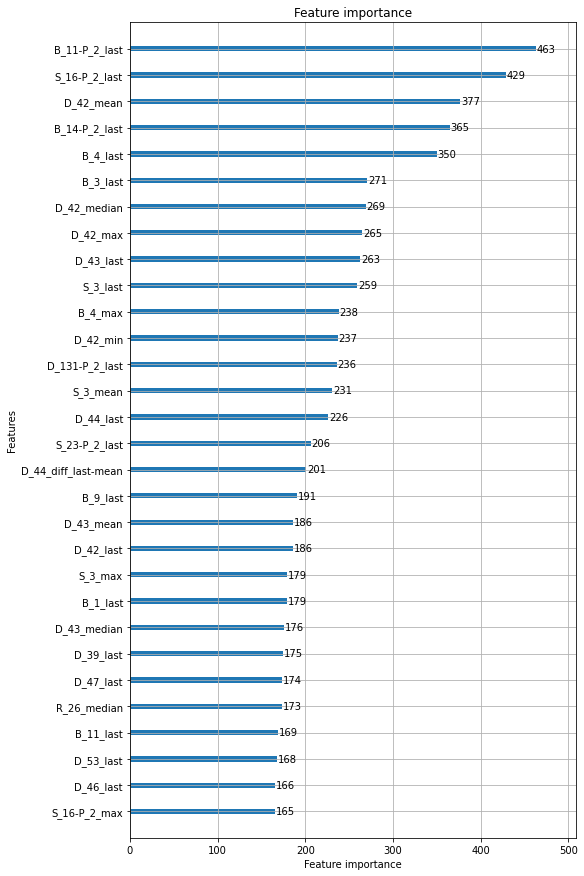

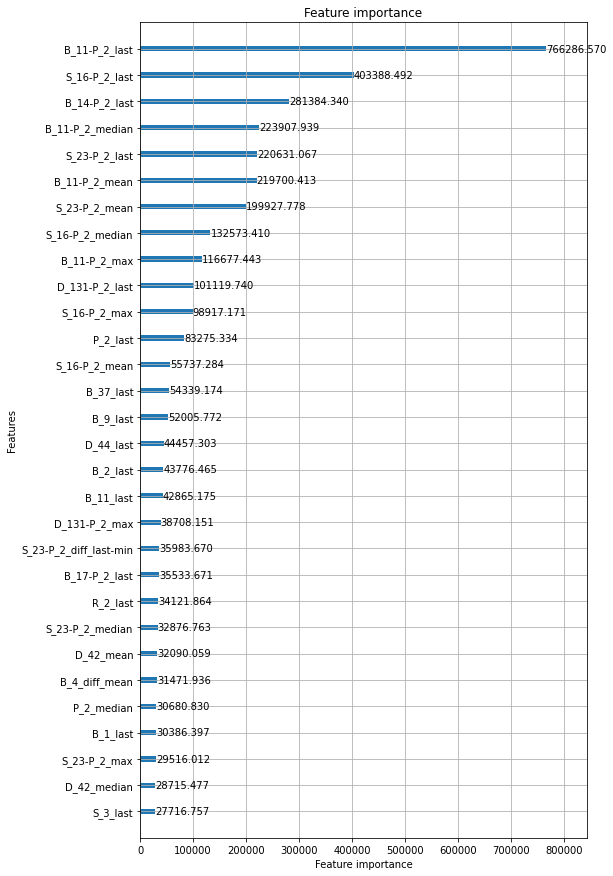

######################################## training model 4/5 ########################################
seed: 8


[50]	valid_0's amex_metric: 0.75079	valid_0's recall_at4: 0.601851	valid_0's norm_gini: 0.899728


[100]	valid_0's amex_metric: 0.761997	valid_0's recall_at4: 0.617252	valid_0's norm_gini: 0.906742


[150]	valid_0's amex_metric: 0.769826	valid_0's recall_at4: 0.628698	valid_0's norm_gini: 0.910954


[200]	valid_0's amex_metric: 0.773651	valid_0's recall_at4: 0.634252	valid_0's norm_gini: 0.913049


[250]	valid_0's amex_metric: 0.777921	valid_0's recall_at4: 0.640732	valid_0's norm_gini: 0.915109


[300]	valid_0's amex_metric: 0.781877	valid_0's recall_at4: 0.646918	valid_0's norm_gini: 0.916835


[350]	valid_0's amex_metric: 0.784012	valid_0's recall_at4: 0.650242	valid_0's norm_gini: 0.917782


[400]	valid_0's amex_metric: 0.785626	valid_0's recall_at4: 0.652388	valid_0's norm_gini: 0.918864


[450]	valid_0's amex_metric: 0.786776	valid_0's recall_at4: 0.653903	valid_0's norm_gini: 0.919649


[500]	valid_0's amex_metric: 0.788113	valid_0's recall_at4: 0.655754	valid_0's norm_gini: 0.920471


[550]	valid_0's amex_metric: 0.789093	valid_0's recall_at4: 0.657101	valid_0's norm_gini: 0.921085


[600]	valid_0's amex_metric: 0.790333	valid_0's recall_at4: 0.659163	valid_0's norm_gini: 0.921504


[650]	valid_0's amex_metric: 0.791219	valid_0's recall_at4: 0.660551	valid_0's norm_gini: 0.921886


[700]	valid_0's amex_metric: 0.792078	valid_0's recall_at4: 0.66194	valid_0's norm_gini: 0.922216


[750]	valid_0's amex_metric: 0.793158	valid_0's recall_at4: 0.663833	valid_0's norm_gini: 0.922482


[800]	valid_0's amex_metric: 0.793698	valid_0's recall_at4: 0.664717	valid_0's norm_gini: 0.922679


[850]	valid_0's amex_metric: 0.793916	valid_0's recall_at4: 0.66497	valid_0's norm_gini: 0.922863


[900]	valid_0's amex_metric: 0.794705	valid_0's recall_at4: 0.666358	valid_0's norm_gini: 0.923052


[950]	valid_0's amex_metric: 0.794367	valid_0's recall_at4: 0.665516	valid_0's norm_gini: 0.923217


[1000]	valid_0's amex_metric: 0.795123	valid_0's recall_at4: 0.666821	valid_0's norm_gini: 0.923426


[1050]	valid_0's amex_metric: 0.795814	valid_0's recall_at4: 0.668041	valid_0's norm_gini: 0.923587


[1100]	valid_0's amex_metric: 0.796668	valid_0's recall_at4: 0.669598	valid_0's norm_gini: 0.923739


[1150]	valid_0's amex_metric: 0.796151	valid_0's recall_at4: 0.668462	valid_0's norm_gini: 0.92384


[1200]	valid_0's amex_metric: 0.796344	valid_0's recall_at4: 0.668715	valid_0's norm_gini: 0.923973


[1250]	valid_0's amex_metric: 0.79712	valid_0's recall_at4: 0.670145	valid_0's norm_gini: 0.924096


[1300]	valid_0's amex_metric: 0.797357	valid_0's recall_at4: 0.670482	valid_0's norm_gini: 0.924232


[1350]	valid_0's amex_metric: 0.797675	valid_0's recall_at4: 0.670987	valid_0's norm_gini: 0.924363


[1400]	valid_0's amex_metric: 0.797994	valid_0's recall_at4: 0.671534	valid_0's norm_gini: 0.924454


[1450]	valid_0's amex_metric: 0.797704	valid_0's recall_at4: 0.670903	valid_0's norm_gini: 0.924505


[1500]	valid_0's amex_metric: 0.797779	valid_0's recall_at4: 0.670987	valid_0's norm_gini: 0.924572


[1550]	valid_0's amex_metric: 0.797973	valid_0's recall_at4: 0.671323	valid_0's norm_gini: 0.924623


[1600]	valid_0's amex_metric: 0.798212	valid_0's recall_at4: 0.671744	valid_0's norm_gini: 0.92468


[1650]	valid_0's amex_metric: 0.797593	valid_0's recall_at4: 0.67044	valid_0's norm_gini: 0.924747


[1700]	valid_0's amex_metric: 0.798263	valid_0's recall_at4: 0.671702	valid_0's norm_gini: 0.924824


[1750]	valid_0's amex_metric: 0.798807	valid_0's recall_at4: 0.672754	valid_0's norm_gini: 0.924861


[1800]	valid_0's amex_metric: 0.799069	valid_0's recall_at4: 0.673259	valid_0's norm_gini: 0.92488


[1850]	valid_0's amex_metric: 0.798497	valid_0's recall_at4: 0.672081	valid_0's norm_gini: 0.924914


[1900]	valid_0's amex_metric: 0.798389	valid_0's recall_at4: 0.671828	valid_0's norm_gini: 0.924949


[1950]	valid_0's amex_metric: 0.798344	valid_0's recall_at4: 0.671702	valid_0's norm_gini: 0.924986


[2000]	valid_0's amex_metric: 0.798271	valid_0's recall_at4: 0.671534	valid_0's norm_gini: 0.925008


[2050]	valid_0's amex_metric: 0.797983	valid_0's recall_at4: 0.670945	valid_0's norm_gini: 0.925021


[2100]	valid_0's amex_metric: 0.797907	valid_0's recall_at4: 0.670776	valid_0's norm_gini: 0.925038


[2150]	valid_0's amex_metric: 0.797598	valid_0's recall_at4: 0.670145	valid_0's norm_gini: 0.925051


[2200]	valid_0's amex_metric: 0.797139	valid_0's recall_at4: 0.669219	valid_0's norm_gini: 0.92506


[2250]	valid_0's amex_metric: 0.7976	valid_0's recall_at4: 0.670103	valid_0's norm_gini: 0.925097


[2300]	valid_0's amex_metric: 0.797638	valid_0's recall_at4: 0.670145	valid_0's norm_gini: 0.92513


[2350]	valid_0's amex_metric: 0.798162	valid_0's recall_at4: 0.671155	valid_0's norm_gini: 0.925169


[2400]	valid_0's amex_metric: 0.798076	valid_0's recall_at4: 0.670945	valid_0's norm_gini: 0.925207


[2450]	valid_0's amex_metric: 0.797821	valid_0's recall_at4: 0.670398	valid_0's norm_gini: 0.925245


[2500]	valid_0's amex_metric: 0.798262	valid_0's recall_at4: 0.671239	valid_0's norm_gini: 0.925285


[2550]	valid_0's amex_metric: 0.798242	valid_0's recall_at4: 0.671155	valid_0's norm_gini: 0.925329


[2600]	valid_0's amex_metric: 0.798185	valid_0's recall_at4: 0.671029	valid_0's norm_gini: 0.925342


[2650]	valid_0's amex_metric: 0.79862	valid_0's recall_at4: 0.67187	valid_0's norm_gini: 0.92537


[2700]	valid_0's amex_metric: 0.798649	valid_0's recall_at4: 0.671912	valid_0's norm_gini: 0.925385


[2750]	valid_0's amex_metric: 0.798481	valid_0's recall_at4: 0.671576	valid_0's norm_gini: 0.925387


[2800]	valid_0's amex_metric: 0.798724	valid_0's recall_at4: 0.672039	valid_0's norm_gini: 0.92541


[2850]	valid_0's amex_metric: 0.798819	valid_0's recall_at4: 0.672207	valid_0's norm_gini: 0.925431


[2900]	valid_0's amex_metric: 0.798675	valid_0's recall_at4: 0.671912	valid_0's norm_gini: 0.925438


[2950]	valid_0's amex_metric: 0.798772	valid_0's recall_at4: 0.672081	valid_0's norm_gini: 0.925464


[3000]	valid_0's amex_metric: 0.798459	valid_0's recall_at4: 0.67145	valid_0's norm_gini: 0.925468


[3050]	valid_0's amex_metric: 0.798636	valid_0's recall_at4: 0.671786	valid_0's norm_gini: 0.925485


[3100]	valid_0's amex_metric: 0.799016	valid_0's recall_at4: 0.672544	valid_0's norm_gini: 0.925489


[3150]	valid_0's amex_metric: 0.798794	valid_0's recall_at4: 0.672081	valid_0's norm_gini: 0.925508


[3200]	valid_0's amex_metric: 0.7988	valid_0's recall_at4: 0.672081	valid_0's norm_gini: 0.92552


[3250]	valid_0's amex_metric: 0.79882	valid_0's recall_at4: 0.672081	valid_0's norm_gini: 0.925559


[3300]	valid_0's amex_metric: 0.7988	valid_0's recall_at4: 0.672039	valid_0's norm_gini: 0.925561


[3350]	valid_0's amex_metric: 0.798975	valid_0's recall_at4: 0.672375	valid_0's norm_gini: 0.925574


[3400]	valid_0's amex_metric: 0.798558	valid_0's recall_at4: 0.671534	valid_0's norm_gini: 0.925582


[3450]	valid_0's amex_metric: 0.798305	valid_0's recall_at4: 0.671029	valid_0's norm_gini: 0.925581


[3500]	valid_0's amex_metric: 0.798667	valid_0's recall_at4: 0.671744	valid_0's norm_gini: 0.92559


[3550]	valid_0's amex_metric: 0.798509	valid_0's recall_at4: 0.671408	valid_0's norm_gini: 0.92561


[3600]	valid_0's amex_metric: 0.798637	valid_0's recall_at4: 0.67166	valid_0's norm_gini: 0.925615


[3650]	valid_0's amex_metric: 0.79878	valid_0's recall_at4: 0.671912	valid_0's norm_gini: 0.925647


[3700]	valid_0's amex_metric: 0.798559	valid_0's recall_at4: 0.671492	valid_0's norm_gini: 0.925627


[3750]	valid_0's amex_metric: 0.798524	valid_0's recall_at4: 0.671408	valid_0's norm_gini: 0.92564


[3800]	valid_0's amex_metric: 0.798972	valid_0's recall_at4: 0.672291	valid_0's norm_gini: 0.925652


[3850]	valid_0's amex_metric: 0.798878	valid_0's recall_at4: 0.672123	valid_0's norm_gini: 0.925634


[3900]	valid_0's amex_metric: 0.798517	valid_0's recall_at4: 0.671408	valid_0's norm_gini: 0.925627


[3950]	valid_0's amex_metric: 0.799121	valid_0's recall_at4: 0.672586	valid_0's norm_gini: 0.925657


[4000]	valid_0's amex_metric: 0.799117	valid_0's recall_at4: 0.672586	valid_0's norm_gini: 0.925649


[4050]	valid_0's amex_metric: 0.799497	valid_0's recall_at4: 0.673343	valid_0's norm_gini: 0.925651


[4100]	valid_0's amex_metric: 0.799229	valid_0's recall_at4: 0.672796	valid_0's norm_gini: 0.925663


[4150]	valid_0's amex_metric: 0.79934	valid_0's recall_at4: 0.673007	valid_0's norm_gini: 0.925674


[4200]	valid_0's amex_metric: 0.799644	valid_0's recall_at4: 0.673596	valid_0's norm_gini: 0.925692


[4250]	valid_0's amex_metric: 0.799982	valid_0's recall_at4: 0.674269	valid_0's norm_gini: 0.925694


[4300]	valid_0's amex_metric: 0.799854	valid_0's recall_at4: 0.674016	valid_0's norm_gini: 0.925692


[4350]	valid_0's amex_metric: 0.799557	valid_0's recall_at4: 0.673427	valid_0's norm_gini: 0.925687


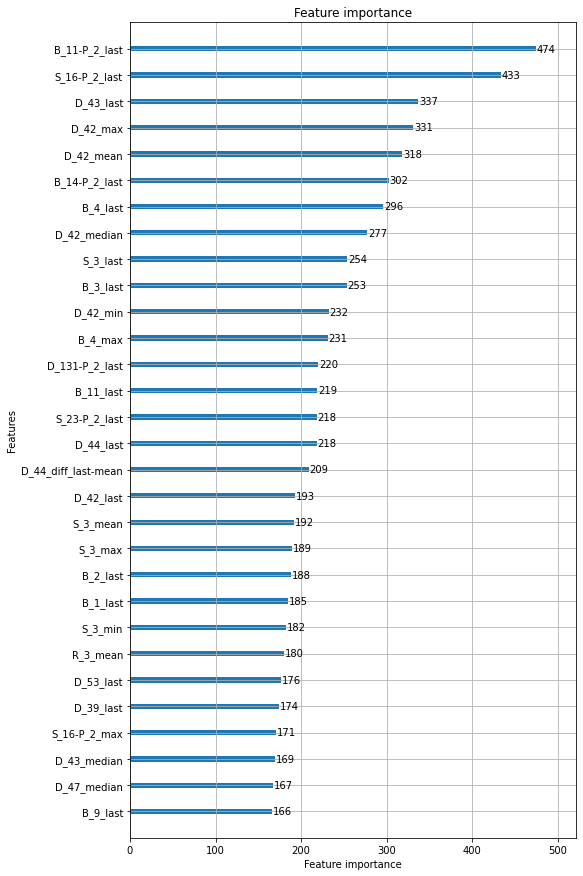

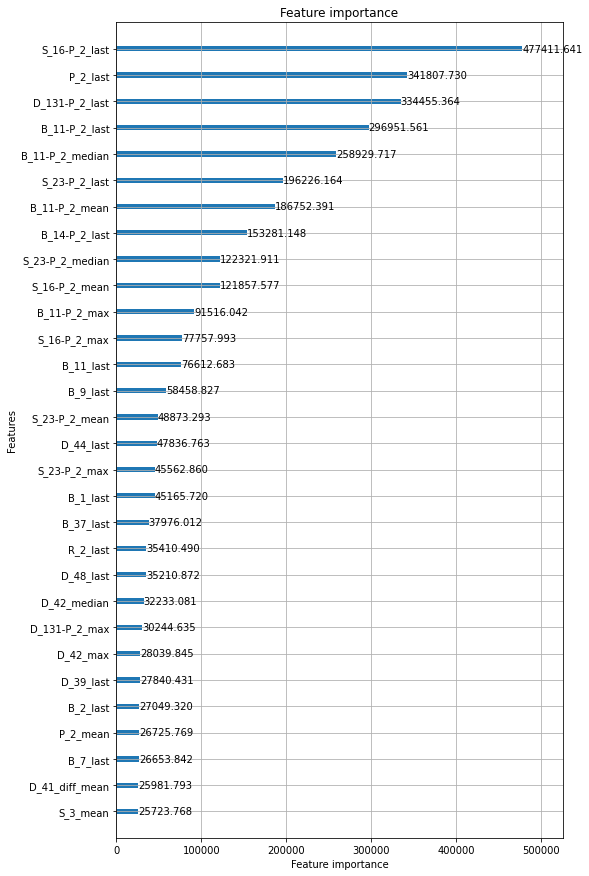

######################################## training model 5/5 ########################################
seed: 9


[50]	valid_0's amex_metric: 0.747732	valid_0's recall_at4: 0.59655	valid_0's norm_gini: 0.898915


[100]	valid_0's amex_metric: 0.761681	valid_0's recall_at4: 0.617589	valid_0's norm_gini: 0.905774


[150]	valid_0's amex_metric: 0.766661	valid_0's recall_at4: 0.624574	valid_0's norm_gini: 0.908747


[200]	valid_0's amex_metric: 0.773739	valid_0's recall_at4: 0.635304	valid_0's norm_gini: 0.912173


[250]	valid_0's amex_metric: 0.777383	valid_0's recall_at4: 0.640227	valid_0's norm_gini: 0.914539


[300]	valid_0's amex_metric: 0.780512	valid_0's recall_at4: 0.644225	valid_0's norm_gini: 0.916799


[350]	valid_0's amex_metric: 0.782469	valid_0's recall_at4: 0.647044	valid_0's norm_gini: 0.917894


[400]	valid_0's amex_metric: 0.784044	valid_0's recall_at4: 0.649358	valid_0's norm_gini: 0.918729


[450]	valid_0's amex_metric: 0.785114	valid_0's recall_at4: 0.650705	valid_0's norm_gini: 0.919524


[500]	valid_0's amex_metric: 0.786292	valid_0's recall_at4: 0.652388	valid_0's norm_gini: 0.920196


[550]	valid_0's amex_metric: 0.787584	valid_0's recall_at4: 0.654408	valid_0's norm_gini: 0.920761


[600]	valid_0's amex_metric: 0.788874	valid_0's recall_at4: 0.656554	valid_0's norm_gini: 0.921195


[650]	valid_0's amex_metric: 0.789277	valid_0's recall_at4: 0.657143	valid_0's norm_gini: 0.921411


[700]	valid_0's amex_metric: 0.79031	valid_0's recall_at4: 0.65891	valid_0's norm_gini: 0.921709


[750]	valid_0's amex_metric: 0.790972	valid_0's recall_at4: 0.659962	valid_0's norm_gini: 0.921983


[800]	valid_0's amex_metric: 0.791303	valid_0's recall_at4: 0.660383	valid_0's norm_gini: 0.922224


[850]	valid_0's amex_metric: 0.791652	valid_0's recall_at4: 0.660804	valid_0's norm_gini: 0.9225


[900]	valid_0's amex_metric: 0.792357	valid_0's recall_at4: 0.661898	valid_0's norm_gini: 0.922815


[950]	valid_0's amex_metric: 0.792776	valid_0's recall_at4: 0.662487	valid_0's norm_gini: 0.923065


[1000]	valid_0's amex_metric: 0.793337	valid_0's recall_at4: 0.663328	valid_0's norm_gini: 0.923345


[1050]	valid_0's amex_metric: 0.793634	valid_0's recall_at4: 0.663749	valid_0's norm_gini: 0.923519


[1100]	valid_0's amex_metric: 0.793282	valid_0's recall_at4: 0.662866	valid_0's norm_gini: 0.923699


[1150]	valid_0's amex_metric: 0.793938	valid_0's recall_at4: 0.664002	valid_0's norm_gini: 0.923875


[1200]	valid_0's amex_metric: 0.793933	valid_0's recall_at4: 0.663833	valid_0's norm_gini: 0.924033


[1250]	valid_0's amex_metric: 0.79469	valid_0's recall_at4: 0.665264	valid_0's norm_gini: 0.924115


[1300]	valid_0's amex_metric: 0.794849	valid_0's recall_at4: 0.665474	valid_0's norm_gini: 0.924224


[1350]	valid_0's amex_metric: 0.794863	valid_0's recall_at4: 0.66539	valid_0's norm_gini: 0.924335


[1400]	valid_0's amex_metric: 0.794787	valid_0's recall_at4: 0.665138	valid_0's norm_gini: 0.924437


[1450]	valid_0's amex_metric: 0.795159	valid_0's recall_at4: 0.665811	valid_0's norm_gini: 0.924508


[1500]	valid_0's amex_metric: 0.795197	valid_0's recall_at4: 0.665811	valid_0's norm_gini: 0.924583


[1550]	valid_0's amex_metric: 0.795611	valid_0's recall_at4: 0.666568	valid_0's norm_gini: 0.924654


[1600]	valid_0's amex_metric: 0.796128	valid_0's recall_at4: 0.667536	valid_0's norm_gini: 0.924721


[1650]	valid_0's amex_metric: 0.795862	valid_0's recall_at4: 0.666947	valid_0's norm_gini: 0.924777


[1700]	valid_0's amex_metric: 0.79624	valid_0's recall_at4: 0.667663	valid_0's norm_gini: 0.924818


[1750]	valid_0's amex_metric: 0.796116	valid_0's recall_at4: 0.667368	valid_0's norm_gini: 0.924863


[1800]	valid_0's amex_metric: 0.796422	valid_0's recall_at4: 0.667915	valid_0's norm_gini: 0.92493


[1850]	valid_0's amex_metric: 0.796318	valid_0's recall_at4: 0.667663	valid_0's norm_gini: 0.924974


[1900]	valid_0's amex_metric: 0.796428	valid_0's recall_at4: 0.667831	valid_0's norm_gini: 0.925026


[1950]	valid_0's amex_metric: 0.7966	valid_0's recall_at4: 0.668125	valid_0's norm_gini: 0.925075


[2000]	valid_0's amex_metric: 0.79642	valid_0's recall_at4: 0.667747	valid_0's norm_gini: 0.925093


[2050]	valid_0's amex_metric: 0.796474	valid_0's recall_at4: 0.667831	valid_0's norm_gini: 0.925117


[2100]	valid_0's amex_metric: 0.796524	valid_0's recall_at4: 0.667915	valid_0's norm_gini: 0.925132


[2150]	valid_0's amex_metric: 0.797037	valid_0's recall_at4: 0.668883	valid_0's norm_gini: 0.925191


[2200]	valid_0's amex_metric: 0.796845	valid_0's recall_at4: 0.668462	valid_0's norm_gini: 0.925229


[2250]	valid_0's amex_metric: 0.797498	valid_0's recall_at4: 0.669724	valid_0's norm_gini: 0.925272


[2300]	valid_0's amex_metric: 0.796955	valid_0's recall_at4: 0.668588	valid_0's norm_gini: 0.925322


[2350]	valid_0's amex_metric: 0.797334	valid_0's recall_at4: 0.669304	valid_0's norm_gini: 0.925364


[2400]	valid_0's amex_metric: 0.797107	valid_0's recall_at4: 0.668841	valid_0's norm_gini: 0.925373


[2450]	valid_0's amex_metric: 0.797456	valid_0's recall_at4: 0.669514	valid_0's norm_gini: 0.925398


[2500]	valid_0's amex_metric: 0.797003	valid_0's recall_at4: 0.668588	valid_0's norm_gini: 0.925417


[2550]	valid_0's amex_metric: 0.797128	valid_0's recall_at4: 0.668841	valid_0's norm_gini: 0.925415


[2600]	valid_0's amex_metric: 0.797496	valid_0's recall_at4: 0.669556	valid_0's norm_gini: 0.925436


[2650]	valid_0's amex_metric: 0.798012	valid_0's recall_at4: 0.670566	valid_0's norm_gini: 0.925458


[2700]	valid_0's amex_metric: 0.798017	valid_0's recall_at4: 0.670566	valid_0's norm_gini: 0.925468


[2750]	valid_0's amex_metric: 0.797771	valid_0's recall_at4: 0.670061	valid_0's norm_gini: 0.925482


[2800]	valid_0's amex_metric: 0.797762	valid_0's recall_at4: 0.670019	valid_0's norm_gini: 0.925506


[2850]	valid_0's amex_metric: 0.797665	valid_0's recall_at4: 0.669809	valid_0's norm_gini: 0.925522


[2900]	valid_0's amex_metric: 0.79748	valid_0's recall_at4: 0.66943	valid_0's norm_gini: 0.925529


[2950]	valid_0's amex_metric: 0.798185	valid_0's recall_at4: 0.670818	valid_0's norm_gini: 0.925551


[3000]	valid_0's amex_metric: 0.79789	valid_0's recall_at4: 0.670229	valid_0's norm_gini: 0.92555


[3050]	valid_0's amex_metric: 0.79763	valid_0's recall_at4: 0.669682	valid_0's norm_gini: 0.925577


[3100]	valid_0's amex_metric: 0.797735	valid_0's recall_at4: 0.669893	valid_0's norm_gini: 0.925576


[3150]	valid_0's amex_metric: 0.797952	valid_0's recall_at4: 0.670313	valid_0's norm_gini: 0.925591


[3200]	valid_0's amex_metric: 0.798713	valid_0's recall_at4: 0.671828	valid_0's norm_gini: 0.925598


[3250]	valid_0's amex_metric: 0.798201	valid_0's recall_at4: 0.670776	valid_0's norm_gini: 0.925626


[3300]	valid_0's amex_metric: 0.797968	valid_0's recall_at4: 0.670313	valid_0's norm_gini: 0.925623


[3350]	valid_0's amex_metric: 0.798158	valid_0's recall_at4: 0.670692	valid_0's norm_gini: 0.925625


[3400]	valid_0's amex_metric: 0.797937	valid_0's recall_at4: 0.670229	valid_0's norm_gini: 0.925645


[3450]	valid_0's amex_metric: 0.797987	valid_0's recall_at4: 0.670313	valid_0's norm_gini: 0.925661


[3500]	valid_0's amex_metric: 0.797656	valid_0's recall_at4: 0.66964	valid_0's norm_gini: 0.925671


[3550]	valid_0's amex_metric: 0.798102	valid_0's recall_at4: 0.670524	valid_0's norm_gini: 0.92568


[3600]	valid_0's amex_metric: 0.798123	valid_0's recall_at4: 0.670566	valid_0's norm_gini: 0.92568


[3650]	valid_0's amex_metric: 0.797948	valid_0's recall_at4: 0.670187	valid_0's norm_gini: 0.925709


[3700]	valid_0's amex_metric: 0.797725	valid_0's recall_at4: 0.669724	valid_0's norm_gini: 0.925725


[3750]	valid_0's amex_metric: 0.79775	valid_0's recall_at4: 0.669766	valid_0's norm_gini: 0.925734


[3800]	valid_0's amex_metric: 0.797583	valid_0's recall_at4: 0.66943	valid_0's norm_gini: 0.925737


[3850]	valid_0's amex_metric: 0.79778	valid_0's recall_at4: 0.669851	valid_0's norm_gini: 0.92571


[3900]	valid_0's amex_metric: 0.797773	valid_0's recall_at4: 0.669809	valid_0's norm_gini: 0.925737


[3950]	valid_0's amex_metric: 0.798079	valid_0's recall_at4: 0.670398	valid_0's norm_gini: 0.925761


[4000]	valid_0's amex_metric: 0.797568	valid_0's recall_at4: 0.669388	valid_0's norm_gini: 0.925747


[4050]	valid_0's amex_metric: 0.797931	valid_0's recall_at4: 0.670103	valid_0's norm_gini: 0.925758


[4100]	valid_0's amex_metric: 0.798314	valid_0's recall_at4: 0.670861	valid_0's norm_gini: 0.925767


[4150]	valid_0's amex_metric: 0.797924	valid_0's recall_at4: 0.670061	valid_0's norm_gini: 0.925787


[4200]	valid_0's amex_metric: 0.798118	valid_0's recall_at4: 0.67044	valid_0's norm_gini: 0.925796


[4250]	valid_0's amex_metric: 0.7985	valid_0's recall_at4: 0.671197	valid_0's norm_gini: 0.925804


[4300]	valid_0's amex_metric: 0.798554	valid_0's recall_at4: 0.671281	valid_0's norm_gini: 0.925826


[4350]	valid_0's amex_metric: 0.798288	valid_0's recall_at4: 0.670734	valid_0's norm_gini: 0.925841


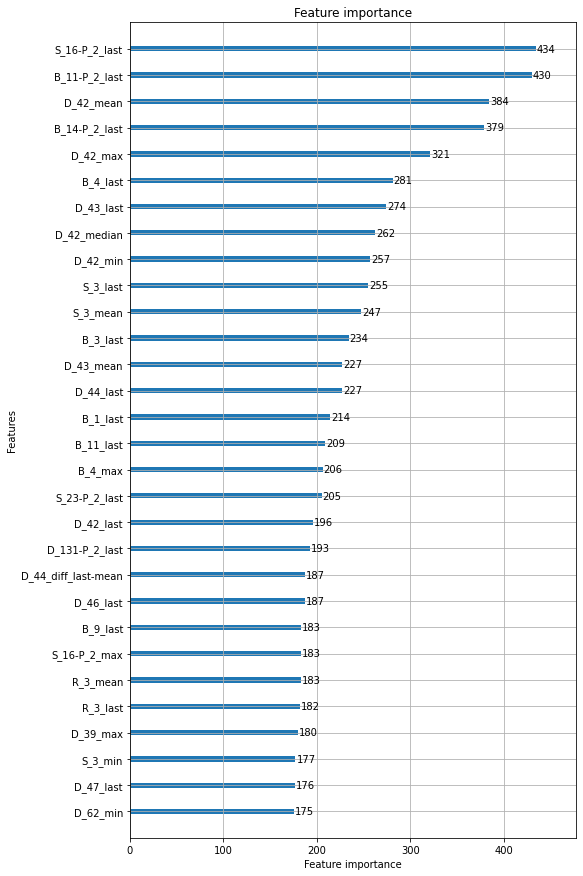

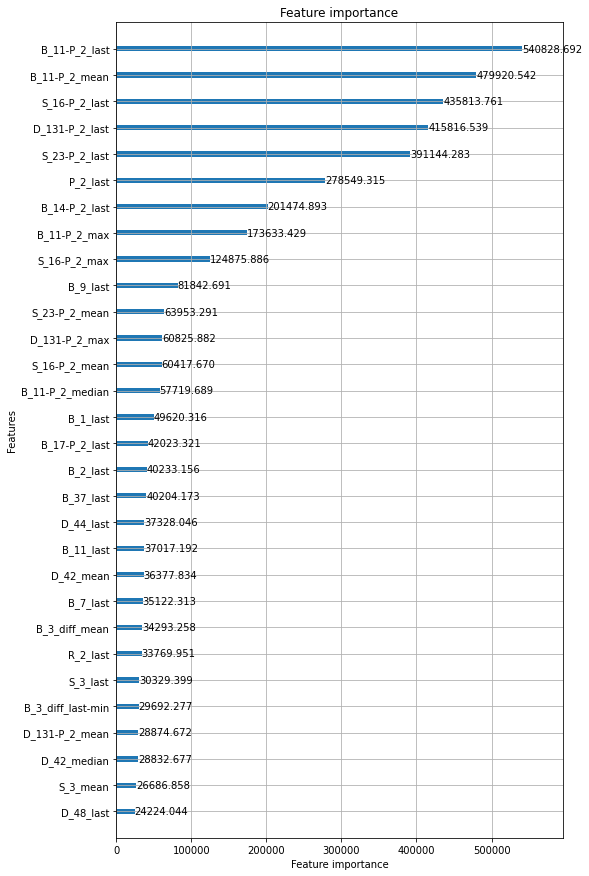

Training time: 34.16001009941101 min.
OOF recall_at4: 0.6684619786582287
OOF normalized_gini: 0.9253450655938967
OOF competition metric: 0.7969035221260627


############################### repeated cross-validation step: 3/5 ################################


######################################## training model 1/5 ########################################
seed: 10


[50]	valid_0's amex_metric: 0.746508	valid_0's recall_at4: 0.594336	valid_0's norm_gini: 0.898679


[100]	valid_0's amex_metric: 0.760724	valid_0's recall_at4: 0.61508	valid_0's norm_gini: 0.906368


[150]	valid_0's amex_metric: 0.764724	valid_0's recall_at4: 0.620256	valid_0's norm_gini: 0.909192


[200]	valid_0's amex_metric: 0.768282	valid_0's recall_at4: 0.625431	valid_0's norm_gini: 0.911132


[250]	valid_0's amex_metric: 0.77083	valid_0's recall_at4: 0.62905	valid_0's norm_gini: 0.912611


[300]	valid_0's amex_metric: 0.774733	valid_0's recall_at4: 0.635067	valid_0's norm_gini: 0.914398


[350]	valid_0's amex_metric: 0.777281	valid_0's recall_at4: 0.638812	valid_0's norm_gini: 0.91575


[400]	valid_0's amex_metric: 0.779768	valid_0's recall_at4: 0.642178	valid_0's norm_gini: 0.917357


[450]	valid_0's amex_metric: 0.78218	valid_0's recall_at4: 0.646175	valid_0's norm_gini: 0.918184


[500]	valid_0's amex_metric: 0.783854	valid_0's recall_at4: 0.64891	valid_0's norm_gini: 0.918797


[550]	valid_0's amex_metric: 0.785603	valid_0's recall_at4: 0.651729	valid_0's norm_gini: 0.919476


[600]	valid_0's amex_metric: 0.786868	valid_0's recall_at4: 0.653917	valid_0's norm_gini: 0.919819


[650]	valid_0's amex_metric: 0.787173	valid_0's recall_at4: 0.654128	valid_0's norm_gini: 0.920218


[700]	valid_0's amex_metric: 0.788397	valid_0's recall_at4: 0.656147	valid_0's norm_gini: 0.920647


[750]	valid_0's amex_metric: 0.78824	valid_0's recall_at4: 0.6556	valid_0's norm_gini: 0.92088


[800]	valid_0's amex_metric: 0.789089	valid_0's recall_at4: 0.656989	valid_0's norm_gini: 0.921188


[850]	valid_0's amex_metric: 0.78942	valid_0's recall_at4: 0.65741	valid_0's norm_gini: 0.921431


[900]	valid_0's amex_metric: 0.78987	valid_0's recall_at4: 0.658041	valid_0's norm_gini: 0.921698


[950]	valid_0's amex_metric: 0.790084	valid_0's recall_at4: 0.658251	valid_0's norm_gini: 0.921917


[1000]	valid_0's amex_metric: 0.790342	valid_0's recall_at4: 0.65863	valid_0's norm_gini: 0.922053


[1050]	valid_0's amex_metric: 0.790597	valid_0's recall_at4: 0.659009	valid_0's norm_gini: 0.922186


[1100]	valid_0's amex_metric: 0.791594	valid_0's recall_at4: 0.660902	valid_0's norm_gini: 0.922286


[1150]	valid_0's amex_metric: 0.79159	valid_0's recall_at4: 0.660776	valid_0's norm_gini: 0.922403


[1200]	valid_0's amex_metric: 0.791316	valid_0's recall_at4: 0.660145	valid_0's norm_gini: 0.922488


[1250]	valid_0's amex_metric: 0.791582	valid_0's recall_at4: 0.660565	valid_0's norm_gini: 0.922598


[1300]	valid_0's amex_metric: 0.791456	valid_0's recall_at4: 0.660229	valid_0's norm_gini: 0.922682


[1350]	valid_0's amex_metric: 0.791926	valid_0's recall_at4: 0.66107	valid_0's norm_gini: 0.922782


[1400]	valid_0's amex_metric: 0.792439	valid_0's recall_at4: 0.661996	valid_0's norm_gini: 0.922882


[1450]	valid_0's amex_metric: 0.792558	valid_0's recall_at4: 0.662164	valid_0's norm_gini: 0.922952


[1500]	valid_0's amex_metric: 0.793031	valid_0's recall_at4: 0.663048	valid_0's norm_gini: 0.923013


[1550]	valid_0's amex_metric: 0.793183	valid_0's recall_at4: 0.663301	valid_0's norm_gini: 0.923064


[1600]	valid_0's amex_metric: 0.793362	valid_0's recall_at4: 0.663595	valid_0's norm_gini: 0.923128


[1650]	valid_0's amex_metric: 0.793317	valid_0's recall_at4: 0.663469	valid_0's norm_gini: 0.923165


[1700]	valid_0's amex_metric: 0.793364	valid_0's recall_at4: 0.663511	valid_0's norm_gini: 0.923217


[1750]	valid_0's amex_metric: 0.793093	valid_0's recall_at4: 0.662922	valid_0's norm_gini: 0.923264


[1800]	valid_0's amex_metric: 0.793684	valid_0's recall_at4: 0.664058	valid_0's norm_gini: 0.923309


[1850]	valid_0's amex_metric: 0.793671	valid_0's recall_at4: 0.664016	valid_0's norm_gini: 0.923326


[1900]	valid_0's amex_metric: 0.793917	valid_0's recall_at4: 0.664479	valid_0's norm_gini: 0.923356


[1950]	valid_0's amex_metric: 0.794026	valid_0's recall_at4: 0.664689	valid_0's norm_gini: 0.923364


[2000]	valid_0's amex_metric: 0.793867	valid_0's recall_at4: 0.664352	valid_0's norm_gini: 0.923382


[2050]	valid_0's amex_metric: 0.794838	valid_0's recall_at4: 0.666246	valid_0's norm_gini: 0.92343


[2100]	valid_0's amex_metric: 0.794919	valid_0's recall_at4: 0.666372	valid_0's norm_gini: 0.923466


[2150]	valid_0's amex_metric: 0.795112	valid_0's recall_at4: 0.666751	valid_0's norm_gini: 0.923473


[2200]	valid_0's amex_metric: 0.795013	valid_0's recall_at4: 0.66654	valid_0's norm_gini: 0.923486


[2250]	valid_0's amex_metric: 0.795042	valid_0's recall_at4: 0.666583	valid_0's norm_gini: 0.923501


[2300]	valid_0's amex_metric: 0.794812	valid_0's recall_at4: 0.666078	valid_0's norm_gini: 0.923547


[2350]	valid_0's amex_metric: 0.795155	valid_0's recall_at4: 0.666751	valid_0's norm_gini: 0.92356


[2400]	valid_0's amex_metric: 0.795371	valid_0's recall_at4: 0.667172	valid_0's norm_gini: 0.92357


[2450]	valid_0's amex_metric: 0.795864	valid_0's recall_at4: 0.668139	valid_0's norm_gini: 0.923588


[2500]	valid_0's amex_metric: 0.795647	valid_0's recall_at4: 0.667677	valid_0's norm_gini: 0.923617


[2550]	valid_0's amex_metric: 0.795242	valid_0's recall_at4: 0.666877	valid_0's norm_gini: 0.923608


[2600]	valid_0's amex_metric: 0.795155	valid_0's recall_at4: 0.666709	valid_0's norm_gini: 0.923602


[2650]	valid_0's amex_metric: 0.795127	valid_0's recall_at4: 0.666667	valid_0's norm_gini: 0.923588


[2700]	valid_0's amex_metric: 0.79537	valid_0's recall_at4: 0.66713	valid_0's norm_gini: 0.923611


[2750]	valid_0's amex_metric: 0.795487	valid_0's recall_at4: 0.66734	valid_0's norm_gini: 0.923635


[2800]	valid_0's amex_metric: 0.795587	valid_0's recall_at4: 0.66755	valid_0's norm_gini: 0.923623


[2850]	valid_0's amex_metric: 0.795414	valid_0's recall_at4: 0.667214	valid_0's norm_gini: 0.923615


[2900]	valid_0's amex_metric: 0.79487	valid_0's recall_at4: 0.66612	valid_0's norm_gini: 0.92362


[2950]	valid_0's amex_metric: 0.795427	valid_0's recall_at4: 0.667256	valid_0's norm_gini: 0.923598


[3000]	valid_0's amex_metric: 0.795559	valid_0's recall_at4: 0.667508	valid_0's norm_gini: 0.923609


[3050]	valid_0's amex_metric: 0.795574	valid_0's recall_at4: 0.667508	valid_0's norm_gini: 0.923639


[3100]	valid_0's amex_metric: 0.795581	valid_0's recall_at4: 0.667508	valid_0's norm_gini: 0.923655


[3150]	valid_0's amex_metric: 0.795248	valid_0's recall_at4: 0.666835	valid_0's norm_gini: 0.92366


[3200]	valid_0's amex_metric: 0.79478	valid_0's recall_at4: 0.665909	valid_0's norm_gini: 0.92365


[3250]	valid_0's amex_metric: 0.794874	valid_0's recall_at4: 0.66612	valid_0's norm_gini: 0.923628


[3300]	valid_0's amex_metric: 0.79515	valid_0's recall_at4: 0.666667	valid_0's norm_gini: 0.923632


[3350]	valid_0's amex_metric: 0.795075	valid_0's recall_at4: 0.666498	valid_0's norm_gini: 0.923652


[3400]	valid_0's amex_metric: 0.794734	valid_0's recall_at4: 0.665825	valid_0's norm_gini: 0.923644


[3450]	valid_0's amex_metric: 0.794493	valid_0's recall_at4: 0.665362	valid_0's norm_gini: 0.923624


[3500]	valid_0's amex_metric: 0.794566	valid_0's recall_at4: 0.665489	valid_0's norm_gini: 0.923644


[3550]	valid_0's amex_metric: 0.794392	valid_0's recall_at4: 0.66511	valid_0's norm_gini: 0.923675


[3600]	valid_0's amex_metric: 0.794354	valid_0's recall_at4: 0.665026	valid_0's norm_gini: 0.923682


[3650]	valid_0's amex_metric: 0.794482	valid_0's recall_at4: 0.665278	valid_0's norm_gini: 0.923686


[3700]	valid_0's amex_metric: 0.794755	valid_0's recall_at4: 0.665825	valid_0's norm_gini: 0.923685


[3750]	valid_0's amex_metric: 0.795089	valid_0's recall_at4: 0.666498	valid_0's norm_gini: 0.923679


[3800]	valid_0's amex_metric: 0.794758	valid_0's recall_at4: 0.665825	valid_0's norm_gini: 0.923691


[3850]	valid_0's amex_metric: 0.794396	valid_0's recall_at4: 0.66511	valid_0's norm_gini: 0.923681


[3900]	valid_0's amex_metric: 0.794118	valid_0's recall_at4: 0.664563	valid_0's norm_gini: 0.923673


[3950]	valid_0's amex_metric: 0.794853	valid_0's recall_at4: 0.666036	valid_0's norm_gini: 0.92367


[4000]	valid_0's amex_metric: 0.795067	valid_0's recall_at4: 0.666456	valid_0's norm_gini: 0.923678


[4050]	valid_0's amex_metric: 0.795073	valid_0's recall_at4: 0.666456	valid_0's norm_gini: 0.923691


[4100]	valid_0's amex_metric: 0.794615	valid_0's recall_at4: 0.665531	valid_0's norm_gini: 0.9237


[4150]	valid_0's amex_metric: 0.794824	valid_0's recall_at4: 0.665951	valid_0's norm_gini: 0.923696


[4200]	valid_0's amex_metric: 0.795	valid_0's recall_at4: 0.666288	valid_0's norm_gini: 0.923712


[4250]	valid_0's amex_metric: 0.794871	valid_0's recall_at4: 0.666036	valid_0's norm_gini: 0.923706


[4300]	valid_0's amex_metric: 0.794683	valid_0's recall_at4: 0.665657	valid_0's norm_gini: 0.923709


[4350]	valid_0's amex_metric: 0.794791	valid_0's recall_at4: 0.665867	valid_0's norm_gini: 0.923714


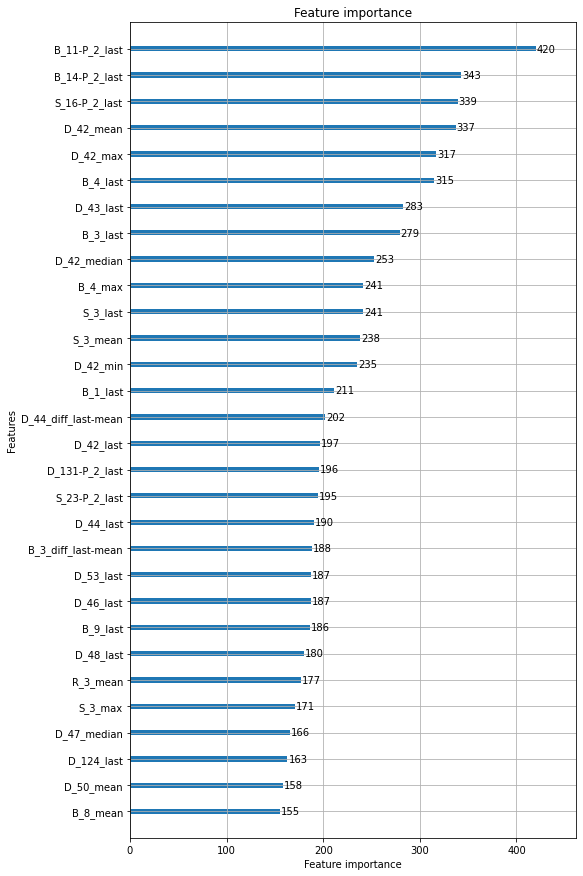

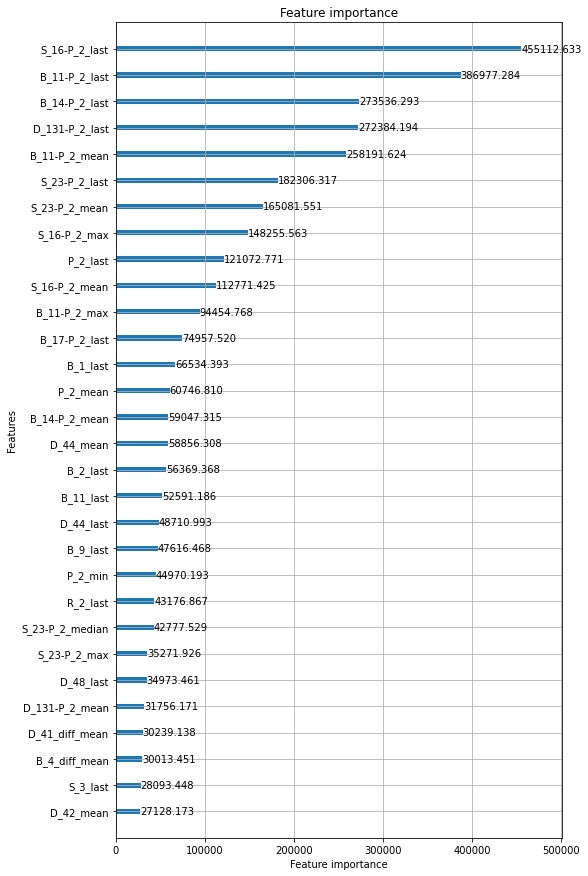

######################################## training model 2/5 ########################################
seed: 11


[50]	valid_0's amex_metric: 0.747756	valid_0's recall_at4: 0.59543	valid_0's norm_gini: 0.900082


[100]	valid_0's amex_metric: 0.758541	valid_0's recall_at4: 0.610073	valid_0's norm_gini: 0.907008


[150]	valid_0's amex_metric: 0.765796	valid_0's recall_at4: 0.62013	valid_0's norm_gini: 0.911462


[200]	valid_0's amex_metric: 0.770368	valid_0's recall_at4: 0.626988	valid_0's norm_gini: 0.913748


[250]	valid_0's amex_metric: 0.772992	valid_0's recall_at4: 0.630607	valid_0's norm_gini: 0.915376


[300]	valid_0's amex_metric: 0.775651	valid_0's recall_at4: 0.63452	valid_0's norm_gini: 0.916782


[350]	valid_0's amex_metric: 0.778617	valid_0's recall_at4: 0.638896	valid_0's norm_gini: 0.918339


[400]	valid_0's amex_metric: 0.780077	valid_0's recall_at4: 0.641	valid_0's norm_gini: 0.919154


[450]	valid_0's amex_metric: 0.781392	valid_0's recall_at4: 0.642935	valid_0's norm_gini: 0.919849


[500]	valid_0's amex_metric: 0.782361	valid_0's recall_at4: 0.644324	valid_0's norm_gini: 0.920399


[550]	valid_0's amex_metric: 0.783564	valid_0's recall_at4: 0.646259	valid_0's norm_gini: 0.920868


[600]	valid_0's amex_metric: 0.784277	valid_0's recall_at4: 0.647185	valid_0's norm_gini: 0.921369


[650]	valid_0's amex_metric: 0.78529	valid_0's recall_at4: 0.648784	valid_0's norm_gini: 0.921795


[700]	valid_0's amex_metric: 0.785755	valid_0's recall_at4: 0.649415	valid_0's norm_gini: 0.922095


[750]	valid_0's amex_metric: 0.786074	valid_0's recall_at4: 0.649794	valid_0's norm_gini: 0.922353


[800]	valid_0's amex_metric: 0.786769	valid_0's recall_at4: 0.650888	valid_0's norm_gini: 0.92265


[850]	valid_0's amex_metric: 0.786788	valid_0's recall_at4: 0.65072	valid_0's norm_gini: 0.922856


[900]	valid_0's amex_metric: 0.786855	valid_0's recall_at4: 0.650677	valid_0's norm_gini: 0.923033


[950]	valid_0's amex_metric: 0.787908	valid_0's recall_at4: 0.652571	valid_0's norm_gini: 0.923246


[1000]	valid_0's amex_metric: 0.788246	valid_0's recall_at4: 0.653034	valid_0's norm_gini: 0.923459


[1050]	valid_0's amex_metric: 0.788815	valid_0's recall_at4: 0.654002	valid_0's norm_gini: 0.923629


[1100]	valid_0's amex_metric: 0.78846	valid_0's recall_at4: 0.65316	valid_0's norm_gini: 0.92376


[1150]	valid_0's amex_metric: 0.78896	valid_0's recall_at4: 0.654044	valid_0's norm_gini: 0.923877


[1200]	valid_0's amex_metric: 0.788975	valid_0's recall_at4: 0.653959	valid_0's norm_gini: 0.92399


[1250]	valid_0's amex_metric: 0.789335	valid_0's recall_at4: 0.654591	valid_0's norm_gini: 0.92408


[1300]	valid_0's amex_metric: 0.789487	valid_0's recall_at4: 0.654759	valid_0's norm_gini: 0.924214


[1350]	valid_0's amex_metric: 0.789967	valid_0's recall_at4: 0.655643	valid_0's norm_gini: 0.924291


[1400]	valid_0's amex_metric: 0.790087	valid_0's recall_at4: 0.655811	valid_0's norm_gini: 0.924364


[1450]	valid_0's amex_metric: 0.790393	valid_0's recall_at4: 0.656316	valid_0's norm_gini: 0.92447


[1500]	valid_0's amex_metric: 0.790518	valid_0's recall_at4: 0.656526	valid_0's norm_gini: 0.92451


[1550]	valid_0's amex_metric: 0.790101	valid_0's recall_at4: 0.655643	valid_0's norm_gini: 0.92456


[1600]	valid_0's amex_metric: 0.790562	valid_0's recall_at4: 0.656484	valid_0's norm_gini: 0.92464


[1650]	valid_0's amex_metric: 0.790826	valid_0's recall_at4: 0.656989	valid_0's norm_gini: 0.924663


[1700]	valid_0's amex_metric: 0.790862	valid_0's recall_at4: 0.656989	valid_0's norm_gini: 0.924734


[1750]	valid_0's amex_metric: 0.790714	valid_0's recall_at4: 0.656652	valid_0's norm_gini: 0.924775


[1800]	valid_0's amex_metric: 0.791141	valid_0's recall_at4: 0.657452	valid_0's norm_gini: 0.924829


[1850]	valid_0's amex_metric: 0.790952	valid_0's recall_at4: 0.657031	valid_0's norm_gini: 0.924873


[1900]	valid_0's amex_metric: 0.791396	valid_0's recall_at4: 0.657873	valid_0's norm_gini: 0.924919


[1950]	valid_0's amex_metric: 0.791612	valid_0's recall_at4: 0.658251	valid_0's norm_gini: 0.924973


[2000]	valid_0's amex_metric: 0.791934	valid_0's recall_at4: 0.658882	valid_0's norm_gini: 0.924987


[2050]	valid_0's amex_metric: 0.791989	valid_0's recall_at4: 0.658967	valid_0's norm_gini: 0.925012


[2100]	valid_0's amex_metric: 0.791807	valid_0's recall_at4: 0.658588	valid_0's norm_gini: 0.925026


[2150]	valid_0's amex_metric: 0.791891	valid_0's recall_at4: 0.658756	valid_0's norm_gini: 0.925026


[2200]	valid_0's amex_metric: 0.791871	valid_0's recall_at4: 0.658672	valid_0's norm_gini: 0.925071


[2250]	valid_0's amex_metric: 0.791784	valid_0's recall_at4: 0.658462	valid_0's norm_gini: 0.925107


[2300]	valid_0's amex_metric: 0.791479	valid_0's recall_at4: 0.657831	valid_0's norm_gini: 0.925128


[2350]	valid_0's amex_metric: 0.791869	valid_0's recall_at4: 0.658588	valid_0's norm_gini: 0.92515


[2400]	valid_0's amex_metric: 0.791587	valid_0's recall_at4: 0.657999	valid_0's norm_gini: 0.925175


[2450]	valid_0's amex_metric: 0.792021	valid_0's recall_at4: 0.65884	valid_0's norm_gini: 0.925202


[2500]	valid_0's amex_metric: 0.792385	valid_0's recall_at4: 0.659556	valid_0's norm_gini: 0.925215


[2550]	valid_0's amex_metric: 0.792161	valid_0's recall_at4: 0.659093	valid_0's norm_gini: 0.925229


[2600]	valid_0's amex_metric: 0.792584	valid_0's recall_at4: 0.659934	valid_0's norm_gini: 0.925233


[2650]	valid_0's amex_metric: 0.792387	valid_0's recall_at4: 0.659514	valid_0's norm_gini: 0.92526


[2700]	valid_0's amex_metric: 0.792901	valid_0's recall_at4: 0.660523	valid_0's norm_gini: 0.925278


[2750]	valid_0's amex_metric: 0.79272	valid_0's recall_at4: 0.660145	valid_0's norm_gini: 0.925295


[2800]	valid_0's amex_metric: 0.792322	valid_0's recall_at4: 0.659345	valid_0's norm_gini: 0.925298


[2850]	valid_0's amex_metric: 0.791889	valid_0's recall_at4: 0.658462	valid_0's norm_gini: 0.925316


[2900]	valid_0's amex_metric: 0.791788	valid_0's recall_at4: 0.658251	valid_0's norm_gini: 0.925324


[2950]	valid_0's amex_metric: 0.791796	valid_0's recall_at4: 0.658251	valid_0's norm_gini: 0.92534


[3000]	valid_0's amex_metric: 0.792228	valid_0's recall_at4: 0.659093	valid_0's norm_gini: 0.925363


[3050]	valid_0's amex_metric: 0.791747	valid_0's recall_at4: 0.658125	valid_0's norm_gini: 0.92537


[3100]	valid_0's amex_metric: 0.792347	valid_0's recall_at4: 0.659303	valid_0's norm_gini: 0.92539


[3150]	valid_0's amex_metric: 0.792306	valid_0's recall_at4: 0.659219	valid_0's norm_gini: 0.925394


[3200]	valid_0's amex_metric: 0.792182	valid_0's recall_at4: 0.658967	valid_0's norm_gini: 0.925398


[3250]	valid_0's amex_metric: 0.792672	valid_0's recall_at4: 0.659934	valid_0's norm_gini: 0.92541


[3300]	valid_0's amex_metric: 0.792764	valid_0's recall_at4: 0.660103	valid_0's norm_gini: 0.925425


[3350]	valid_0's amex_metric: 0.792259	valid_0's recall_at4: 0.659093	valid_0's norm_gini: 0.925425


[3400]	valid_0's amex_metric: 0.792595	valid_0's recall_at4: 0.659766	valid_0's norm_gini: 0.925423


[3450]	valid_0's amex_metric: 0.792456	valid_0's recall_at4: 0.659472	valid_0's norm_gini: 0.92544


[3500]	valid_0's amex_metric: 0.792428	valid_0's recall_at4: 0.659429	valid_0's norm_gini: 0.925427


[3550]	valid_0's amex_metric: 0.792985	valid_0's recall_at4: 0.660523	valid_0's norm_gini: 0.925447


[3600]	valid_0's amex_metric: 0.792972	valid_0's recall_at4: 0.660481	valid_0's norm_gini: 0.925462


[3650]	valid_0's amex_metric: 0.792965	valid_0's recall_at4: 0.660439	valid_0's norm_gini: 0.92549


[3700]	valid_0's amex_metric: 0.793262	valid_0's recall_at4: 0.661028	valid_0's norm_gini: 0.925495


[3750]	valid_0's amex_metric: 0.792948	valid_0's recall_at4: 0.660397	valid_0's norm_gini: 0.925499


[3800]	valid_0's amex_metric: 0.792936	valid_0's recall_at4: 0.660355	valid_0's norm_gini: 0.925517


[3850]	valid_0's amex_metric: 0.792298	valid_0's recall_at4: 0.659093	valid_0's norm_gini: 0.925503


[3900]	valid_0's amex_metric: 0.79234	valid_0's recall_at4: 0.659177	valid_0's norm_gini: 0.925503


[3950]	valid_0's amex_metric: 0.792765	valid_0's recall_at4: 0.660019	valid_0's norm_gini: 0.925511


[4000]	valid_0's amex_metric: 0.792347	valid_0's recall_at4: 0.659177	valid_0's norm_gini: 0.925517


[4050]	valid_0's amex_metric: 0.792312	valid_0's recall_at4: 0.659093	valid_0's norm_gini: 0.925532


[4100]	valid_0's amex_metric: 0.792675	valid_0's recall_at4: 0.659808	valid_0's norm_gini: 0.925543


[4150]	valid_0's amex_metric: 0.792742	valid_0's recall_at4: 0.659934	valid_0's norm_gini: 0.925549


[4200]	valid_0's amex_metric: 0.792619	valid_0's recall_at4: 0.659682	valid_0's norm_gini: 0.925555


[4250]	valid_0's amex_metric: 0.792412	valid_0's recall_at4: 0.659261	valid_0's norm_gini: 0.925563


[4300]	valid_0's amex_metric: 0.792938	valid_0's recall_at4: 0.660313	valid_0's norm_gini: 0.925563


[4350]	valid_0's amex_metric: 0.792683	valid_0's recall_at4: 0.659808	valid_0's norm_gini: 0.925557


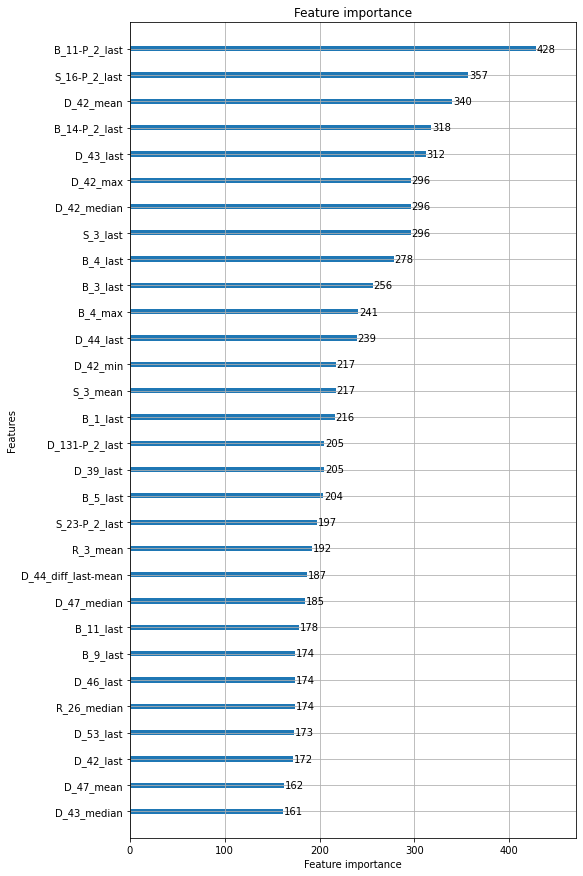

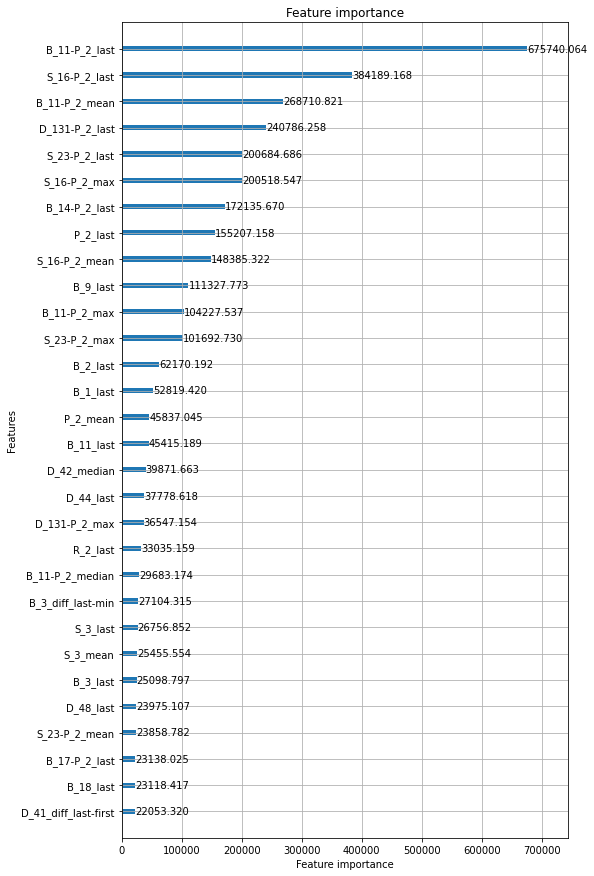

######################################## training model 3/5 ########################################
seed: 12


[50]	valid_0's amex_metric: 0.751932	valid_0's recall_at4: 0.603088	valid_0's norm_gini: 0.900776


[100]	valid_0's amex_metric: 0.764323	valid_0's recall_at4: 0.622107	valid_0's norm_gini: 0.906538


[150]	valid_0's amex_metric: 0.771623	valid_0's recall_at4: 0.632416	valid_0's norm_gini: 0.910831


[200]	valid_0's amex_metric: 0.775816	valid_0's recall_at4: 0.637634	valid_0's norm_gini: 0.913999


[250]	valid_0's amex_metric: 0.779401	valid_0's recall_at4: 0.642725	valid_0's norm_gini: 0.916077


[300]	valid_0's amex_metric: 0.783787	valid_0's recall_at4: 0.649583	valid_0's norm_gini: 0.917991


[350]	valid_0's amex_metric: 0.784834	valid_0's recall_at4: 0.651056	valid_0's norm_gini: 0.918612


[400]	valid_0's amex_metric: 0.786678	valid_0's recall_at4: 0.654044	valid_0's norm_gini: 0.919312


[450]	valid_0's amex_metric: 0.788233	valid_0's recall_at4: 0.656358	valid_0's norm_gini: 0.920109


[500]	valid_0's amex_metric: 0.790236	valid_0's recall_at4: 0.659556	valid_0's norm_gini: 0.920917


[550]	valid_0's amex_metric: 0.790989	valid_0's recall_at4: 0.660523	valid_0's norm_gini: 0.921455


[600]	valid_0's amex_metric: 0.792422	valid_0's recall_at4: 0.662922	valid_0's norm_gini: 0.921923


[650]	valid_0's amex_metric: 0.792791	valid_0's recall_at4: 0.663343	valid_0's norm_gini: 0.922239


[700]	valid_0's amex_metric: 0.792651	valid_0's recall_at4: 0.662838	valid_0's norm_gini: 0.922464


[750]	valid_0's amex_metric: 0.793223	valid_0's recall_at4: 0.663721	valid_0's norm_gini: 0.922725


[800]	valid_0's amex_metric: 0.794408	valid_0's recall_at4: 0.665825	valid_0's norm_gini: 0.92299


[850]	valid_0's amex_metric: 0.794434	valid_0's recall_at4: 0.665657	valid_0's norm_gini: 0.923212


[900]	valid_0's amex_metric: 0.795392	valid_0's recall_at4: 0.667382	valid_0's norm_gini: 0.923402


[950]	valid_0's amex_metric: 0.795529	valid_0's recall_at4: 0.667508	valid_0's norm_gini: 0.92355


[1000]	valid_0's amex_metric: 0.796389	valid_0's recall_at4: 0.669107	valid_0's norm_gini: 0.923671


[1050]	valid_0's amex_metric: 0.796059	valid_0's recall_at4: 0.66835	valid_0's norm_gini: 0.923769


[1100]	valid_0's amex_metric: 0.796407	valid_0's recall_at4: 0.668939	valid_0's norm_gini: 0.923876


[1150]	valid_0's amex_metric: 0.796655	valid_0's recall_at4: 0.669275	valid_0's norm_gini: 0.924035


[1200]	valid_0's amex_metric: 0.797233	valid_0's recall_at4: 0.670285	valid_0's norm_gini: 0.924181


[1250]	valid_0's amex_metric: 0.797422	valid_0's recall_at4: 0.670538	valid_0's norm_gini: 0.924306


[1300]	valid_0's amex_metric: 0.797022	valid_0's recall_at4: 0.669654	valid_0's norm_gini: 0.92439


[1350]	valid_0's amex_metric: 0.796894	valid_0's recall_at4: 0.66936	valid_0's norm_gini: 0.924429


[1400]	valid_0's amex_metric: 0.796854	valid_0's recall_at4: 0.669191	valid_0's norm_gini: 0.924517


[1450]	valid_0's amex_metric: 0.797173	valid_0's recall_at4: 0.669738	valid_0's norm_gini: 0.924608


[1500]	valid_0's amex_metric: 0.796961	valid_0's recall_at4: 0.669233	valid_0's norm_gini: 0.924689


[1550]	valid_0's amex_metric: 0.797154	valid_0's recall_at4: 0.66957	valid_0's norm_gini: 0.924737


[1600]	valid_0's amex_metric: 0.797591	valid_0's recall_at4: 0.670369	valid_0's norm_gini: 0.924813


[1650]	valid_0's amex_metric: 0.797379	valid_0's recall_at4: 0.669907	valid_0's norm_gini: 0.924852


[1700]	valid_0's amex_metric: 0.796936	valid_0's recall_at4: 0.668981	valid_0's norm_gini: 0.924892


[1750]	valid_0's amex_metric: 0.797474	valid_0's recall_at4: 0.669991	valid_0's norm_gini: 0.924957


[1800]	valid_0's amex_metric: 0.797259	valid_0's recall_at4: 0.669528	valid_0's norm_gini: 0.924991


[1850]	valid_0's amex_metric: 0.797739	valid_0's recall_at4: 0.670454	valid_0's norm_gini: 0.925025


[1900]	valid_0's amex_metric: 0.79736	valid_0's recall_at4: 0.669654	valid_0's norm_gini: 0.925066


[1950]	valid_0's amex_metric: 0.797128	valid_0's recall_at4: 0.669191	valid_0's norm_gini: 0.925065


[2000]	valid_0's amex_metric: 0.797169	valid_0's recall_at4: 0.669233	valid_0's norm_gini: 0.925104


[2050]	valid_0's amex_metric: 0.796954	valid_0's recall_at4: 0.66877	valid_0's norm_gini: 0.925138


[2100]	valid_0's amex_metric: 0.796939	valid_0's recall_at4: 0.668728	valid_0's norm_gini: 0.92515


[2150]	valid_0's amex_metric: 0.797205	valid_0's recall_at4: 0.669233	valid_0's norm_gini: 0.925176


[2200]	valid_0's amex_metric: 0.797191	valid_0's recall_at4: 0.669191	valid_0's norm_gini: 0.925191


[2250]	valid_0's amex_metric: 0.797123	valid_0's recall_at4: 0.669023	valid_0's norm_gini: 0.925224


[2300]	valid_0's amex_metric: 0.797053	valid_0's recall_at4: 0.668855	valid_0's norm_gini: 0.92525


[2350]	valid_0's amex_metric: 0.797443	valid_0's recall_at4: 0.669612	valid_0's norm_gini: 0.925274


[2400]	valid_0's amex_metric: 0.798093	valid_0's recall_at4: 0.670874	valid_0's norm_gini: 0.925311


[2450]	valid_0's amex_metric: 0.797845	valid_0's recall_at4: 0.670327	valid_0's norm_gini: 0.925362


[2500]	valid_0's amex_metric: 0.797978	valid_0's recall_at4: 0.67058	valid_0's norm_gini: 0.925376


[2550]	valid_0's amex_metric: 0.798287	valid_0's recall_at4: 0.671169	valid_0's norm_gini: 0.925405


[2600]	valid_0's amex_metric: 0.79822	valid_0's recall_at4: 0.671001	valid_0's norm_gini: 0.925439


[2650]	valid_0's amex_metric: 0.798165	valid_0's recall_at4: 0.670874	valid_0's norm_gini: 0.925456


[2700]	valid_0's amex_metric: 0.798478	valid_0's recall_at4: 0.671506	valid_0's norm_gini: 0.925451


[2750]	valid_0's amex_metric: 0.798619	valid_0's recall_at4: 0.671758	valid_0's norm_gini: 0.92548


[2800]	valid_0's amex_metric: 0.799124	valid_0's recall_at4: 0.672726	valid_0's norm_gini: 0.925522


[2850]	valid_0's amex_metric: 0.798525	valid_0's recall_at4: 0.671506	valid_0's norm_gini: 0.925544


[2900]	valid_0's amex_metric: 0.798741	valid_0's recall_at4: 0.671926	valid_0's norm_gini: 0.925555


[2950]	valid_0's amex_metric: 0.799	valid_0's recall_at4: 0.672431	valid_0's norm_gini: 0.925568


[3000]	valid_0's amex_metric: 0.798879	valid_0's recall_at4: 0.672179	valid_0's norm_gini: 0.92558


[3050]	valid_0's amex_metric: 0.798718	valid_0's recall_at4: 0.671842	valid_0's norm_gini: 0.925593


[3100]	valid_0's amex_metric: 0.798785	valid_0's recall_at4: 0.671968	valid_0's norm_gini: 0.925602


[3150]	valid_0's amex_metric: 0.798658	valid_0's recall_at4: 0.671716	valid_0's norm_gini: 0.9256


[3200]	valid_0's amex_metric: 0.79881	valid_0's recall_at4: 0.67201	valid_0's norm_gini: 0.925609


[3250]	valid_0's amex_metric: 0.798835	valid_0's recall_at4: 0.672053	valid_0's norm_gini: 0.925617


[3300]	valid_0's amex_metric: 0.798737	valid_0's recall_at4: 0.671842	valid_0's norm_gini: 0.925631


[3350]	valid_0's amex_metric: 0.799533	valid_0's recall_at4: 0.673441	valid_0's norm_gini: 0.925625


[3400]	valid_0's amex_metric: 0.799919	valid_0's recall_at4: 0.674198	valid_0's norm_gini: 0.92564


[3450]	valid_0's amex_metric: 0.79972	valid_0's recall_at4: 0.67382	valid_0's norm_gini: 0.92562


[3500]	valid_0's amex_metric: 0.799887	valid_0's recall_at4: 0.674156	valid_0's norm_gini: 0.925619


[3550]	valid_0's amex_metric: 0.800307	valid_0's recall_at4: 0.674998	valid_0's norm_gini: 0.925617


[3600]	valid_0's amex_metric: 0.799979	valid_0's recall_at4: 0.674325	valid_0's norm_gini: 0.925634


[3650]	valid_0's amex_metric: 0.799927	valid_0's recall_at4: 0.674241	valid_0's norm_gini: 0.925613


[3700]	valid_0's amex_metric: 0.799795	valid_0's recall_at4: 0.673946	valid_0's norm_gini: 0.925645


[3750]	valid_0's amex_metric: 0.800047	valid_0's recall_at4: 0.674451	valid_0's norm_gini: 0.925644


[3800]	valid_0's amex_metric: 0.79961	valid_0's recall_at4: 0.673567	valid_0's norm_gini: 0.925652


[3850]	valid_0's amex_metric: 0.799248	valid_0's recall_at4: 0.672852	valid_0's norm_gini: 0.925645


[3900]	valid_0's amex_metric: 0.799488	valid_0's recall_at4: 0.673315	valid_0's norm_gini: 0.925661


[3950]	valid_0's amex_metric: 0.79934	valid_0's recall_at4: 0.67302	valid_0's norm_gini: 0.925659


[4000]	valid_0's amex_metric: 0.79946	valid_0's recall_at4: 0.673273	valid_0's norm_gini: 0.925647


[4050]	valid_0's amex_metric: 0.799336	valid_0's recall_at4: 0.67302	valid_0's norm_gini: 0.925651


[4100]	valid_0's amex_metric: 0.799603	valid_0's recall_at4: 0.673567	valid_0's norm_gini: 0.925639


[4150]	valid_0's amex_metric: 0.79952	valid_0's recall_at4: 0.673399	valid_0's norm_gini: 0.925641


[4200]	valid_0's amex_metric: 0.799604	valid_0's recall_at4: 0.673567	valid_0's norm_gini: 0.92564


[4250]	valid_0's amex_metric: 0.799352	valid_0's recall_at4: 0.673062	valid_0's norm_gini: 0.925642


[4300]	valid_0's amex_metric: 0.799317	valid_0's recall_at4: 0.672978	valid_0's norm_gini: 0.925656


[4350]	valid_0's amex_metric: 0.798958	valid_0's recall_at4: 0.672263	valid_0's norm_gini: 0.925653


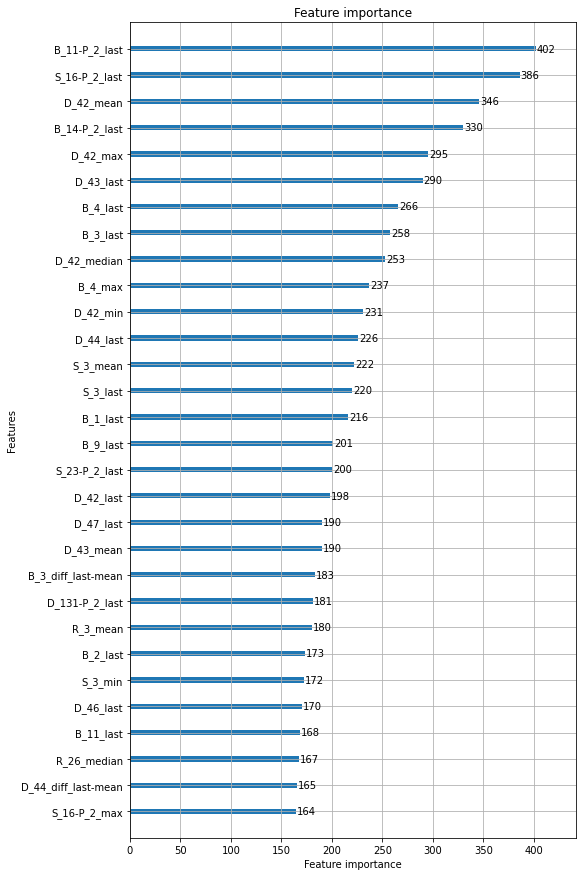

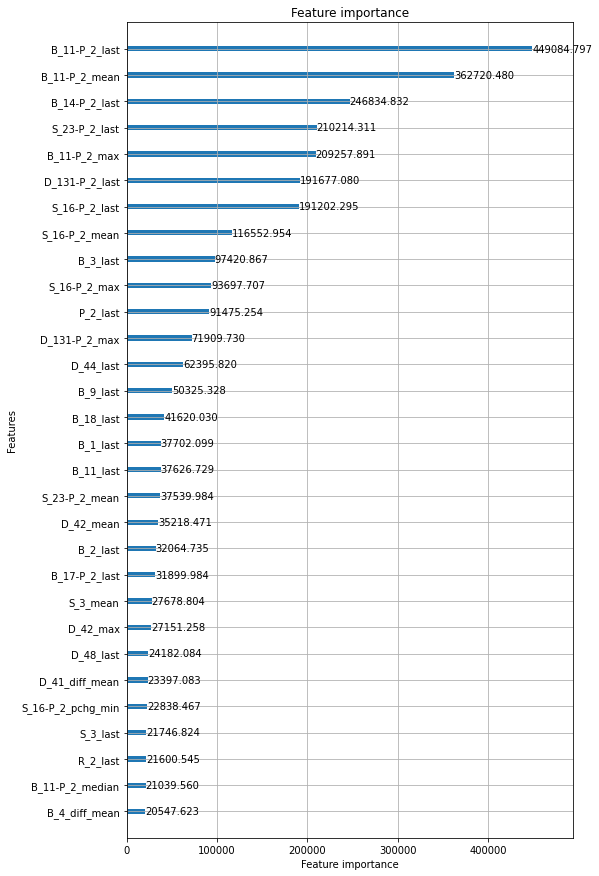

######################################## training model 4/5 ########################################
seed: 13


[50]	valid_0's amex_metric: 0.755817	valid_0's recall_at4: 0.608542	valid_0's norm_gini: 0.903093


[100]	valid_0's amex_metric: 0.766416	valid_0's recall_at4: 0.622933	valid_0's norm_gini: 0.909898


[150]	valid_0's amex_metric: 0.77379	valid_0's recall_at4: 0.633789	valid_0's norm_gini: 0.91379


[200]	valid_0's amex_metric: 0.778458	valid_0's recall_at4: 0.640269	valid_0's norm_gini: 0.916647


[250]	valid_0's amex_metric: 0.780935	valid_0's recall_at4: 0.643888	valid_0's norm_gini: 0.917983


[300]	valid_0's amex_metric: 0.783555	valid_0's recall_at4: 0.647801	valid_0's norm_gini: 0.919308


[350]	valid_0's amex_metric: 0.78559	valid_0's recall_at4: 0.65121	valid_0's norm_gini: 0.919969


[400]	valid_0's amex_metric: 0.787322	valid_0's recall_at4: 0.653735	valid_0's norm_gini: 0.92091


[450]	valid_0's amex_metric: 0.789041	valid_0's recall_at4: 0.656301	valid_0's norm_gini: 0.92178


[500]	valid_0's amex_metric: 0.790707	valid_0's recall_at4: 0.658952	valid_0's norm_gini: 0.922462


[550]	valid_0's amex_metric: 0.791747	valid_0's recall_at4: 0.660593	valid_0's norm_gini: 0.922901


[600]	valid_0's amex_metric: 0.792603	valid_0's recall_at4: 0.66194	valid_0's norm_gini: 0.923266


[650]	valid_0's amex_metric: 0.792967	valid_0's recall_at4: 0.66215	valid_0's norm_gini: 0.923783


[700]	valid_0's amex_metric: 0.794239	valid_0's recall_at4: 0.66417	valid_0's norm_gini: 0.924307


[750]	valid_0's amex_metric: 0.794974	valid_0's recall_at4: 0.665306	valid_0's norm_gini: 0.924643


[800]	valid_0's amex_metric: 0.795965	valid_0's recall_at4: 0.666989	valid_0's norm_gini: 0.924942


[850]	valid_0's amex_metric: 0.796732	valid_0's recall_at4: 0.66821	valid_0's norm_gini: 0.925255


[900]	valid_0's amex_metric: 0.797349	valid_0's recall_at4: 0.669219	valid_0's norm_gini: 0.925479


[950]	valid_0's amex_metric: 0.798494	valid_0's recall_at4: 0.671323	valid_0's norm_gini: 0.925665


[1000]	valid_0's amex_metric: 0.798608	valid_0's recall_at4: 0.671365	valid_0's norm_gini: 0.925851


[1050]	valid_0's amex_metric: 0.798462	valid_0's recall_at4: 0.670945	valid_0's norm_gini: 0.925979


[1100]	valid_0's amex_metric: 0.798371	valid_0's recall_at4: 0.670608	valid_0's norm_gini: 0.926134


[1150]	valid_0's amex_metric: 0.798596	valid_0's recall_at4: 0.670903	valid_0's norm_gini: 0.92629


[1200]	valid_0's amex_metric: 0.798623	valid_0's recall_at4: 0.670861	valid_0's norm_gini: 0.926385


[1250]	valid_0's amex_metric: 0.79857	valid_0's recall_at4: 0.67065	valid_0's norm_gini: 0.926491


[1300]	valid_0's amex_metric: 0.798771	valid_0's recall_at4: 0.670945	valid_0's norm_gini: 0.926598


[1350]	valid_0's amex_metric: 0.799096	valid_0's recall_at4: 0.671492	valid_0's norm_gini: 0.926701


[1400]	valid_0's amex_metric: 0.799153	valid_0's recall_at4: 0.671492	valid_0's norm_gini: 0.926814


[1450]	valid_0's amex_metric: 0.799309	valid_0's recall_at4: 0.671744	valid_0's norm_gini: 0.926874


[1500]	valid_0's amex_metric: 0.800028	valid_0's recall_at4: 0.673091	valid_0's norm_gini: 0.926965


[1550]	valid_0's amex_metric: 0.800401	valid_0's recall_at4: 0.673722	valid_0's norm_gini: 0.92708


[1600]	valid_0's amex_metric: 0.800558	valid_0's recall_at4: 0.673932	valid_0's norm_gini: 0.927183


[1650]	valid_0's amex_metric: 0.801177	valid_0's recall_at4: 0.67511	valid_0's norm_gini: 0.927243


[1700]	valid_0's amex_metric: 0.801089	valid_0's recall_at4: 0.674858	valid_0's norm_gini: 0.927321


[1750]	valid_0's amex_metric: 0.80145	valid_0's recall_at4: 0.675531	valid_0's norm_gini: 0.92737


[1800]	valid_0's amex_metric: 0.801396	valid_0's recall_at4: 0.675363	valid_0's norm_gini: 0.927429


[1850]	valid_0's amex_metric: 0.801295	valid_0's recall_at4: 0.67511	valid_0's norm_gini: 0.92748


[1900]	valid_0's amex_metric: 0.801201	valid_0's recall_at4: 0.674858	valid_0's norm_gini: 0.927543


[1950]	valid_0's amex_metric: 0.801469	valid_0's recall_at4: 0.675363	valid_0's norm_gini: 0.927574


[2000]	valid_0's amex_metric: 0.801598	valid_0's recall_at4: 0.675573	valid_0's norm_gini: 0.927622


[2050]	valid_0's amex_metric: 0.802181	valid_0's recall_at4: 0.676709	valid_0's norm_gini: 0.927652


[2100]	valid_0's amex_metric: 0.802054	valid_0's recall_at4: 0.676415	valid_0's norm_gini: 0.927694


[2150]	valid_0's amex_metric: 0.802091	valid_0's recall_at4: 0.676457	valid_0's norm_gini: 0.927726


[2200]	valid_0's amex_metric: 0.80185	valid_0's recall_at4: 0.675952	valid_0's norm_gini: 0.927748


[2250]	valid_0's amex_metric: 0.80222	valid_0's recall_at4: 0.676667	valid_0's norm_gini: 0.927773


[2300]	valid_0's amex_metric: 0.801805	valid_0's recall_at4: 0.675826	valid_0's norm_gini: 0.927783


[2350]	valid_0's amex_metric: 0.801841	valid_0's recall_at4: 0.675868	valid_0's norm_gini: 0.927814


[2400]	valid_0's amex_metric: 0.801791	valid_0's recall_at4: 0.675742	valid_0's norm_gini: 0.927841


[2450]	valid_0's amex_metric: 0.802376	valid_0's recall_at4: 0.676878	valid_0's norm_gini: 0.927874


[2500]	valid_0's amex_metric: 0.802236	valid_0's recall_at4: 0.676583	valid_0's norm_gini: 0.927888


[2550]	valid_0's amex_metric: 0.802089	valid_0's recall_at4: 0.676289	valid_0's norm_gini: 0.927889


[2600]	valid_0's amex_metric: 0.80235	valid_0's recall_at4: 0.676794	valid_0's norm_gini: 0.927907


[2650]	valid_0's amex_metric: 0.802577	valid_0's recall_at4: 0.677214	valid_0's norm_gini: 0.92794


[2700]	valid_0's amex_metric: 0.802572	valid_0's recall_at4: 0.677172	valid_0's norm_gini: 0.927972


[2750]	valid_0's amex_metric: 0.802302	valid_0's recall_at4: 0.676625	valid_0's norm_gini: 0.927978


[2800]	valid_0's amex_metric: 0.802359	valid_0's recall_at4: 0.676709	valid_0's norm_gini: 0.928008


[2850]	valid_0's amex_metric: 0.802354	valid_0's recall_at4: 0.676709	valid_0's norm_gini: 0.927999


[2900]	valid_0's amex_metric: 0.802019	valid_0's recall_at4: 0.676036	valid_0's norm_gini: 0.928002


[2950]	valid_0's amex_metric: 0.802098	valid_0's recall_at4: 0.676162	valid_0's norm_gini: 0.928034


[3000]	valid_0's amex_metric: 0.802864	valid_0's recall_at4: 0.677677	valid_0's norm_gini: 0.928051


[3050]	valid_0's amex_metric: 0.802666	valid_0's recall_at4: 0.677256	valid_0's norm_gini: 0.928076


[3100]	valid_0's amex_metric: 0.802695	valid_0's recall_at4: 0.677299	valid_0's norm_gini: 0.928092


[3150]	valid_0's amex_metric: 0.802392	valid_0's recall_at4: 0.676667	valid_0's norm_gini: 0.928116


[3200]	valid_0's amex_metric: 0.802628	valid_0's recall_at4: 0.67713	valid_0's norm_gini: 0.928127


[3250]	valid_0's amex_metric: 0.80253	valid_0's recall_at4: 0.67692	valid_0's norm_gini: 0.928141


[3300]	valid_0's amex_metric: 0.80246	valid_0's recall_at4: 0.676794	valid_0's norm_gini: 0.928127


[3350]	valid_0's amex_metric: 0.802051	valid_0's recall_at4: 0.675952	valid_0's norm_gini: 0.928149


[3400]	valid_0's amex_metric: 0.802166	valid_0's recall_at4: 0.676162	valid_0's norm_gini: 0.928169


[3450]	valid_0's amex_metric: 0.801999	valid_0's recall_at4: 0.675826	valid_0's norm_gini: 0.928172


[3500]	valid_0's amex_metric: 0.802082	valid_0's recall_at4: 0.675994	valid_0's norm_gini: 0.928171


[3550]	valid_0's amex_metric: 0.802063	valid_0's recall_at4: 0.675952	valid_0's norm_gini: 0.928174


[3600]	valid_0's amex_metric: 0.80238	valid_0's recall_at4: 0.676583	valid_0's norm_gini: 0.928178


[3650]	valid_0's amex_metric: 0.802513	valid_0's recall_at4: 0.676836	valid_0's norm_gini: 0.928191


[3700]	valid_0's amex_metric: 0.801926	valid_0's recall_at4: 0.675657	valid_0's norm_gini: 0.928195


[3750]	valid_0's amex_metric: 0.802015	valid_0's recall_at4: 0.675826	valid_0's norm_gini: 0.928204


[3800]	valid_0's amex_metric: 0.801958	valid_0's recall_at4: 0.6757	valid_0's norm_gini: 0.928217


[3850]	valid_0's amex_metric: 0.802142	valid_0's recall_at4: 0.676036	valid_0's norm_gini: 0.928247


[3900]	valid_0's amex_metric: 0.802161	valid_0's recall_at4: 0.676078	valid_0's norm_gini: 0.928244


[3950]	valid_0's amex_metric: 0.802438	valid_0's recall_at4: 0.676625	valid_0's norm_gini: 0.928251


[4000]	valid_0's amex_metric: 0.801707	valid_0's recall_at4: 0.675153	valid_0's norm_gini: 0.928261


[4050]	valid_0's amex_metric: 0.802046	valid_0's recall_at4: 0.675826	valid_0's norm_gini: 0.928267


[4100]	valid_0's amex_metric: 0.801892	valid_0's recall_at4: 0.675489	valid_0's norm_gini: 0.928295


[4150]	valid_0's amex_metric: 0.802459	valid_0's recall_at4: 0.676625	valid_0's norm_gini: 0.928292


[4200]	valid_0's amex_metric: 0.80222	valid_0's recall_at4: 0.67612	valid_0's norm_gini: 0.92832


[4250]	valid_0's amex_metric: 0.801718	valid_0's recall_at4: 0.67511	valid_0's norm_gini: 0.928326


[4300]	valid_0's amex_metric: 0.802138	valid_0's recall_at4: 0.675952	valid_0's norm_gini: 0.928323


[4350]	valid_0's amex_metric: 0.801879	valid_0's recall_at4: 0.675447	valid_0's norm_gini: 0.92831


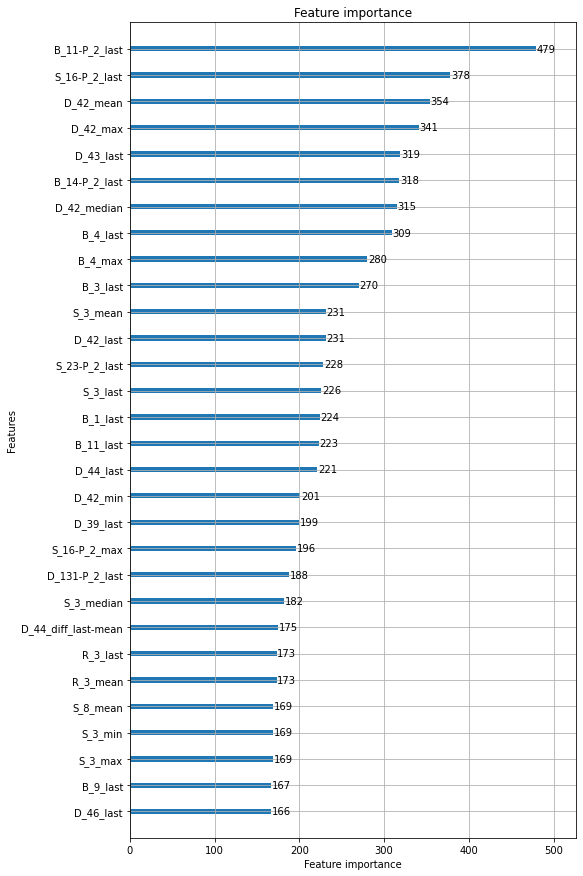

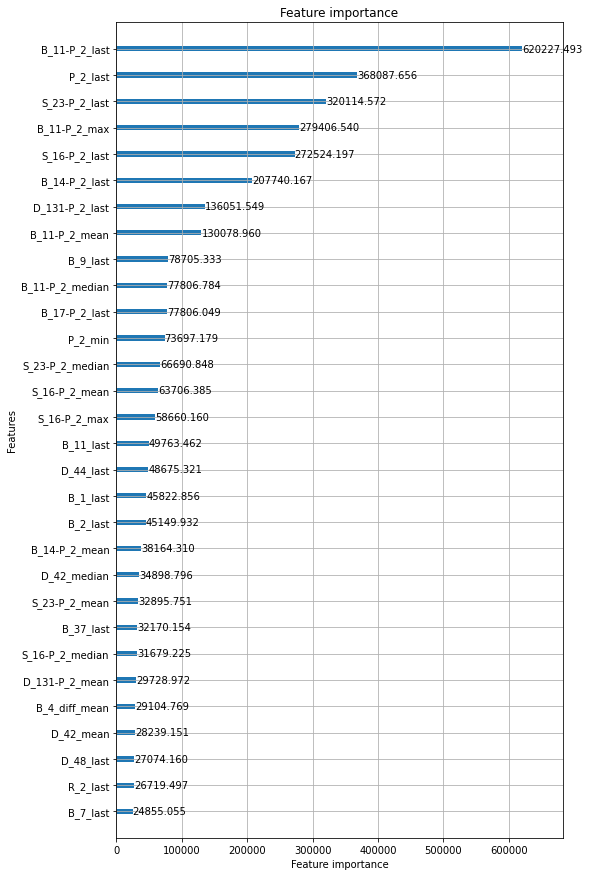

######################################## training model 5/5 ########################################
seed: 14


[50]	valid_0's amex_metric: 0.750496	valid_0's recall_at4: 0.602146	valid_0's norm_gini: 0.898846


[100]	valid_0's amex_metric: 0.763844	valid_0's recall_at4: 0.621965	valid_0's norm_gini: 0.905724


[150]	valid_0's amex_metric: 0.767348	valid_0's recall_at4: 0.626173	valid_0's norm_gini: 0.908523


[200]	valid_0's amex_metric: 0.770667	valid_0's recall_at4: 0.629623	valid_0's norm_gini: 0.91171


[250]	valid_0's amex_metric: 0.775124	valid_0's recall_at4: 0.636356	valid_0's norm_gini: 0.913892


[300]	valid_0's amex_metric: 0.778131	valid_0's recall_at4: 0.640732	valid_0's norm_gini: 0.915529


[350]	valid_0's amex_metric: 0.781774	valid_0's recall_at4: 0.646497	valid_0's norm_gini: 0.91705


[400]	valid_0's amex_metric: 0.78344	valid_0's recall_at4: 0.648685	valid_0's norm_gini: 0.918196


[450]	valid_0's amex_metric: 0.784916	valid_0's recall_at4: 0.650957	valid_0's norm_gini: 0.918875


[500]	valid_0's amex_metric: 0.785803	valid_0's recall_at4: 0.652262	valid_0's norm_gini: 0.919345


[550]	valid_0's amex_metric: 0.786852	valid_0's recall_at4: 0.653735	valid_0's norm_gini: 0.91997


[600]	valid_0's amex_metric: 0.787224	valid_0's recall_at4: 0.654071	valid_0's norm_gini: 0.920377


[650]	valid_0's amex_metric: 0.787552	valid_0's recall_at4: 0.654324	valid_0's norm_gini: 0.920781


[700]	valid_0's amex_metric: 0.788832	valid_0's recall_at4: 0.65647	valid_0's norm_gini: 0.921195


[750]	valid_0's amex_metric: 0.788572	valid_0's recall_at4: 0.655754	valid_0's norm_gini: 0.921391


[800]	valid_0's amex_metric: 0.78939	valid_0's recall_at4: 0.657101	valid_0's norm_gini: 0.921679


[850]	valid_0's amex_metric: 0.789138	valid_0's recall_at4: 0.656343	valid_0's norm_gini: 0.921933


[900]	valid_0's amex_metric: 0.78867	valid_0's recall_at4: 0.655165	valid_0's norm_gini: 0.922175


[950]	valid_0's amex_metric: 0.78931	valid_0's recall_at4: 0.656301	valid_0's norm_gini: 0.922319


[1000]	valid_0's amex_metric: 0.789686	valid_0's recall_at4: 0.656848	valid_0's norm_gini: 0.922524


[1050]	valid_0's amex_metric: 0.790834	valid_0's recall_at4: 0.658994	valid_0's norm_gini: 0.922673


[1100]	valid_0's amex_metric: 0.791026	valid_0's recall_at4: 0.659289	valid_0's norm_gini: 0.922763


[1150]	valid_0's amex_metric: 0.790989	valid_0's recall_at4: 0.659121	valid_0's norm_gini: 0.922858


[1200]	valid_0's amex_metric: 0.791064	valid_0's recall_at4: 0.659205	valid_0's norm_gini: 0.922923


[1250]	valid_0's amex_metric: 0.791497	valid_0's recall_at4: 0.659962	valid_0's norm_gini: 0.923032


[1300]	valid_0's amex_metric: 0.791889	valid_0's recall_at4: 0.660635	valid_0's norm_gini: 0.923142


[1350]	valid_0's amex_metric: 0.791267	valid_0's recall_at4: 0.659331	valid_0's norm_gini: 0.923204


[1400]	valid_0's amex_metric: 0.791614	valid_0's recall_at4: 0.659962	valid_0's norm_gini: 0.923265


[1450]	valid_0's amex_metric: 0.791877	valid_0's recall_at4: 0.660425	valid_0's norm_gini: 0.92333


[1500]	valid_0's amex_metric: 0.79168	valid_0's recall_at4: 0.659962	valid_0's norm_gini: 0.923398


[1550]	valid_0's amex_metric: 0.792131	valid_0's recall_at4: 0.660804	valid_0's norm_gini: 0.923459


[1600]	valid_0's amex_metric: 0.792323	valid_0's recall_at4: 0.661056	valid_0's norm_gini: 0.923591


[1650]	valid_0's amex_metric: 0.791851	valid_0's recall_at4: 0.660046	valid_0's norm_gini: 0.923655


[1700]	valid_0's amex_metric: 0.791827	valid_0's recall_at4: 0.659962	valid_0's norm_gini: 0.923692


[1750]	valid_0's amex_metric: 0.792283	valid_0's recall_at4: 0.660804	valid_0's norm_gini: 0.923761


[1800]	valid_0's amex_metric: 0.792432	valid_0's recall_at4: 0.661056	valid_0's norm_gini: 0.923808


[1850]	valid_0's amex_metric: 0.792748	valid_0's recall_at4: 0.661645	valid_0's norm_gini: 0.92385


[1900]	valid_0's amex_metric: 0.792099	valid_0's recall_at4: 0.660299	valid_0's norm_gini: 0.923899


[1950]	valid_0's amex_metric: 0.792029	valid_0's recall_at4: 0.66013	valid_0's norm_gini: 0.923928


[2000]	valid_0's amex_metric: 0.792264	valid_0's recall_at4: 0.660551	valid_0's norm_gini: 0.923977


[2050]	valid_0's amex_metric: 0.79232	valid_0's recall_at4: 0.660635	valid_0's norm_gini: 0.924005


[2100]	valid_0's amex_metric: 0.792797	valid_0's recall_at4: 0.661561	valid_0's norm_gini: 0.924032


[2150]	valid_0's amex_metric: 0.793107	valid_0's recall_at4: 0.662108	valid_0's norm_gini: 0.924105


[2200]	valid_0's amex_metric: 0.792905	valid_0's recall_at4: 0.661645	valid_0's norm_gini: 0.924164


[2250]	valid_0's amex_metric: 0.793374	valid_0's recall_at4: 0.662529	valid_0's norm_gini: 0.924219


[2300]	valid_0's amex_metric: 0.793399	valid_0's recall_at4: 0.662571	valid_0's norm_gini: 0.924227


[2350]	valid_0's amex_metric: 0.793708	valid_0's recall_at4: 0.66316	valid_0's norm_gini: 0.924256


[2400]	valid_0's amex_metric: 0.793523	valid_0's recall_at4: 0.662781	valid_0's norm_gini: 0.924265


[2450]	valid_0's amex_metric: 0.793934	valid_0's recall_at4: 0.663581	valid_0's norm_gini: 0.924288


[2500]	valid_0's amex_metric: 0.794061	valid_0's recall_at4: 0.663833	valid_0's norm_gini: 0.924288


[2550]	valid_0's amex_metric: 0.794094	valid_0's recall_at4: 0.663875	valid_0's norm_gini: 0.924313


[2600]	valid_0's amex_metric: 0.793822	valid_0's recall_at4: 0.663328	valid_0's norm_gini: 0.924316


[2650]	valid_0's amex_metric: 0.793763	valid_0's recall_at4: 0.663202	valid_0's norm_gini: 0.924323


[2700]	valid_0's amex_metric: 0.79383	valid_0's recall_at4: 0.663328	valid_0's norm_gini: 0.924331


[2750]	valid_0's amex_metric: 0.79377	valid_0's recall_at4: 0.663202	valid_0's norm_gini: 0.924337


[2800]	valid_0's amex_metric: 0.794319	valid_0's recall_at4: 0.664296	valid_0's norm_gini: 0.924341


[2850]	valid_0's amex_metric: 0.794303	valid_0's recall_at4: 0.664254	valid_0's norm_gini: 0.924351


[2900]	valid_0's amex_metric: 0.79426	valid_0's recall_at4: 0.66417	valid_0's norm_gini: 0.92435


[2950]	valid_0's amex_metric: 0.794459	valid_0's recall_at4: 0.664549	valid_0's norm_gini: 0.92437


[3000]	valid_0's amex_metric: 0.794211	valid_0's recall_at4: 0.664044	valid_0's norm_gini: 0.924379


[3050]	valid_0's amex_metric: 0.794282	valid_0's recall_at4: 0.66417	valid_0's norm_gini: 0.924393


[3100]	valid_0's amex_metric: 0.794331	valid_0's recall_at4: 0.664254	valid_0's norm_gini: 0.924408


[3150]	valid_0's amex_metric: 0.793911	valid_0's recall_at4: 0.663413	valid_0's norm_gini: 0.92441


[3200]	valid_0's amex_metric: 0.794066	valid_0's recall_at4: 0.663749	valid_0's norm_gini: 0.924382


[3250]	valid_0's amex_metric: 0.794249	valid_0's recall_at4: 0.664086	valid_0's norm_gini: 0.924412


[3300]	valid_0's amex_metric: 0.794274	valid_0's recall_at4: 0.664128	valid_0's norm_gini: 0.924419


[3350]	valid_0's amex_metric: 0.794325	valid_0's recall_at4: 0.664212	valid_0's norm_gini: 0.924438


[3400]	valid_0's amex_metric: 0.794136	valid_0's recall_at4: 0.663833	valid_0's norm_gini: 0.924439


[3450]	valid_0's amex_metric: 0.794327	valid_0's recall_at4: 0.664212	valid_0's norm_gini: 0.924441


[3500]	valid_0's amex_metric: 0.794641	valid_0's recall_at4: 0.664843	valid_0's norm_gini: 0.924439


[3550]	valid_0's amex_metric: 0.7946	valid_0's recall_at4: 0.664759	valid_0's norm_gini: 0.92444


[3600]	valid_0's amex_metric: 0.794173	valid_0's recall_at4: 0.663918	valid_0's norm_gini: 0.924429


[3650]	valid_0's amex_metric: 0.793658	valid_0's recall_at4: 0.662866	valid_0's norm_gini: 0.924451


[3700]	valid_0's amex_metric: 0.79358	valid_0's recall_at4: 0.662697	valid_0's norm_gini: 0.924463


[3750]	valid_0's amex_metric: 0.793989	valid_0's recall_at4: 0.663497	valid_0's norm_gini: 0.924481


[3800]	valid_0's amex_metric: 0.79394	valid_0's recall_at4: 0.663413	valid_0's norm_gini: 0.924468


[3850]	valid_0's amex_metric: 0.794034	valid_0's recall_at4: 0.663623	valid_0's norm_gini: 0.924446


[3900]	valid_0's amex_metric: 0.793715	valid_0's recall_at4: 0.662992	valid_0's norm_gini: 0.924438


[3950]	valid_0's amex_metric: 0.794242	valid_0's recall_at4: 0.664044	valid_0's norm_gini: 0.924441


[4000]	valid_0's amex_metric: 0.794687	valid_0's recall_at4: 0.664927	valid_0's norm_gini: 0.924446


[4050]	valid_0's amex_metric: 0.79453	valid_0's recall_at4: 0.664633	valid_0's norm_gini: 0.924428


[4100]	valid_0's amex_metric: 0.794301	valid_0's recall_at4: 0.66417	valid_0's norm_gini: 0.924431


[4150]	valid_0's amex_metric: 0.794721	valid_0's recall_at4: 0.665012	valid_0's norm_gini: 0.924431


[4200]	valid_0's amex_metric: 0.794303	valid_0's recall_at4: 0.66417	valid_0's norm_gini: 0.924437


[4250]	valid_0's amex_metric: 0.794301	valid_0's recall_at4: 0.66417	valid_0's norm_gini: 0.924433


[4300]	valid_0's amex_metric: 0.794167	valid_0's recall_at4: 0.663918	valid_0's norm_gini: 0.924417


[4350]	valid_0's amex_metric: 0.794144	valid_0's recall_at4: 0.663875	valid_0's norm_gini: 0.924413


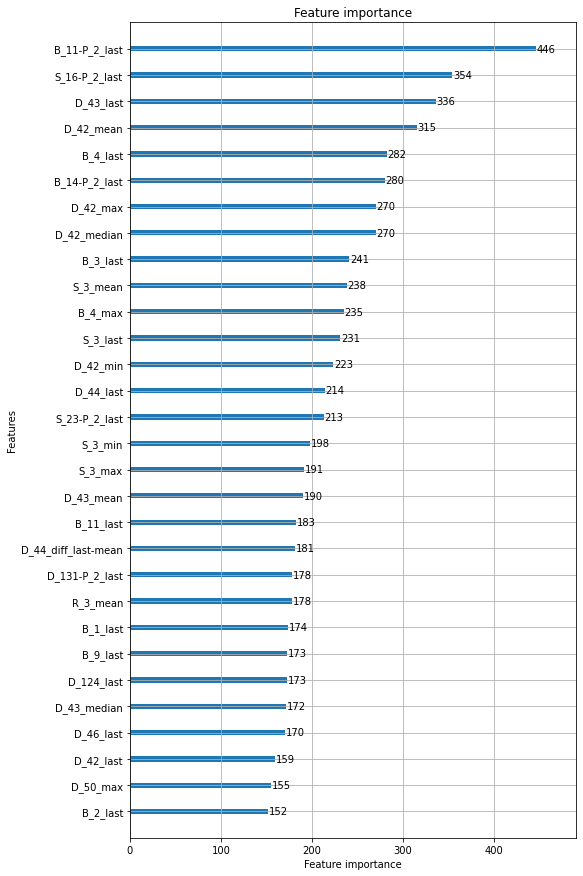

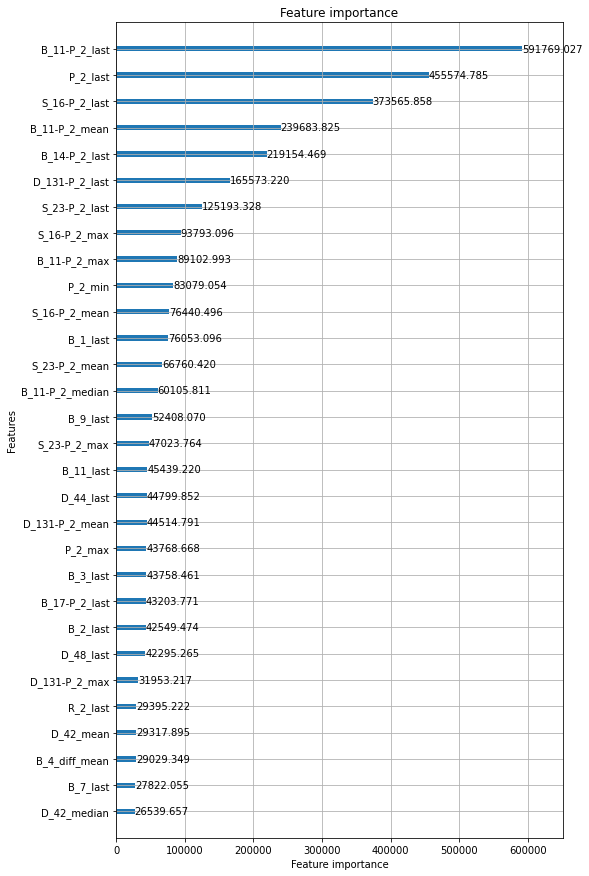

Training time: 33.81853065490723 min.
OOF recall_at4: 0.6671575722893595
OOF normalized_gini: 0.9253885354871223
OOF competition metric: 0.7962730538882409


############################### repeated cross-validation step: 4/5 ################################


######################################## training model 1/5 ########################################
seed: 15


[50]	valid_0's amex_metric: 0.74894	valid_0's recall_at4: 0.599007	valid_0's norm_gini: 0.898874


[100]	valid_0's amex_metric: 0.760584	valid_0's recall_at4: 0.616511	valid_0's norm_gini: 0.904657


[150]	valid_0's amex_metric: 0.766202	valid_0's recall_at4: 0.623748	valid_0's norm_gini: 0.908655


[200]	valid_0's amex_metric: 0.770201	valid_0's recall_at4: 0.629218	valid_0's norm_gini: 0.911184


[250]	valid_0's amex_metric: 0.775002	valid_0's recall_at4: 0.636287	valid_0's norm_gini: 0.913717


[300]	valid_0's amex_metric: 0.777349	valid_0's recall_at4: 0.639317	valid_0's norm_gini: 0.915382


[350]	valid_0's amex_metric: 0.779552	valid_0's recall_at4: 0.642641	valid_0's norm_gini: 0.916463


[400]	valid_0's amex_metric: 0.781885	valid_0's recall_at4: 0.646049	valid_0's norm_gini: 0.917722


[450]	valid_0's amex_metric: 0.782821	valid_0's recall_at4: 0.647311	valid_0's norm_gini: 0.91833


[500]	valid_0's amex_metric: 0.783991	valid_0's recall_at4: 0.649121	valid_0's norm_gini: 0.918862


[550]	valid_0's amex_metric: 0.784513	valid_0's recall_at4: 0.64971	valid_0's norm_gini: 0.919316


[600]	valid_0's amex_metric: 0.785713	valid_0's recall_at4: 0.651603	valid_0's norm_gini: 0.919822


[650]	valid_0's amex_metric: 0.786733	valid_0's recall_at4: 0.653202	valid_0's norm_gini: 0.920263


[700]	valid_0's amex_metric: 0.787264	valid_0's recall_at4: 0.654002	valid_0's norm_gini: 0.920527


[750]	valid_0's amex_metric: 0.788338	valid_0's recall_at4: 0.655853	valid_0's norm_gini: 0.920824


[800]	valid_0's amex_metric: 0.788765	valid_0's recall_at4: 0.656484	valid_0's norm_gini: 0.921047


[850]	valid_0's amex_metric: 0.788681	valid_0's recall_at4: 0.656063	valid_0's norm_gini: 0.9213


[900]	valid_0's amex_metric: 0.789485	valid_0's recall_at4: 0.657452	valid_0's norm_gini: 0.921517


[950]	valid_0's amex_metric: 0.789625	valid_0's recall_at4: 0.65762	valid_0's norm_gini: 0.921629


[1000]	valid_0's amex_metric: 0.789482	valid_0's recall_at4: 0.657199	valid_0's norm_gini: 0.921764


[1050]	valid_0's amex_metric: 0.789503	valid_0's recall_at4: 0.657115	valid_0's norm_gini: 0.921891


[1100]	valid_0's amex_metric: 0.79013	valid_0's recall_at4: 0.658209	valid_0's norm_gini: 0.92205


[1150]	valid_0's amex_metric: 0.789892	valid_0's recall_at4: 0.657662	valid_0's norm_gini: 0.922122


[1200]	valid_0's amex_metric: 0.789562	valid_0's recall_at4: 0.656863	valid_0's norm_gini: 0.922261


[1250]	valid_0's amex_metric: 0.790489	valid_0's recall_at4: 0.658588	valid_0's norm_gini: 0.922391


[1300]	valid_0's amex_metric: 0.790534	valid_0's recall_at4: 0.658588	valid_0's norm_gini: 0.92248


[1350]	valid_0's amex_metric: 0.790353	valid_0's recall_at4: 0.658167	valid_0's norm_gini: 0.922539


[1400]	valid_0's amex_metric: 0.790613	valid_0's recall_at4: 0.65863	valid_0's norm_gini: 0.922596


[1450]	valid_0's amex_metric: 0.790154	valid_0's recall_at4: 0.657662	valid_0's norm_gini: 0.922647


[1500]	valid_0's amex_metric: 0.789718	valid_0's recall_at4: 0.656736	valid_0's norm_gini: 0.922699


[1550]	valid_0's amex_metric: 0.789644	valid_0's recall_at4: 0.656526	valid_0's norm_gini: 0.922762


[1600]	valid_0's amex_metric: 0.790501	valid_0's recall_at4: 0.658167	valid_0's norm_gini: 0.922834


[1650]	valid_0's amex_metric: 0.790269	valid_0's recall_at4: 0.657662	valid_0's norm_gini: 0.922875


[1700]	valid_0's amex_metric: 0.790265	valid_0's recall_at4: 0.657578	valid_0's norm_gini: 0.922952


[1750]	valid_0's amex_metric: 0.790196	valid_0's recall_at4: 0.65741	valid_0's norm_gini: 0.922982


[1800]	valid_0's amex_metric: 0.790369	valid_0's recall_at4: 0.657746	valid_0's norm_gini: 0.922991


[1850]	valid_0's amex_metric: 0.790894	valid_0's recall_at4: 0.658714	valid_0's norm_gini: 0.923074


[1900]	valid_0's amex_metric: 0.79065	valid_0's recall_at4: 0.658209	valid_0's norm_gini: 0.923091


[1950]	valid_0's amex_metric: 0.790941	valid_0's recall_at4: 0.658756	valid_0's norm_gini: 0.923125


[2000]	valid_0's amex_metric: 0.791075	valid_0's recall_at4: 0.659009	valid_0's norm_gini: 0.923141


[2050]	valid_0's amex_metric: 0.790829	valid_0's recall_at4: 0.658504	valid_0's norm_gini: 0.923154


[2100]	valid_0's amex_metric: 0.790924	valid_0's recall_at4: 0.658672	valid_0's norm_gini: 0.923176


[2150]	valid_0's amex_metric: 0.791124	valid_0's recall_at4: 0.659051	valid_0's norm_gini: 0.923197


[2200]	valid_0's amex_metric: 0.790721	valid_0's recall_at4: 0.658251	valid_0's norm_gini: 0.92319


[2250]	valid_0's amex_metric: 0.791176	valid_0's recall_at4: 0.659135	valid_0's norm_gini: 0.923217


[2300]	valid_0's amex_metric: 0.79121	valid_0's recall_at4: 0.659177	valid_0's norm_gini: 0.923242


[2350]	valid_0's amex_metric: 0.79089	valid_0's recall_at4: 0.658546	valid_0's norm_gini: 0.923234


[2400]	valid_0's amex_metric: 0.791031	valid_0's recall_at4: 0.658798	valid_0's norm_gini: 0.923263


[2450]	valid_0's amex_metric: 0.790939	valid_0's recall_at4: 0.658588	valid_0's norm_gini: 0.92329


[2500]	valid_0's amex_metric: 0.790454	valid_0's recall_at4: 0.657578	valid_0's norm_gini: 0.92333


[2550]	valid_0's amex_metric: 0.791257	valid_0's recall_at4: 0.659177	valid_0's norm_gini: 0.923338


[2600]	valid_0's amex_metric: 0.791216	valid_0's recall_at4: 0.659093	valid_0's norm_gini: 0.923339


[2650]	valid_0's amex_metric: 0.791073	valid_0's recall_at4: 0.658798	valid_0's norm_gini: 0.923348


[2700]	valid_0's amex_metric: 0.79123	valid_0's recall_at4: 0.659093	valid_0's norm_gini: 0.923366


[2750]	valid_0's amex_metric: 0.791336	valid_0's recall_at4: 0.659303	valid_0's norm_gini: 0.92337


[2800]	valid_0's amex_metric: 0.79104	valid_0's recall_at4: 0.658714	valid_0's norm_gini: 0.923366


[2850]	valid_0's amex_metric: 0.790983	valid_0's recall_at4: 0.658588	valid_0's norm_gini: 0.923377


[2900]	valid_0's amex_metric: 0.790914	valid_0's recall_at4: 0.65842	valid_0's norm_gini: 0.923409


[2950]	valid_0's amex_metric: 0.790925	valid_0's recall_at4: 0.65842	valid_0's norm_gini: 0.923431


[3000]	valid_0's amex_metric: 0.790782	valid_0's recall_at4: 0.658125	valid_0's norm_gini: 0.923439


[3050]	valid_0's amex_metric: 0.790491	valid_0's recall_at4: 0.657536	valid_0's norm_gini: 0.923447


[3100]	valid_0's amex_metric: 0.790622	valid_0's recall_at4: 0.657788	valid_0's norm_gini: 0.923456


[3150]	valid_0's amex_metric: 0.790952	valid_0's recall_at4: 0.65842	valid_0's norm_gini: 0.923483


[3200]	valid_0's amex_metric: 0.790638	valid_0's recall_at4: 0.657788	valid_0's norm_gini: 0.923488


[3250]	valid_0's amex_metric: 0.790741	valid_0's recall_at4: 0.657999	valid_0's norm_gini: 0.923483


[3300]	valid_0's amex_metric: 0.790811	valid_0's recall_at4: 0.658125	valid_0's norm_gini: 0.923497


[3350]	valid_0's amex_metric: 0.791121	valid_0's recall_at4: 0.658714	valid_0's norm_gini: 0.923528


[3400]	valid_0's amex_metric: 0.790663	valid_0's recall_at4: 0.657788	valid_0's norm_gini: 0.923538


[3450]	valid_0's amex_metric: 0.790762	valid_0's recall_at4: 0.657957	valid_0's norm_gini: 0.923568


[3500]	valid_0's amex_metric: 0.791595	valid_0's recall_at4: 0.659598	valid_0's norm_gini: 0.923593


[3550]	valid_0's amex_metric: 0.791636	valid_0's recall_at4: 0.659682	valid_0's norm_gini: 0.923589


[3600]	valid_0's amex_metric: 0.791452	valid_0's recall_at4: 0.659303	valid_0's norm_gini: 0.923601


[3650]	valid_0's amex_metric: 0.791137	valid_0's recall_at4: 0.658672	valid_0's norm_gini: 0.923601


[3700]	valid_0's amex_metric: 0.790947	valid_0's recall_at4: 0.658293	valid_0's norm_gini: 0.9236


[3750]	valid_0's amex_metric: 0.790751	valid_0's recall_at4: 0.657915	valid_0's norm_gini: 0.923588


[3800]	valid_0's amex_metric: 0.790289	valid_0's recall_at4: 0.656989	valid_0's norm_gini: 0.923589


[3850]	valid_0's amex_metric: 0.790476	valid_0's recall_at4: 0.657368	valid_0's norm_gini: 0.923585


[3900]	valid_0's amex_metric: 0.790144	valid_0's recall_at4: 0.656694	valid_0's norm_gini: 0.923593


[3950]	valid_0's amex_metric: 0.790655	valid_0's recall_at4: 0.657704	valid_0's norm_gini: 0.923606


[4000]	valid_0's amex_metric: 0.79067	valid_0's recall_at4: 0.657746	valid_0's norm_gini: 0.923594


[4050]	valid_0's amex_metric: 0.790504	valid_0's recall_at4: 0.65741	valid_0's norm_gini: 0.923598


[4100]	valid_0's amex_metric: 0.79074	valid_0's recall_at4: 0.657873	valid_0's norm_gini: 0.923607


[4150]	valid_0's amex_metric: 0.790531	valid_0's recall_at4: 0.657452	valid_0's norm_gini: 0.92361


[4200]	valid_0's amex_metric: 0.790668	valid_0's recall_at4: 0.657746	valid_0's norm_gini: 0.92359


[4250]	valid_0's amex_metric: 0.791135	valid_0's recall_at4: 0.658672	valid_0's norm_gini: 0.923598


[4300]	valid_0's amex_metric: 0.791174	valid_0's recall_at4: 0.658756	valid_0's norm_gini: 0.923593


[4350]	valid_0's amex_metric: 0.791137	valid_0's recall_at4: 0.658672	valid_0's norm_gini: 0.923603


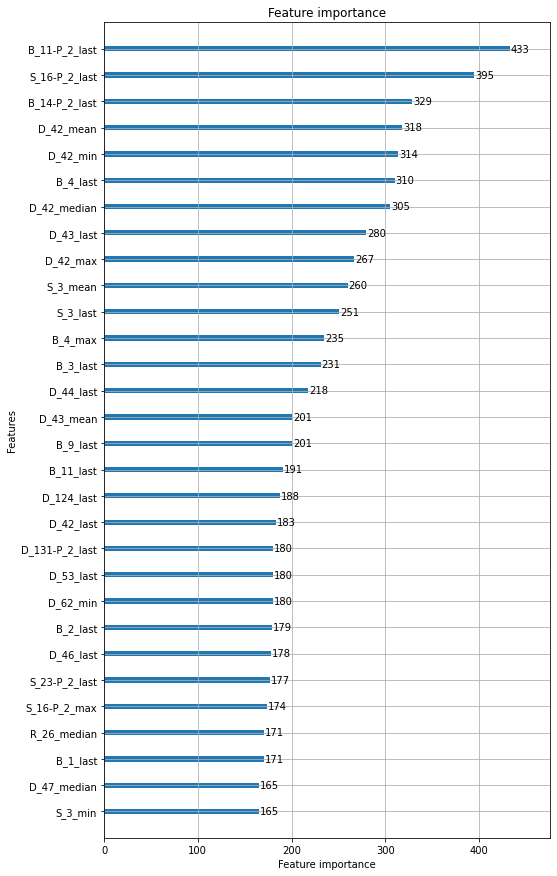

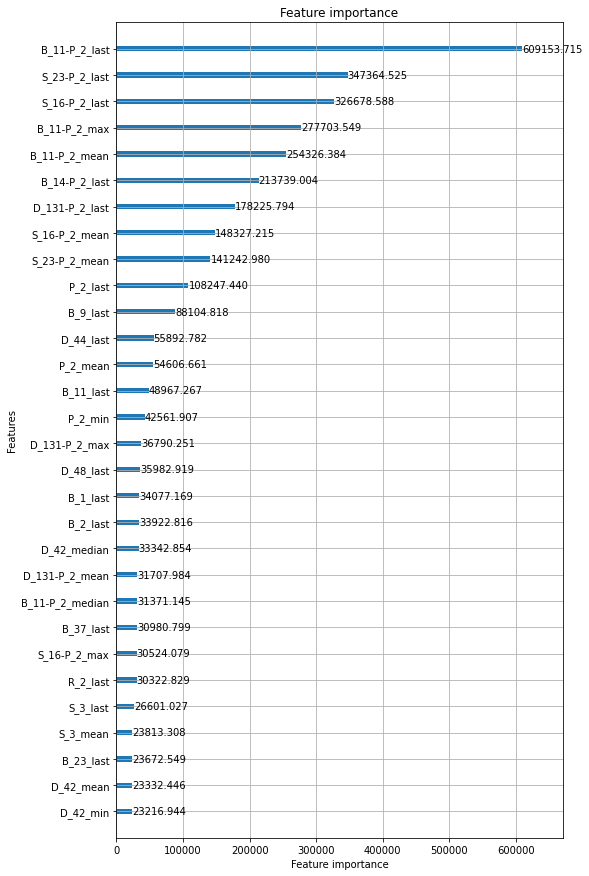

######################################## training model 2/5 ########################################
seed: 16


[50]	valid_0's amex_metric: 0.755673	valid_0's recall_at4: 0.609105	valid_0's norm_gini: 0.902241


[100]	valid_0's amex_metric: 0.76666	valid_0's recall_at4: 0.625095	valid_0's norm_gini: 0.908224


[150]	valid_0's amex_metric: 0.773588	valid_0's recall_at4: 0.634394	valid_0's norm_gini: 0.912782


[200]	valid_0's amex_metric: 0.777516	valid_0's recall_at4: 0.639737	valid_0's norm_gini: 0.915294


[250]	valid_0's amex_metric: 0.778751	valid_0's recall_at4: 0.640663	valid_0's norm_gini: 0.916839


[300]	valid_0's amex_metric: 0.78103	valid_0's recall_at4: 0.644071	valid_0's norm_gini: 0.917989


[350]	valid_0's amex_metric: 0.784125	valid_0's recall_at4: 0.648826	valid_0's norm_gini: 0.919424


[400]	valid_0's amex_metric: 0.78587	valid_0's recall_at4: 0.651435	valid_0's norm_gini: 0.920304


[450]	valid_0's amex_metric: 0.787102	valid_0's recall_at4: 0.65337	valid_0's norm_gini: 0.920834


[500]	valid_0's amex_metric: 0.788571	valid_0's recall_at4: 0.655727	valid_0's norm_gini: 0.921415


[550]	valid_0's amex_metric: 0.789212	valid_0's recall_at4: 0.656526	valid_0's norm_gini: 0.921899


[600]	valid_0's amex_metric: 0.789873	valid_0's recall_at4: 0.657536	valid_0's norm_gini: 0.922209


[650]	valid_0's amex_metric: 0.789937	valid_0's recall_at4: 0.657326	valid_0's norm_gini: 0.922549


[700]	valid_0's amex_metric: 0.790644	valid_0's recall_at4: 0.658378	valid_0's norm_gini: 0.92291


[750]	valid_0's amex_metric: 0.791415	valid_0's recall_at4: 0.659682	valid_0's norm_gini: 0.923148


[800]	valid_0's amex_metric: 0.792179	valid_0's recall_at4: 0.660986	valid_0's norm_gini: 0.923372


[850]	valid_0's amex_metric: 0.791245	valid_0's recall_at4: 0.658925	valid_0's norm_gini: 0.923566


[900]	valid_0's amex_metric: 0.792426	valid_0's recall_at4: 0.661028	valid_0's norm_gini: 0.923823


[950]	valid_0's amex_metric: 0.792794	valid_0's recall_at4: 0.66166	valid_0's norm_gini: 0.923928


[1000]	valid_0's amex_metric: 0.793424	valid_0's recall_at4: 0.662754	valid_0's norm_gini: 0.924095


[1050]	valid_0's amex_metric: 0.793946	valid_0's recall_at4: 0.663595	valid_0's norm_gini: 0.924297


[1100]	valid_0's amex_metric: 0.793849	valid_0's recall_at4: 0.663301	valid_0's norm_gini: 0.924397


[1150]	valid_0's amex_metric: 0.794692	valid_0's recall_at4: 0.664857	valid_0's norm_gini: 0.924526


[1200]	valid_0's amex_metric: 0.795235	valid_0's recall_at4: 0.665825	valid_0's norm_gini: 0.924646


[1250]	valid_0's amex_metric: 0.795678	valid_0's recall_at4: 0.666625	valid_0's norm_gini: 0.924731


[1300]	valid_0's amex_metric: 0.795751	valid_0's recall_at4: 0.666667	valid_0's norm_gini: 0.924835


[1350]	valid_0's amex_metric: 0.795763	valid_0's recall_at4: 0.666625	valid_0's norm_gini: 0.924901


[1400]	valid_0's amex_metric: 0.79573	valid_0's recall_at4: 0.666498	valid_0's norm_gini: 0.924962


[1450]	valid_0's amex_metric: 0.795502	valid_0's recall_at4: 0.665951	valid_0's norm_gini: 0.925053


[1500]	valid_0's amex_metric: 0.79622	valid_0's recall_at4: 0.667298	valid_0's norm_gini: 0.925142


[1550]	valid_0's amex_metric: 0.796432	valid_0's recall_at4: 0.667677	valid_0's norm_gini: 0.925188


[1600]	valid_0's amex_metric: 0.796726	valid_0's recall_at4: 0.668224	valid_0's norm_gini: 0.925229


[1650]	valid_0's amex_metric: 0.796673	valid_0's recall_at4: 0.668055	valid_0's norm_gini: 0.925292


[1700]	valid_0's amex_metric: 0.796552	valid_0's recall_at4: 0.667761	valid_0's norm_gini: 0.925343


[1750]	valid_0's amex_metric: 0.796719	valid_0's recall_at4: 0.668055	valid_0's norm_gini: 0.925382


[1800]	valid_0's amex_metric: 0.796875	valid_0's recall_at4: 0.668308	valid_0's norm_gini: 0.925443


[1850]	valid_0's amex_metric: 0.797413	valid_0's recall_at4: 0.66936	valid_0's norm_gini: 0.925466


[1900]	valid_0's amex_metric: 0.797816	valid_0's recall_at4: 0.670117	valid_0's norm_gini: 0.925515


[1950]	valid_0's amex_metric: 0.797854	valid_0's recall_at4: 0.670159	valid_0's norm_gini: 0.925548


[2000]	valid_0's amex_metric: 0.798099	valid_0's recall_at4: 0.670622	valid_0's norm_gini: 0.925577


[2050]	valid_0's amex_metric: 0.798168	valid_0's recall_at4: 0.670706	valid_0's norm_gini: 0.92563


[2100]	valid_0's amex_metric: 0.797948	valid_0's recall_at4: 0.670243	valid_0's norm_gini: 0.925652


[2150]	valid_0's amex_metric: 0.798283	valid_0's recall_at4: 0.670874	valid_0's norm_gini: 0.925692


[2200]	valid_0's amex_metric: 0.798008	valid_0's recall_at4: 0.670285	valid_0's norm_gini: 0.92573


[2250]	valid_0's amex_metric: 0.798229	valid_0's recall_at4: 0.670706	valid_0's norm_gini: 0.925752


[2300]	valid_0's amex_metric: 0.798452	valid_0's recall_at4: 0.671127	valid_0's norm_gini: 0.925777


[2350]	valid_0's amex_metric: 0.798466	valid_0's recall_at4: 0.671127	valid_0's norm_gini: 0.925806


[2400]	valid_0's amex_metric: 0.798037	valid_0's recall_at4: 0.670243	valid_0's norm_gini: 0.925831


[2450]	valid_0's amex_metric: 0.79821	valid_0's recall_at4: 0.67058	valid_0's norm_gini: 0.92584


[2500]	valid_0's amex_metric: 0.798078	valid_0's recall_at4: 0.670285	valid_0's norm_gini: 0.925871


[2550]	valid_0's amex_metric: 0.797685	valid_0's recall_at4: 0.669486	valid_0's norm_gini: 0.925885


[2600]	valid_0's amex_metric: 0.797975	valid_0's recall_at4: 0.670033	valid_0's norm_gini: 0.925916


[2650]	valid_0's amex_metric: 0.797617	valid_0's recall_at4: 0.669317	valid_0's norm_gini: 0.925917


[2700]	valid_0's amex_metric: 0.797688	valid_0's recall_at4: 0.669444	valid_0's norm_gini: 0.925932


[2750]	valid_0's amex_metric: 0.798108	valid_0's recall_at4: 0.670285	valid_0's norm_gini: 0.925931


[2800]	valid_0's amex_metric: 0.797988	valid_0's recall_at4: 0.670033	valid_0's norm_gini: 0.925943


[2850]	valid_0's amex_metric: 0.797768	valid_0's recall_at4: 0.66957	valid_0's norm_gini: 0.925967


[2900]	valid_0's amex_metric: 0.797477	valid_0's recall_at4: 0.668981	valid_0's norm_gini: 0.925973


[2950]	valid_0's amex_metric: 0.797908	valid_0's recall_at4: 0.669822	valid_0's norm_gini: 0.925993


[3000]	valid_0's amex_metric: 0.798208	valid_0's recall_at4: 0.670412	valid_0's norm_gini: 0.926005


[3050]	valid_0's amex_metric: 0.798312	valid_0's recall_at4: 0.670622	valid_0's norm_gini: 0.926002


[3100]	valid_0's amex_metric: 0.79768	valid_0's recall_at4: 0.66936	valid_0's norm_gini: 0.926


[3150]	valid_0's amex_metric: 0.798114	valid_0's recall_at4: 0.670201	valid_0's norm_gini: 0.926026


[3200]	valid_0's amex_metric: 0.798179	valid_0's recall_at4: 0.670327	valid_0's norm_gini: 0.92603


[3250]	valid_0's amex_metric: 0.79845	valid_0's recall_at4: 0.670874	valid_0's norm_gini: 0.926025


[3300]	valid_0's amex_metric: 0.798751	valid_0's recall_at4: 0.671463	valid_0's norm_gini: 0.92604


[3350]	valid_0's amex_metric: 0.798564	valid_0's recall_at4: 0.671085	valid_0's norm_gini: 0.926043


[3400]	valid_0's amex_metric: 0.798422	valid_0's recall_at4: 0.67079	valid_0's norm_gini: 0.926054


[3450]	valid_0's amex_metric: 0.798891	valid_0's recall_at4: 0.671716	valid_0's norm_gini: 0.926067


[3500]	valid_0's amex_metric: 0.799212	valid_0's recall_at4: 0.672347	valid_0's norm_gini: 0.926078


[3550]	valid_0's amex_metric: 0.799125	valid_0's recall_at4: 0.672137	valid_0's norm_gini: 0.926113


[3600]	valid_0's amex_metric: 0.799059	valid_0's recall_at4: 0.67201	valid_0's norm_gini: 0.926107


[3650]	valid_0's amex_metric: 0.798914	valid_0's recall_at4: 0.671716	valid_0's norm_gini: 0.926113


[3700]	valid_0's amex_metric: 0.798524	valid_0's recall_at4: 0.670916	valid_0's norm_gini: 0.926131


[3750]	valid_0's amex_metric: 0.799034	valid_0's recall_at4: 0.671926	valid_0's norm_gini: 0.926143


[3800]	valid_0's amex_metric: 0.799113	valid_0's recall_at4: 0.672095	valid_0's norm_gini: 0.926132


[3850]	valid_0's amex_metric: 0.799124	valid_0's recall_at4: 0.672095	valid_0's norm_gini: 0.926153


[3900]	valid_0's amex_metric: 0.799125	valid_0's recall_at4: 0.672095	valid_0's norm_gini: 0.926156


[3950]	valid_0's amex_metric: 0.799067	valid_0's recall_at4: 0.671968	valid_0's norm_gini: 0.926165


[4000]	valid_0's amex_metric: 0.799134	valid_0's recall_at4: 0.672095	valid_0's norm_gini: 0.926174


[4050]	valid_0's amex_metric: 0.798917	valid_0's recall_at4: 0.671674	valid_0's norm_gini: 0.92616


[4100]	valid_0's amex_metric: 0.798937	valid_0's recall_at4: 0.671716	valid_0's norm_gini: 0.926157


[4150]	valid_0's amex_metric: 0.799352	valid_0's recall_at4: 0.672557	valid_0's norm_gini: 0.926146


[4200]	valid_0's amex_metric: 0.798926	valid_0's recall_at4: 0.671716	valid_0's norm_gini: 0.926136


[4250]	valid_0's amex_metric: 0.799218	valid_0's recall_at4: 0.672305	valid_0's norm_gini: 0.926131


[4300]	valid_0's amex_metric: 0.799357	valid_0's recall_at4: 0.672557	valid_0's norm_gini: 0.926156


[4350]	valid_0's amex_metric: 0.799043	valid_0's recall_at4: 0.671926	valid_0's norm_gini: 0.926159


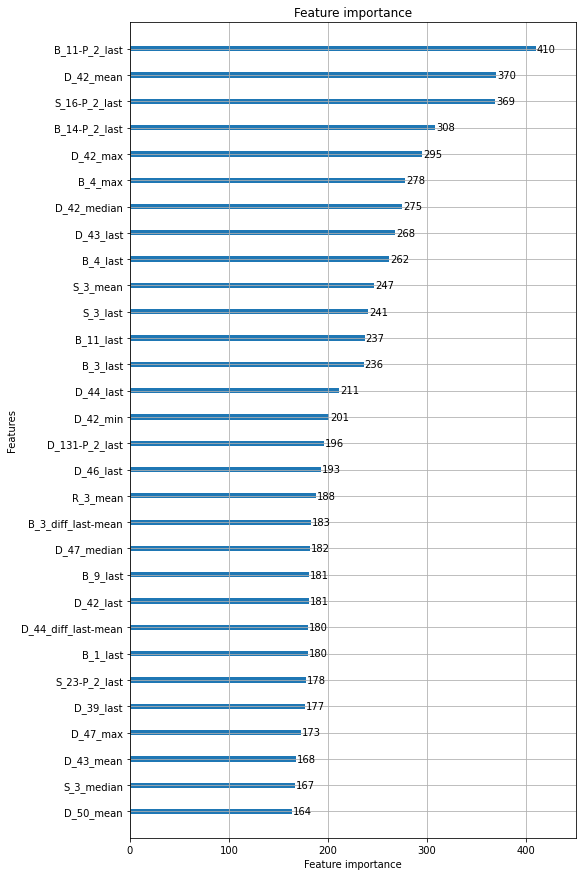

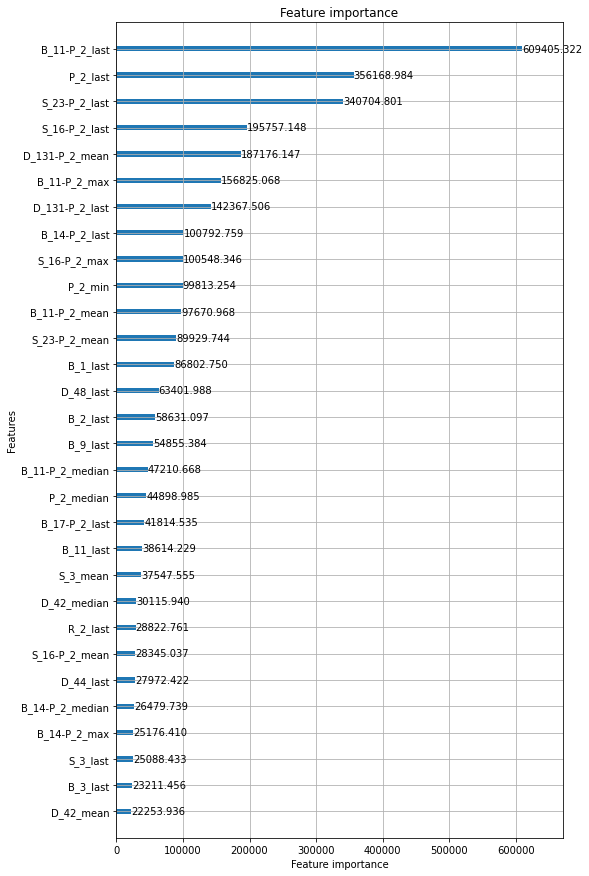

######################################## training model 3/5 ########################################
seed: 17


[50]	valid_0's amex_metric: 0.754941	valid_0's recall_at4: 0.607464	valid_0's norm_gini: 0.902417


[100]	valid_0's amex_metric: 0.764655	valid_0's recall_at4: 0.621224	valid_0's norm_gini: 0.908086


[150]	valid_0's amex_metric: 0.77399	valid_0's recall_at4: 0.634688	valid_0's norm_gini: 0.913293


[200]	valid_0's amex_metric: 0.778127	valid_0's recall_at4: 0.640579	valid_0's norm_gini: 0.915675


[250]	valid_0's amex_metric: 0.780355	valid_0's recall_at4: 0.643777	valid_0's norm_gini: 0.916934


[300]	valid_0's amex_metric: 0.78406	valid_0's recall_at4: 0.649415	valid_0's norm_gini: 0.918705


[350]	valid_0's amex_metric: 0.785923	valid_0's recall_at4: 0.652108	valid_0's norm_gini: 0.919737


[400]	valid_0's amex_metric: 0.788708	valid_0's recall_at4: 0.656568	valid_0's norm_gini: 0.920848


[450]	valid_0's amex_metric: 0.78973	valid_0's recall_at4: 0.657831	valid_0's norm_gini: 0.92163


[500]	valid_0's amex_metric: 0.790897	valid_0's recall_at4: 0.659472	valid_0's norm_gini: 0.922322


[550]	valid_0's amex_metric: 0.791778	valid_0's recall_at4: 0.660776	valid_0's norm_gini: 0.92278


[600]	valid_0's amex_metric: 0.792471	valid_0's recall_at4: 0.661617	valid_0's norm_gini: 0.923325


[650]	valid_0's amex_metric: 0.79304	valid_0's recall_at4: 0.662459	valid_0's norm_gini: 0.923622


[700]	valid_0's amex_metric: 0.793675	valid_0's recall_at4: 0.663469	valid_0's norm_gini: 0.923881


[750]	valid_0's amex_metric: 0.794148	valid_0's recall_at4: 0.664184	valid_0's norm_gini: 0.924112


[800]	valid_0's amex_metric: 0.794757	valid_0's recall_at4: 0.66511	valid_0's norm_gini: 0.924404


[850]	valid_0's amex_metric: 0.795461	valid_0's recall_at4: 0.666246	valid_0's norm_gini: 0.924676


[900]	valid_0's amex_metric: 0.795411	valid_0's recall_at4: 0.665867	valid_0's norm_gini: 0.924955


[950]	valid_0's amex_metric: 0.796312	valid_0's recall_at4: 0.667508	valid_0's norm_gini: 0.925115


[1000]	valid_0's amex_metric: 0.796359	valid_0's recall_at4: 0.667424	valid_0's norm_gini: 0.925294


[1050]	valid_0's amex_metric: 0.796865	valid_0's recall_at4: 0.66835	valid_0's norm_gini: 0.92538


[1100]	valid_0's amex_metric: 0.797357	valid_0's recall_at4: 0.669191	valid_0's norm_gini: 0.925523


[1150]	valid_0's amex_metric: 0.797414	valid_0's recall_at4: 0.669191	valid_0's norm_gini: 0.925637


[1200]	valid_0's amex_metric: 0.797549	valid_0's recall_at4: 0.669402	valid_0's norm_gini: 0.925697


[1250]	valid_0's amex_metric: 0.797279	valid_0's recall_at4: 0.668728	valid_0's norm_gini: 0.925829


[1300]	valid_0's amex_metric: 0.798302	valid_0's recall_at4: 0.670622	valid_0's norm_gini: 0.925982


[1350]	valid_0's amex_metric: 0.798457	valid_0's recall_at4: 0.670874	valid_0's norm_gini: 0.926041


[1400]	valid_0's amex_metric: 0.799083	valid_0's recall_at4: 0.67201	valid_0's norm_gini: 0.926156


[1450]	valid_0's amex_metric: 0.799215	valid_0's recall_at4: 0.672179	valid_0's norm_gini: 0.926251


[1500]	valid_0's amex_metric: 0.799524	valid_0's recall_at4: 0.672726	valid_0's norm_gini: 0.926323


[1550]	valid_0's amex_metric: 0.799515	valid_0's recall_at4: 0.672642	valid_0's norm_gini: 0.926388


[1600]	valid_0's amex_metric: 0.799755	valid_0's recall_at4: 0.673062	valid_0's norm_gini: 0.926447


[1650]	valid_0's amex_metric: 0.799721	valid_0's recall_at4: 0.672936	valid_0's norm_gini: 0.926506


[1700]	valid_0's amex_metric: 0.799285	valid_0's recall_at4: 0.67201	valid_0's norm_gini: 0.92656


[1750]	valid_0's amex_metric: 0.799908	valid_0's recall_at4: 0.673231	valid_0's norm_gini: 0.926586


[1800]	valid_0's amex_metric: 0.799821	valid_0's recall_at4: 0.67302	valid_0's norm_gini: 0.926622


[1850]	valid_0's amex_metric: 0.800121	valid_0's recall_at4: 0.673609	valid_0's norm_gini: 0.926632


[1900]	valid_0's amex_metric: 0.800426	valid_0's recall_at4: 0.674156	valid_0's norm_gini: 0.926695


[1950]	valid_0's amex_metric: 0.800636	valid_0's recall_at4: 0.674535	valid_0's norm_gini: 0.926738


[2000]	valid_0's amex_metric: 0.800783	valid_0's recall_at4: 0.674788	valid_0's norm_gini: 0.926779


[2050]	valid_0's amex_metric: 0.80086	valid_0's recall_at4: 0.674914	valid_0's norm_gini: 0.926806


[2100]	valid_0's amex_metric: 0.80051	valid_0's recall_at4: 0.674156	valid_0's norm_gini: 0.926864


[2150]	valid_0's amex_metric: 0.800524	valid_0's recall_at4: 0.674156	valid_0's norm_gini: 0.926891


[2200]	valid_0's amex_metric: 0.800349	valid_0's recall_at4: 0.673778	valid_0's norm_gini: 0.926921


[2250]	valid_0's amex_metric: 0.800402	valid_0's recall_at4: 0.673862	valid_0's norm_gini: 0.926942


[2300]	valid_0's amex_metric: 0.80086	valid_0's recall_at4: 0.674745	valid_0's norm_gini: 0.926974


[2350]	valid_0's amex_metric: 0.800471	valid_0's recall_at4: 0.673946	valid_0's norm_gini: 0.926996


[2400]	valid_0's amex_metric: 0.800572	valid_0's recall_at4: 0.674114	valid_0's norm_gini: 0.927029


[2450]	valid_0's amex_metric: 0.80004	valid_0's recall_at4: 0.67302	valid_0's norm_gini: 0.927059


[2500]	valid_0's amex_metric: 0.800349	valid_0's recall_at4: 0.673609	valid_0's norm_gini: 0.927088


[2550]	valid_0's amex_metric: 0.800527	valid_0's recall_at4: 0.673946	valid_0's norm_gini: 0.927109


[2600]	valid_0's amex_metric: 0.800275	valid_0's recall_at4: 0.673399	valid_0's norm_gini: 0.927151


[2650]	valid_0's amex_metric: 0.800517	valid_0's recall_at4: 0.673862	valid_0's norm_gini: 0.927173


[2700]	valid_0's amex_metric: 0.800985	valid_0's recall_at4: 0.674788	valid_0's norm_gini: 0.927183


[2750]	valid_0's amex_metric: 0.800504	valid_0's recall_at4: 0.67382	valid_0's norm_gini: 0.927188


[2800]	valid_0's amex_metric: 0.800555	valid_0's recall_at4: 0.673904	valid_0's norm_gini: 0.927206


[2850]	valid_0's amex_metric: 0.800375	valid_0's recall_at4: 0.673525	valid_0's norm_gini: 0.927225


[2900]	valid_0's amex_metric: 0.800596	valid_0's recall_at4: 0.673946	valid_0's norm_gini: 0.927246


[2950]	valid_0's amex_metric: 0.801	valid_0's recall_at4: 0.674745	valid_0's norm_gini: 0.927255


[3000]	valid_0's amex_metric: 0.800906	valid_0's recall_at4: 0.674535	valid_0's norm_gini: 0.927277


[3050]	valid_0's amex_metric: 0.801178	valid_0's recall_at4: 0.675082	valid_0's norm_gini: 0.927273


[3100]	valid_0's amex_metric: 0.801201	valid_0's recall_at4: 0.675124	valid_0's norm_gini: 0.927279


[3150]	valid_0's amex_metric: 0.80135	valid_0's recall_at4: 0.675419	valid_0's norm_gini: 0.927281


[3200]	valid_0's amex_metric: 0.801424	valid_0's recall_at4: 0.675545	valid_0's norm_gini: 0.927303


[3250]	valid_0's amex_metric: 0.800922	valid_0's recall_at4: 0.674535	valid_0's norm_gini: 0.927308


[3300]	valid_0's amex_metric: 0.800929	valid_0's recall_at4: 0.674535	valid_0's norm_gini: 0.927322


[3350]	valid_0's amex_metric: 0.801462	valid_0's recall_at4: 0.675587	valid_0's norm_gini: 0.927338


[3400]	valid_0's amex_metric: 0.80161	valid_0's recall_at4: 0.675882	valid_0's norm_gini: 0.927338


[3450]	valid_0's amex_metric: 0.801327	valid_0's recall_at4: 0.675292	valid_0's norm_gini: 0.927362


[3500]	valid_0's amex_metric: 0.801642	valid_0's recall_at4: 0.675924	valid_0's norm_gini: 0.92736


[3550]	valid_0's amex_metric: 0.801354	valid_0's recall_at4: 0.675335	valid_0's norm_gini: 0.927374


[3600]	valid_0's amex_metric: 0.801612	valid_0's recall_at4: 0.675839	valid_0's norm_gini: 0.927384


[3650]	valid_0's amex_metric: 0.801505	valid_0's recall_at4: 0.675629	valid_0's norm_gini: 0.92738


[3700]	valid_0's amex_metric: 0.802076	valid_0's recall_at4: 0.676765	valid_0's norm_gini: 0.927387


[3750]	valid_0's amex_metric: 0.801823	valid_0's recall_at4: 0.676218	valid_0's norm_gini: 0.927428


[3800]	valid_0's amex_metric: 0.802014	valid_0's recall_at4: 0.676597	valid_0's norm_gini: 0.927432


[3850]	valid_0's amex_metric: 0.801913	valid_0's recall_at4: 0.676386	valid_0's norm_gini: 0.927439


[3900]	valid_0's amex_metric: 0.801876	valid_0's recall_at4: 0.676302	valid_0's norm_gini: 0.92745


[3950]	valid_0's amex_metric: 0.801804	valid_0's recall_at4: 0.676134	valid_0's norm_gini: 0.927474


[4000]	valid_0's amex_metric: 0.801699	valid_0's recall_at4: 0.675924	valid_0's norm_gini: 0.927475


[4050]	valid_0's amex_metric: 0.801909	valid_0's recall_at4: 0.676344	valid_0's norm_gini: 0.927473


[4100]	valid_0's amex_metric: 0.801386	valid_0's recall_at4: 0.675292	valid_0's norm_gini: 0.927479


[4150]	valid_0's amex_metric: 0.801866	valid_0's recall_at4: 0.67626	valid_0's norm_gini: 0.927473


[4200]	valid_0's amex_metric: 0.801481	valid_0's recall_at4: 0.675503	valid_0's norm_gini: 0.927459


[4250]	valid_0's amex_metric: 0.80186	valid_0's recall_at4: 0.67626	valid_0's norm_gini: 0.927459


[4300]	valid_0's amex_metric: 0.80199	valid_0's recall_at4: 0.676513	valid_0's norm_gini: 0.927467


[4350]	valid_0's amex_metric: 0.802121	valid_0's recall_at4: 0.676765	valid_0's norm_gini: 0.927476


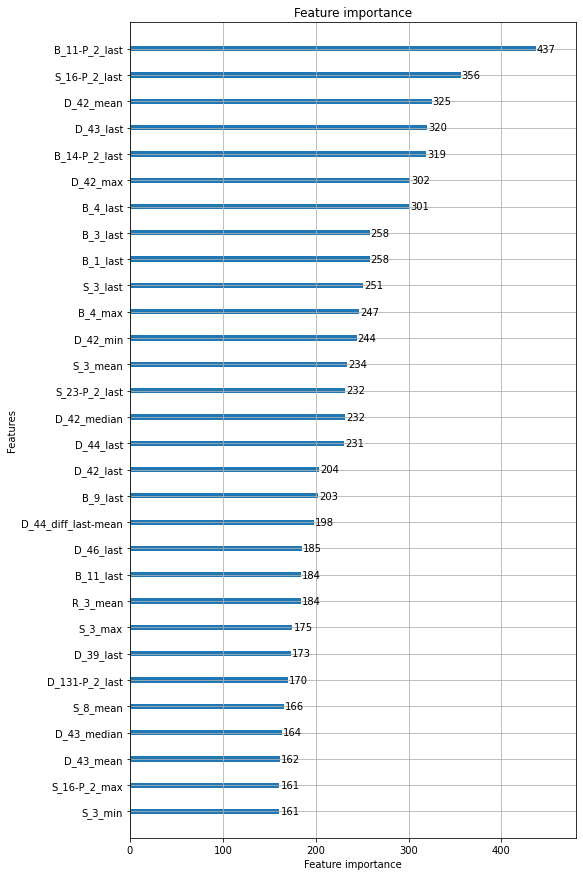

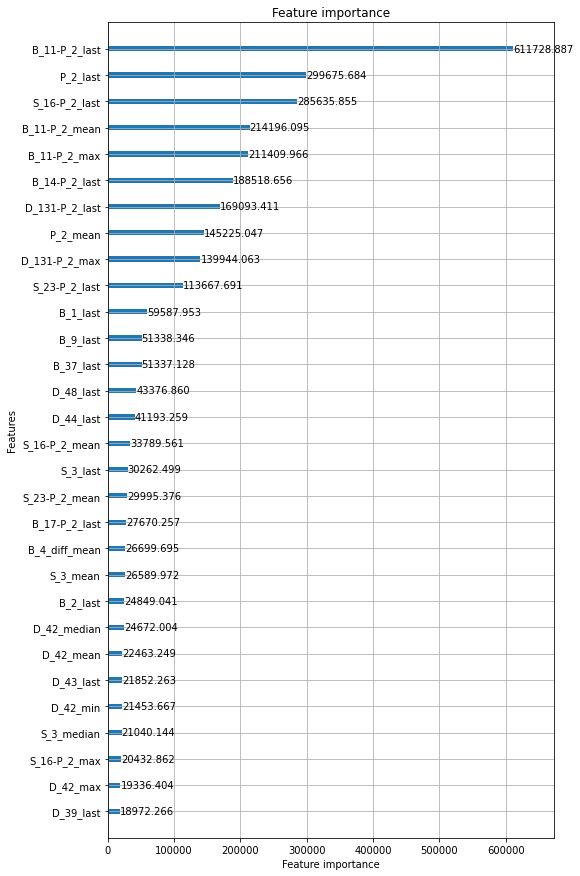

######################################## training model 4/5 ########################################
seed: 18


[50]	valid_0's amex_metric: 0.752037	valid_0's recall_at4: 0.602735	valid_0's norm_gini: 0.901339


[100]	valid_0's amex_metric: 0.762979	valid_0's recall_at4: 0.617883	valid_0's norm_gini: 0.908075


[150]	valid_0's amex_metric: 0.768735	valid_0's recall_at4: 0.626425	valid_0's norm_gini: 0.911044


[200]	valid_0's amex_metric: 0.773476	valid_0's recall_at4: 0.6332	valid_0's norm_gini: 0.913751


[250]	valid_0's amex_metric: 0.77742	valid_0's recall_at4: 0.639091	valid_0's norm_gini: 0.915749


[300]	valid_0's amex_metric: 0.778252	valid_0's recall_at4: 0.639849	valid_0's norm_gini: 0.916656


[350]	valid_0's amex_metric: 0.78047	valid_0's recall_at4: 0.643299	valid_0's norm_gini: 0.91764


[400]	valid_0's amex_metric: 0.782807	valid_0's recall_at4: 0.647002	valid_0's norm_gini: 0.918611


[450]	valid_0's amex_metric: 0.784585	valid_0's recall_at4: 0.649863	valid_0's norm_gini: 0.919307


[500]	valid_0's amex_metric: 0.785845	valid_0's recall_at4: 0.651546	valid_0's norm_gini: 0.920144


[550]	valid_0's amex_metric: 0.786984	valid_0's recall_at4: 0.653314	valid_0's norm_gini: 0.920654


[600]	valid_0's amex_metric: 0.787958	valid_0's recall_at4: 0.654913	valid_0's norm_gini: 0.921003


[650]	valid_0's amex_metric: 0.787879	valid_0's recall_at4: 0.654408	valid_0's norm_gini: 0.92135


[700]	valid_0's amex_metric: 0.78902	valid_0's recall_at4: 0.656343	valid_0's norm_gini: 0.921696


[750]	valid_0's amex_metric: 0.790262	valid_0's recall_at4: 0.658489	valid_0's norm_gini: 0.922035


[800]	valid_0's amex_metric: 0.791318	valid_0's recall_at4: 0.660257	valid_0's norm_gini: 0.92238


[850]	valid_0's amex_metric: 0.7913	valid_0's recall_at4: 0.660004	valid_0's norm_gini: 0.922597


[900]	valid_0's amex_metric: 0.791559	valid_0's recall_at4: 0.660299	valid_0's norm_gini: 0.922819


[950]	valid_0's amex_metric: 0.791817	valid_0's recall_at4: 0.660635	valid_0's norm_gini: 0.922998


[1000]	valid_0's amex_metric: 0.791764	valid_0's recall_at4: 0.660341	valid_0's norm_gini: 0.923187


[1050]	valid_0's amex_metric: 0.791839	valid_0's recall_at4: 0.660341	valid_0's norm_gini: 0.923336


[1100]	valid_0's amex_metric: 0.792242	valid_0's recall_at4: 0.660972	valid_0's norm_gini: 0.923511


[1150]	valid_0's amex_metric: 0.792137	valid_0's recall_at4: 0.660635	valid_0's norm_gini: 0.923639


[1200]	valid_0's amex_metric: 0.792595	valid_0's recall_at4: 0.661435	valid_0's norm_gini: 0.923754


[1250]	valid_0's amex_metric: 0.793231	valid_0's recall_at4: 0.662613	valid_0's norm_gini: 0.923848


[1300]	valid_0's amex_metric: 0.792533	valid_0's recall_at4: 0.661182	valid_0's norm_gini: 0.923884


[1350]	valid_0's amex_metric: 0.793362	valid_0's recall_at4: 0.662781	valid_0's norm_gini: 0.923943


[1400]	valid_0's amex_metric: 0.793354	valid_0's recall_at4: 0.662697	valid_0's norm_gini: 0.924011


[1450]	valid_0's amex_metric: 0.793554	valid_0's recall_at4: 0.663034	valid_0's norm_gini: 0.924073


[1500]	valid_0's amex_metric: 0.794201	valid_0's recall_at4: 0.664254	valid_0's norm_gini: 0.924149


[1550]	valid_0's amex_metric: 0.794241	valid_0's recall_at4: 0.664254	valid_0's norm_gini: 0.924228


[1600]	valid_0's amex_metric: 0.794244	valid_0's recall_at4: 0.66417	valid_0's norm_gini: 0.924319


[1650]	valid_0's amex_metric: 0.794677	valid_0's recall_at4: 0.66497	valid_0's norm_gini: 0.924384


[1700]	valid_0's amex_metric: 0.794873	valid_0's recall_at4: 0.665306	valid_0's norm_gini: 0.92444


[1750]	valid_0's amex_metric: 0.795104	valid_0's recall_at4: 0.665727	valid_0's norm_gini: 0.924482


[1800]	valid_0's amex_metric: 0.79509	valid_0's recall_at4: 0.665643	valid_0's norm_gini: 0.924537


[1850]	valid_0's amex_metric: 0.79497	valid_0's recall_at4: 0.665348	valid_0's norm_gini: 0.924592


[1900]	valid_0's amex_metric: 0.795258	valid_0's recall_at4: 0.665895	valid_0's norm_gini: 0.924621


[1950]	valid_0's amex_metric: 0.794853	valid_0's recall_at4: 0.665054	valid_0's norm_gini: 0.924652


[2000]	valid_0's amex_metric: 0.795048	valid_0's recall_at4: 0.66539	valid_0's norm_gini: 0.924705


[2050]	valid_0's amex_metric: 0.795139	valid_0's recall_at4: 0.665516	valid_0's norm_gini: 0.924762


[2100]	valid_0's amex_metric: 0.795372	valid_0's recall_at4: 0.665937	valid_0's norm_gini: 0.924807


[2150]	valid_0's amex_metric: 0.795753	valid_0's recall_at4: 0.666653	valid_0's norm_gini: 0.924854


[2200]	valid_0's amex_metric: 0.795365	valid_0's recall_at4: 0.665853	valid_0's norm_gini: 0.924877


[2250]	valid_0's amex_metric: 0.795662	valid_0's recall_at4: 0.666442	valid_0's norm_gini: 0.924882


[2300]	valid_0's amex_metric: 0.795566	valid_0's recall_at4: 0.666232	valid_0's norm_gini: 0.924899


[2350]	valid_0's amex_metric: 0.795486	valid_0's recall_at4: 0.666021	valid_0's norm_gini: 0.924951


[2400]	valid_0's amex_metric: 0.795411	valid_0's recall_at4: 0.665853	valid_0's norm_gini: 0.924968


[2450]	valid_0's amex_metric: 0.7953	valid_0's recall_at4: 0.665601	valid_0's norm_gini: 0.925


[2500]	valid_0's amex_metric: 0.795769	valid_0's recall_at4: 0.666484	valid_0's norm_gini: 0.925054


[2550]	valid_0's amex_metric: 0.79598	valid_0's recall_at4: 0.666905	valid_0's norm_gini: 0.925055


[2600]	valid_0's amex_metric: 0.795741	valid_0's recall_at4: 0.6664	valid_0's norm_gini: 0.925083


[2650]	valid_0's amex_metric: 0.795677	valid_0's recall_at4: 0.666232	valid_0's norm_gini: 0.925121


[2700]	valid_0's amex_metric: 0.795968	valid_0's recall_at4: 0.666821	valid_0's norm_gini: 0.925114


[2750]	valid_0's amex_metric: 0.795742	valid_0's recall_at4: 0.666358	valid_0's norm_gini: 0.925125


[2800]	valid_0's amex_metric: 0.795843	valid_0's recall_at4: 0.666526	valid_0's norm_gini: 0.925161


[2850]	valid_0's amex_metric: 0.796097	valid_0's recall_at4: 0.667031	valid_0's norm_gini: 0.925163


[2900]	valid_0's amex_metric: 0.79608	valid_0's recall_at4: 0.666989	valid_0's norm_gini: 0.925171


[2950]	valid_0's amex_metric: 0.796639	valid_0's recall_at4: 0.668125	valid_0's norm_gini: 0.925152


[3000]	valid_0's amex_metric: 0.796603	valid_0's recall_at4: 0.668041	valid_0's norm_gini: 0.925166


[3050]	valid_0's amex_metric: 0.796485	valid_0's recall_at4: 0.667789	valid_0's norm_gini: 0.925182


[3100]	valid_0's amex_metric: 0.796467	valid_0's recall_at4: 0.667747	valid_0's norm_gini: 0.925188


[3150]	valid_0's amex_metric: 0.796123	valid_0's recall_at4: 0.667031	valid_0's norm_gini: 0.925214


[3200]	valid_0's amex_metric: 0.796254	valid_0's recall_at4: 0.667284	valid_0's norm_gini: 0.925223


[3250]	valid_0's amex_metric: 0.795942	valid_0's recall_at4: 0.666653	valid_0's norm_gini: 0.925231


[3300]	valid_0's amex_metric: 0.795962	valid_0's recall_at4: 0.666695	valid_0's norm_gini: 0.925229


[3350]	valid_0's amex_metric: 0.796102	valid_0's recall_at4: 0.666947	valid_0's norm_gini: 0.925257


[3400]	valid_0's amex_metric: 0.795753	valid_0's recall_at4: 0.666232	valid_0's norm_gini: 0.925274


[3450]	valid_0's amex_metric: 0.795911	valid_0's recall_at4: 0.666568	valid_0's norm_gini: 0.925254


[3500]	valid_0's amex_metric: 0.79578	valid_0's recall_at4: 0.666274	valid_0's norm_gini: 0.925285


[3550]	valid_0's amex_metric: 0.796124	valid_0's recall_at4: 0.666947	valid_0's norm_gini: 0.925301


[3600]	valid_0's amex_metric: 0.796639	valid_0's recall_at4: 0.667957	valid_0's norm_gini: 0.925322


[3650]	valid_0's amex_metric: 0.796274	valid_0's recall_at4: 0.6672	valid_0's norm_gini: 0.925347


[3700]	valid_0's amex_metric: 0.796404	valid_0's recall_at4: 0.667452	valid_0's norm_gini: 0.925356


[3750]	valid_0's amex_metric: 0.796932	valid_0's recall_at4: 0.668504	valid_0's norm_gini: 0.92536


[3800]	valid_0's amex_metric: 0.796644	valid_0's recall_at4: 0.667915	valid_0's norm_gini: 0.925372


[3850]	valid_0's amex_metric: 0.797301	valid_0's recall_at4: 0.669219	valid_0's norm_gini: 0.925382


[3900]	valid_0's amex_metric: 0.797109	valid_0's recall_at4: 0.668841	valid_0's norm_gini: 0.925378


[3950]	valid_0's amex_metric: 0.797118	valid_0's recall_at4: 0.668841	valid_0's norm_gini: 0.925395


[4000]	valid_0's amex_metric: 0.797142	valid_0's recall_at4: 0.668883	valid_0's norm_gini: 0.925402


[4050]	valid_0's amex_metric: 0.797393	valid_0's recall_at4: 0.669388	valid_0's norm_gini: 0.925398


[4100]	valid_0's amex_metric: 0.797146	valid_0's recall_at4: 0.668883	valid_0's norm_gini: 0.925409


[4150]	valid_0's amex_metric: 0.797308	valid_0's recall_at4: 0.669219	valid_0's norm_gini: 0.925397


[4200]	valid_0's amex_metric: 0.796943	valid_0's recall_at4: 0.668504	valid_0's norm_gini: 0.925382


[4250]	valid_0's amex_metric: 0.796879	valid_0's recall_at4: 0.668378	valid_0's norm_gini: 0.92538


[4300]	valid_0's amex_metric: 0.796995	valid_0's recall_at4: 0.668588	valid_0's norm_gini: 0.925401


[4350]	valid_0's amex_metric: 0.797687	valid_0's recall_at4: 0.669977	valid_0's norm_gini: 0.925398


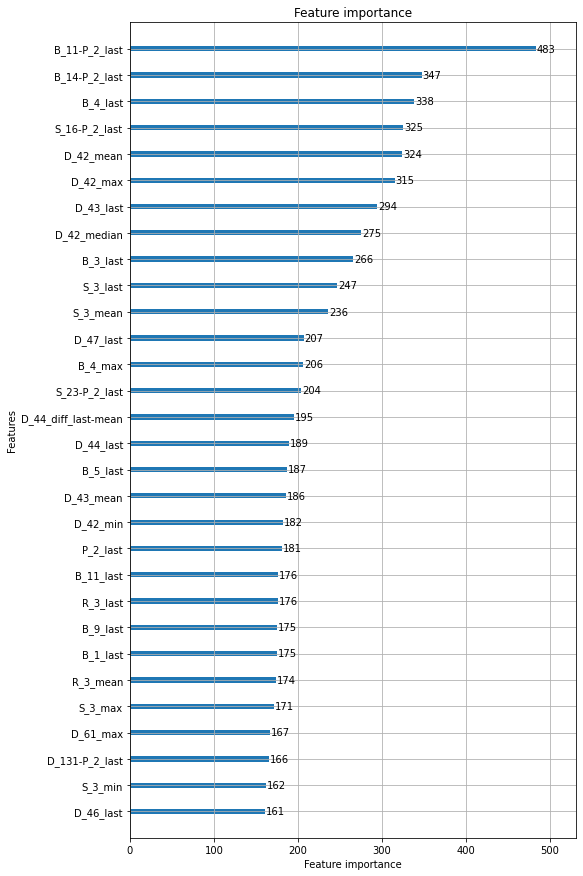

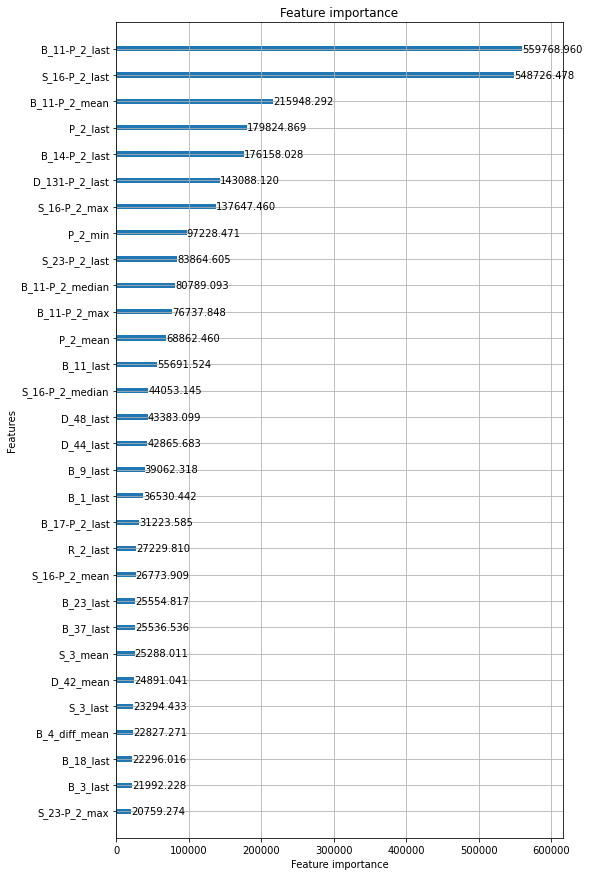

######################################## training model 5/5 ########################################
seed: 19


[50]	valid_0's amex_metric: 0.750886	valid_0's recall_at4: 0.601094	valid_0's norm_gini: 0.900678


[100]	valid_0's amex_metric: 0.759617	valid_0's recall_at4: 0.612918	valid_0's norm_gini: 0.906316


[150]	valid_0's amex_metric: 0.766473	valid_0's recall_at4: 0.622512	valid_0's norm_gini: 0.910435


[200]	valid_0's amex_metric: 0.771704	valid_0's recall_at4: 0.630086	valid_0's norm_gini: 0.913321


[250]	valid_0's amex_metric: 0.776504	valid_0's recall_at4: 0.637534	valid_0's norm_gini: 0.915473


[300]	valid_0's amex_metric: 0.779814	valid_0's recall_at4: 0.64271	valid_0's norm_gini: 0.916919


[350]	valid_0's amex_metric: 0.780371	valid_0's recall_at4: 0.642878	valid_0's norm_gini: 0.917864


[400]	valid_0's amex_metric: 0.78261	valid_0's recall_at4: 0.646329	valid_0's norm_gini: 0.91889


[450]	valid_0's amex_metric: 0.783516	valid_0's recall_at4: 0.647549	valid_0's norm_gini: 0.919482


[500]	valid_0's amex_metric: 0.784675	valid_0's recall_at4: 0.649148	valid_0's norm_gini: 0.920202


[550]	valid_0's amex_metric: 0.785398	valid_0's recall_at4: 0.650116	valid_0's norm_gini: 0.920681


[600]	valid_0's amex_metric: 0.785568	valid_0's recall_at4: 0.650158	valid_0's norm_gini: 0.920978


[650]	valid_0's amex_metric: 0.786134	valid_0's recall_at4: 0.650999	valid_0's norm_gini: 0.921268


[700]	valid_0's amex_metric: 0.787041	valid_0's recall_at4: 0.652598	valid_0's norm_gini: 0.921485


[750]	valid_0's amex_metric: 0.788582	valid_0's recall_at4: 0.655502	valid_0's norm_gini: 0.921662


[800]	valid_0's amex_metric: 0.788223	valid_0's recall_at4: 0.65466	valid_0's norm_gini: 0.921785


[850]	valid_0's amex_metric: 0.788315	valid_0's recall_at4: 0.65466	valid_0's norm_gini: 0.92197


[900]	valid_0's amex_metric: 0.788533	valid_0's recall_at4: 0.654913	valid_0's norm_gini: 0.922154


[950]	valid_0's amex_metric: 0.78917	valid_0's recall_at4: 0.655965	valid_0's norm_gini: 0.922376


[1000]	valid_0's amex_metric: 0.78928	valid_0's recall_at4: 0.656007	valid_0's norm_gini: 0.922553


[1050]	valid_0's amex_metric: 0.789016	valid_0's recall_at4: 0.655249	valid_0's norm_gini: 0.922782


[1100]	valid_0's amex_metric: 0.789562	valid_0's recall_at4: 0.656175	valid_0's norm_gini: 0.922948


[1150]	valid_0's amex_metric: 0.789267	valid_0's recall_at4: 0.655418	valid_0's norm_gini: 0.923116


[1200]	valid_0's amex_metric: 0.78948	valid_0's recall_at4: 0.655754	valid_0's norm_gini: 0.923206


[1250]	valid_0's amex_metric: 0.789987	valid_0's recall_at4: 0.65668	valid_0's norm_gini: 0.923294


[1300]	valid_0's amex_metric: 0.790419	valid_0's recall_at4: 0.657479	valid_0's norm_gini: 0.923359


[1350]	valid_0's amex_metric: 0.789928	valid_0's recall_at4: 0.656385	valid_0's norm_gini: 0.92347


[1400]	valid_0's amex_metric: 0.790449	valid_0's recall_at4: 0.657311	valid_0's norm_gini: 0.923587


[1450]	valid_0's amex_metric: 0.790723	valid_0's recall_at4: 0.657774	valid_0's norm_gini: 0.923673


[1500]	valid_0's amex_metric: 0.791139	valid_0's recall_at4: 0.658489	valid_0's norm_gini: 0.923788


[1550]	valid_0's amex_metric: 0.791407	valid_0's recall_at4: 0.658952	valid_0's norm_gini: 0.923862


[1600]	valid_0's amex_metric: 0.791393	valid_0's recall_at4: 0.658868	valid_0's norm_gini: 0.923919


[1650]	valid_0's amex_metric: 0.791683	valid_0's recall_at4: 0.659373	valid_0's norm_gini: 0.923993


[1700]	valid_0's amex_metric: 0.79157	valid_0's recall_at4: 0.659121	valid_0's norm_gini: 0.924019


[1750]	valid_0's amex_metric: 0.790994	valid_0's recall_at4: 0.6579	valid_0's norm_gini: 0.924087


[1800]	valid_0's amex_metric: 0.791216	valid_0's recall_at4: 0.658321	valid_0's norm_gini: 0.924111


[1850]	valid_0's amex_metric: 0.791115	valid_0's recall_at4: 0.658111	valid_0's norm_gini: 0.924119


[1900]	valid_0's amex_metric: 0.79123	valid_0's recall_at4: 0.658279	valid_0's norm_gini: 0.924182


[1950]	valid_0's amex_metric: 0.791776	valid_0's recall_at4: 0.659331	valid_0's norm_gini: 0.924221


[2000]	valid_0's amex_metric: 0.791685	valid_0's recall_at4: 0.659121	valid_0's norm_gini: 0.924249


[2050]	valid_0's amex_metric: 0.791837	valid_0's recall_at4: 0.659415	valid_0's norm_gini: 0.924259


[2100]	valid_0's amex_metric: 0.791824	valid_0's recall_at4: 0.659373	valid_0's norm_gini: 0.924274


[2150]	valid_0's amex_metric: 0.792045	valid_0's recall_at4: 0.659794	valid_0's norm_gini: 0.924296


[2200]	valid_0's amex_metric: 0.792547	valid_0's recall_at4: 0.660762	valid_0's norm_gini: 0.924333


[2250]	valid_0's amex_metric: 0.792637	valid_0's recall_at4: 0.66093	valid_0's norm_gini: 0.924345


[2300]	valid_0's amex_metric: 0.792889	valid_0's recall_at4: 0.661393	valid_0's norm_gini: 0.924385


[2350]	valid_0's amex_metric: 0.793236	valid_0's recall_at4: 0.662066	valid_0's norm_gini: 0.924406


[2400]	valid_0's amex_metric: 0.792956	valid_0's recall_at4: 0.661477	valid_0's norm_gini: 0.924435


[2450]	valid_0's amex_metric: 0.792895	valid_0's recall_at4: 0.661351	valid_0's norm_gini: 0.92444


[2500]	valid_0's amex_metric: 0.793201	valid_0's recall_at4: 0.66194	valid_0's norm_gini: 0.924461


[2550]	valid_0's amex_metric: 0.792476	valid_0's recall_at4: 0.660467	valid_0's norm_gini: 0.924486


[2600]	valid_0's amex_metric: 0.792462	valid_0's recall_at4: 0.660425	valid_0's norm_gini: 0.924499


[2650]	valid_0's amex_metric: 0.792342	valid_0's recall_at4: 0.660173	valid_0's norm_gini: 0.924512


[2700]	valid_0's amex_metric: 0.792432	valid_0's recall_at4: 0.660341	valid_0's norm_gini: 0.924523


[2750]	valid_0's amex_metric: 0.792667	valid_0's recall_at4: 0.660804	valid_0's norm_gini: 0.924531


[2800]	valid_0's amex_metric: 0.792505	valid_0's recall_at4: 0.660467	valid_0's norm_gini: 0.924542


[2850]	valid_0's amex_metric: 0.792714	valid_0's recall_at4: 0.660888	valid_0's norm_gini: 0.924541


[2900]	valid_0's amex_metric: 0.792936	valid_0's recall_at4: 0.661309	valid_0's norm_gini: 0.924564


[2950]	valid_0's amex_metric: 0.792722	valid_0's recall_at4: 0.660888	valid_0's norm_gini: 0.924555


[3000]	valid_0's amex_metric: 0.792273	valid_0's recall_at4: 0.660004	valid_0's norm_gini: 0.924543


[3050]	valid_0's amex_metric: 0.792629	valid_0's recall_at4: 0.66072	valid_0's norm_gini: 0.924539


[3100]	valid_0's amex_metric: 0.792497	valid_0's recall_at4: 0.660467	valid_0's norm_gini: 0.924527


[3150]	valid_0's amex_metric: 0.792685	valid_0's recall_at4: 0.660846	valid_0's norm_gini: 0.924525


[3200]	valid_0's amex_metric: 0.792617	valid_0's recall_at4: 0.66072	valid_0's norm_gini: 0.924513


[3250]	valid_0's amex_metric: 0.792556	valid_0's recall_at4: 0.660593	valid_0's norm_gini: 0.924518


[3300]	valid_0's amex_metric: 0.792575	valid_0's recall_at4: 0.660635	valid_0's norm_gini: 0.924515


[3350]	valid_0's amex_metric: 0.792487	valid_0's recall_at4: 0.660467	valid_0's norm_gini: 0.924507


[3400]	valid_0's amex_metric: 0.792306	valid_0's recall_at4: 0.660088	valid_0's norm_gini: 0.924523


[3450]	valid_0's amex_metric: 0.79257	valid_0's recall_at4: 0.660593	valid_0's norm_gini: 0.924547


[3500]	valid_0's amex_metric: 0.792251	valid_0's recall_at4: 0.659962	valid_0's norm_gini: 0.92454


[3550]	valid_0's amex_metric: 0.792272	valid_0's recall_at4: 0.659962	valid_0's norm_gini: 0.924581


[3600]	valid_0's amex_metric: 0.792344	valid_0's recall_at4: 0.660088	valid_0's norm_gini: 0.9246


[3650]	valid_0's amex_metric: 0.792848	valid_0's recall_at4: 0.661098	valid_0's norm_gini: 0.924597


[3700]	valid_0's amex_metric: 0.792698	valid_0's recall_at4: 0.660804	valid_0's norm_gini: 0.924592


[3750]	valid_0's amex_metric: 0.792758	valid_0's recall_at4: 0.66093	valid_0's norm_gini: 0.924586


[3800]	valid_0's amex_metric: 0.79284	valid_0's recall_at4: 0.661098	valid_0's norm_gini: 0.924582


[3850]	valid_0's amex_metric: 0.792692	valid_0's recall_at4: 0.660804	valid_0's norm_gini: 0.92458


[3900]	valid_0's amex_metric: 0.793052	valid_0's recall_at4: 0.661519	valid_0's norm_gini: 0.924585


[3950]	valid_0's amex_metric: 0.79335	valid_0's recall_at4: 0.662108	valid_0's norm_gini: 0.924592


[4000]	valid_0's amex_metric: 0.793122	valid_0's recall_at4: 0.661645	valid_0's norm_gini: 0.924598


[4050]	valid_0's amex_metric: 0.792988	valid_0's recall_at4: 0.661351	valid_0's norm_gini: 0.924625


[4100]	valid_0's amex_metric: 0.792706	valid_0's recall_at4: 0.660804	valid_0's norm_gini: 0.924608


[4150]	valid_0's amex_metric: 0.792807	valid_0's recall_at4: 0.661014	valid_0's norm_gini: 0.9246


[4200]	valid_0's amex_metric: 0.792449	valid_0's recall_at4: 0.660299	valid_0's norm_gini: 0.924598


[4250]	valid_0's amex_metric: 0.792694	valid_0's recall_at4: 0.660804	valid_0's norm_gini: 0.924585


[4300]	valid_0's amex_metric: 0.792532	valid_0's recall_at4: 0.660467	valid_0's norm_gini: 0.924597


[4350]	valid_0's amex_metric: 0.792758	valid_0's recall_at4: 0.66093	valid_0's norm_gini: 0.924586


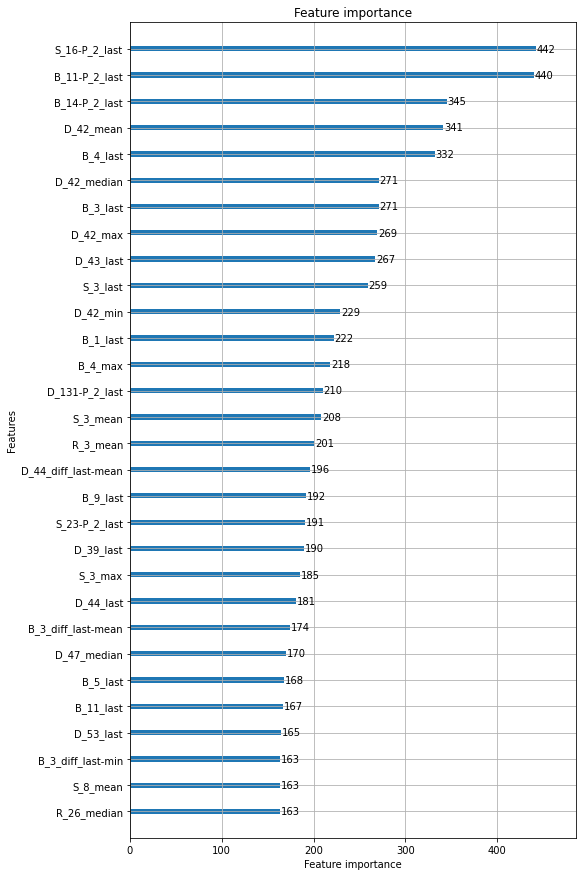

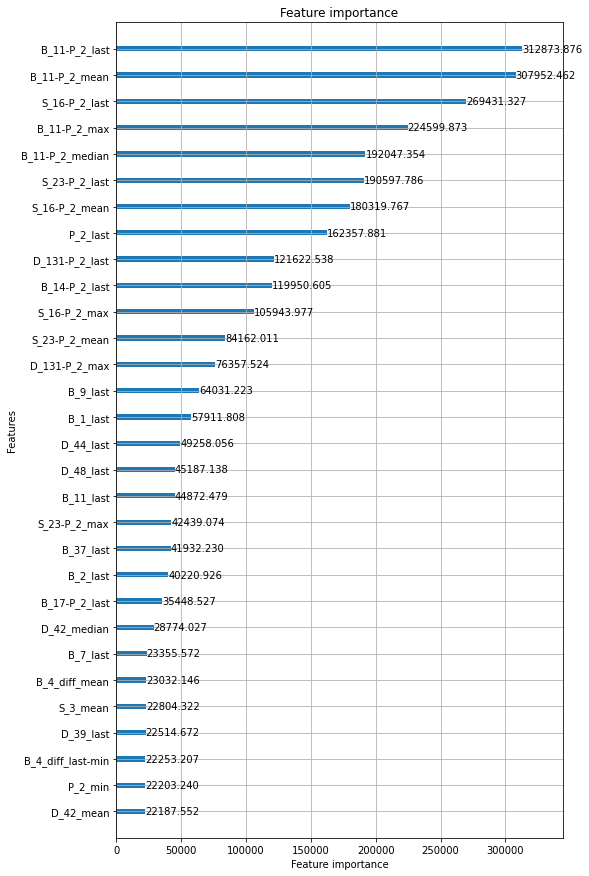

Training time: 34.01807965040207 min.
OOF recall_at4: 0.6673258827885683
OOF normalized_gini: 0.9253152468611413
OOF competition metric: 0.7963205648248548


############################### repeated cross-validation step: 5/5 ################################


######################################## training model 1/5 ########################################
seed: 20


[50]	valid_0's amex_metric: 0.7515	valid_0's recall_at4: 0.60271	valid_0's norm_gini: 0.90029


[100]	valid_0's amex_metric: 0.758188	valid_0's recall_at4: 0.611125	valid_0's norm_gini: 0.905251


[150]	valid_0's amex_metric: 0.764073	valid_0's recall_at4: 0.620045	valid_0's norm_gini: 0.908101


[200]	valid_0's amex_metric: 0.767204	valid_0's recall_at4: 0.623874	valid_0's norm_gini: 0.910533


[250]	valid_0's amex_metric: 0.772547	valid_0's recall_at4: 0.63149	valid_0's norm_gini: 0.913604


[300]	valid_0's amex_metric: 0.77782	valid_0's recall_at4: 0.639864	valid_0's norm_gini: 0.915776


[350]	valid_0's amex_metric: 0.780686	valid_0's recall_at4: 0.64424	valid_0's norm_gini: 0.917132


[400]	valid_0's amex_metric: 0.783703	valid_0's recall_at4: 0.648742	valid_0's norm_gini: 0.918664


[450]	valid_0's amex_metric: 0.785711	valid_0's recall_at4: 0.651982	valid_0's norm_gini: 0.91944


[500]	valid_0's amex_metric: 0.787844	valid_0's recall_at4: 0.655264	valid_0's norm_gini: 0.920425


[550]	valid_0's amex_metric: 0.789204	valid_0's recall_at4: 0.65741	valid_0's norm_gini: 0.920999


[600]	valid_0's amex_metric: 0.791084	valid_0's recall_at4: 0.660523	valid_0's norm_gini: 0.921646


[650]	valid_0's amex_metric: 0.791331	valid_0's recall_at4: 0.660692	valid_0's norm_gini: 0.921971


[700]	valid_0's amex_metric: 0.791915	valid_0's recall_at4: 0.661575	valid_0's norm_gini: 0.922255


[750]	valid_0's amex_metric: 0.792467	valid_0's recall_at4: 0.662291	valid_0's norm_gini: 0.922643


[800]	valid_0's amex_metric: 0.793909	valid_0's recall_at4: 0.664857	valid_0's norm_gini: 0.92296


[850]	valid_0's amex_metric: 0.794742	valid_0's recall_at4: 0.666204	valid_0's norm_gini: 0.923279


[900]	valid_0's amex_metric: 0.795522	valid_0's recall_at4: 0.667508	valid_0's norm_gini: 0.923535


[950]	valid_0's amex_metric: 0.795529	valid_0's recall_at4: 0.66734	valid_0's norm_gini: 0.923718


[1000]	valid_0's amex_metric: 0.796142	valid_0's recall_at4: 0.668392	valid_0's norm_gini: 0.923891


[1050]	valid_0's amex_metric: 0.796473	valid_0's recall_at4: 0.668897	valid_0's norm_gini: 0.924049


[1100]	valid_0's amex_metric: 0.796694	valid_0's recall_at4: 0.669191	valid_0's norm_gini: 0.924197


[1150]	valid_0's amex_metric: 0.797221	valid_0's recall_at4: 0.670075	valid_0's norm_gini: 0.924368


[1200]	valid_0's amex_metric: 0.797381	valid_0's recall_at4: 0.670243	valid_0's norm_gini: 0.924519


[1250]	valid_0's amex_metric: 0.797334	valid_0's recall_at4: 0.670033	valid_0's norm_gini: 0.924635


[1300]	valid_0's amex_metric: 0.797971	valid_0's recall_at4: 0.671211	valid_0's norm_gini: 0.924732


[1350]	valid_0's amex_metric: 0.797508	valid_0's recall_at4: 0.670159	valid_0's norm_gini: 0.924856


[1400]	valid_0's amex_metric: 0.79739	valid_0's recall_at4: 0.669865	valid_0's norm_gini: 0.924916


[1450]	valid_0's amex_metric: 0.797508	valid_0's recall_at4: 0.670033	valid_0's norm_gini: 0.924982


[1500]	valid_0's amex_metric: 0.797744	valid_0's recall_at4: 0.670454	valid_0's norm_gini: 0.925034


[1550]	valid_0's amex_metric: 0.79785	valid_0's recall_at4: 0.670622	valid_0's norm_gini: 0.925079


[1600]	valid_0's amex_metric: 0.798173	valid_0's recall_at4: 0.671211	valid_0's norm_gini: 0.925136


[1650]	valid_0's amex_metric: 0.798144	valid_0's recall_at4: 0.671085	valid_0's norm_gini: 0.925204


[1700]	valid_0's amex_metric: 0.798516	valid_0's recall_at4: 0.671758	valid_0's norm_gini: 0.925273


[1750]	valid_0's amex_metric: 0.798336	valid_0's recall_at4: 0.671337	valid_0's norm_gini: 0.925334


[1800]	valid_0's amex_metric: 0.798591	valid_0's recall_at4: 0.6718	valid_0's norm_gini: 0.925383


[1850]	valid_0's amex_metric: 0.798233	valid_0's recall_at4: 0.671043	valid_0's norm_gini: 0.925423


[1900]	valid_0's amex_metric: 0.798318	valid_0's recall_at4: 0.671169	valid_0's norm_gini: 0.925468


[1950]	valid_0's amex_metric: 0.798336	valid_0's recall_at4: 0.671169	valid_0's norm_gini: 0.925504


[2000]	valid_0's amex_metric: 0.798086	valid_0's recall_at4: 0.670664	valid_0's norm_gini: 0.925507


[2050]	valid_0's amex_metric: 0.798377	valid_0's recall_at4: 0.671211	valid_0's norm_gini: 0.925543


[2100]	valid_0's amex_metric: 0.798037	valid_0's recall_at4: 0.670538	valid_0's norm_gini: 0.925537


[2150]	valid_0's amex_metric: 0.798595	valid_0's recall_at4: 0.671632	valid_0's norm_gini: 0.925558


[2200]	valid_0's amex_metric: 0.798618	valid_0's recall_at4: 0.671674	valid_0's norm_gini: 0.925562


[2250]	valid_0's amex_metric: 0.79851	valid_0's recall_at4: 0.671421	valid_0's norm_gini: 0.925599


[2300]	valid_0's amex_metric: 0.799056	valid_0's recall_at4: 0.672473	valid_0's norm_gini: 0.925638


[2350]	valid_0's amex_metric: 0.798689	valid_0's recall_at4: 0.671716	valid_0's norm_gini: 0.925663


[2400]	valid_0's amex_metric: 0.799366	valid_0's recall_at4: 0.673062	valid_0's norm_gini: 0.925669


[2450]	valid_0's amex_metric: 0.799437	valid_0's recall_at4: 0.673189	valid_0's norm_gini: 0.925686


[2500]	valid_0's amex_metric: 0.79892	valid_0's recall_at4: 0.672137	valid_0's norm_gini: 0.925704


[2550]	valid_0's amex_metric: 0.798711	valid_0's recall_at4: 0.671716	valid_0's norm_gini: 0.925706


[2600]	valid_0's amex_metric: 0.798833	valid_0's recall_at4: 0.671968	valid_0's norm_gini: 0.925697


[2650]	valid_0's amex_metric: 0.799129	valid_0's recall_at4: 0.672557	valid_0's norm_gini: 0.925701


[2700]	valid_0's amex_metric: 0.79895	valid_0's recall_at4: 0.672179	valid_0's norm_gini: 0.925721


[2750]	valid_0's amex_metric: 0.799113	valid_0's recall_at4: 0.672473	valid_0's norm_gini: 0.925752


[2800]	valid_0's amex_metric: 0.798682	valid_0's recall_at4: 0.67159	valid_0's norm_gini: 0.925774


[2850]	valid_0's amex_metric: 0.798744	valid_0's recall_at4: 0.671716	valid_0's norm_gini: 0.925773


[2900]	valid_0's amex_metric: 0.798418	valid_0's recall_at4: 0.671043	valid_0's norm_gini: 0.925793


[2950]	valid_0's amex_metric: 0.798343	valid_0's recall_at4: 0.670874	valid_0's norm_gini: 0.925812


[3000]	valid_0's amex_metric: 0.798365	valid_0's recall_at4: 0.670874	valid_0's norm_gini: 0.925855


[3050]	valid_0's amex_metric: 0.798623	valid_0's recall_at4: 0.671379	valid_0's norm_gini: 0.925866


[3100]	valid_0's amex_metric: 0.799194	valid_0's recall_at4: 0.672515	valid_0's norm_gini: 0.925874


[3150]	valid_0's amex_metric: 0.799152	valid_0's recall_at4: 0.672431	valid_0's norm_gini: 0.925873


[3200]	valid_0's amex_metric: 0.799642	valid_0's recall_at4: 0.673399	valid_0's norm_gini: 0.925886


[3250]	valid_0's amex_metric: 0.799181	valid_0's recall_at4: 0.672473	valid_0's norm_gini: 0.925888


[3300]	valid_0's amex_metric: 0.798882	valid_0's recall_at4: 0.671842	valid_0's norm_gini: 0.925921


[3350]	valid_0's amex_metric: 0.799605	valid_0's recall_at4: 0.673273	valid_0's norm_gini: 0.925937


[3400]	valid_0's amex_metric: 0.799185	valid_0's recall_at4: 0.672431	valid_0's norm_gini: 0.925939


[3450]	valid_0's amex_metric: 0.799689	valid_0's recall_at4: 0.673441	valid_0's norm_gini: 0.925937


[3500]	valid_0's amex_metric: 0.799461	valid_0's recall_at4: 0.672978	valid_0's norm_gini: 0.925943


[3550]	valid_0's amex_metric: 0.799773	valid_0's recall_at4: 0.673609	valid_0's norm_gini: 0.925937


[3600]	valid_0's amex_metric: 0.799214	valid_0's recall_at4: 0.672473	valid_0's norm_gini: 0.925955


[3650]	valid_0's amex_metric: 0.799414	valid_0's recall_at4: 0.672852	valid_0's norm_gini: 0.925975


[3700]	valid_0's amex_metric: 0.799644	valid_0's recall_at4: 0.673315	valid_0's norm_gini: 0.925974


[3750]	valid_0's amex_metric: 0.799457	valid_0's recall_at4: 0.672936	valid_0's norm_gini: 0.925978


[3800]	valid_0's amex_metric: 0.799423	valid_0's recall_at4: 0.672852	valid_0's norm_gini: 0.925993


[3850]	valid_0's amex_metric: 0.799151	valid_0's recall_at4: 0.672305	valid_0's norm_gini: 0.925997


[3900]	valid_0's amex_metric: 0.799122	valid_0's recall_at4: 0.672221	valid_0's norm_gini: 0.926023


[3950]	valid_0's amex_metric: 0.799166	valid_0's recall_at4: 0.672305	valid_0's norm_gini: 0.926026


[4000]	valid_0's amex_metric: 0.799218	valid_0's recall_at4: 0.672431	valid_0's norm_gini: 0.926004


[4050]	valid_0's amex_metric: 0.799036	valid_0's recall_at4: 0.672095	valid_0's norm_gini: 0.925977


[4100]	valid_0's amex_metric: 0.799162	valid_0's recall_at4: 0.672347	valid_0's norm_gini: 0.925977


[4150]	valid_0's amex_metric: 0.799064	valid_0's recall_at4: 0.672137	valid_0's norm_gini: 0.925992


[4200]	valid_0's amex_metric: 0.799289	valid_0's recall_at4: 0.672599	valid_0's norm_gini: 0.925978


[4250]	valid_0's amex_metric: 0.799263	valid_0's recall_at4: 0.672557	valid_0's norm_gini: 0.925968


[4300]	valid_0's amex_metric: 0.799528	valid_0's recall_at4: 0.673104	valid_0's norm_gini: 0.925952


[4350]	valid_0's amex_metric: 0.798936	valid_0's recall_at4: 0.671926	valid_0's norm_gini: 0.925946


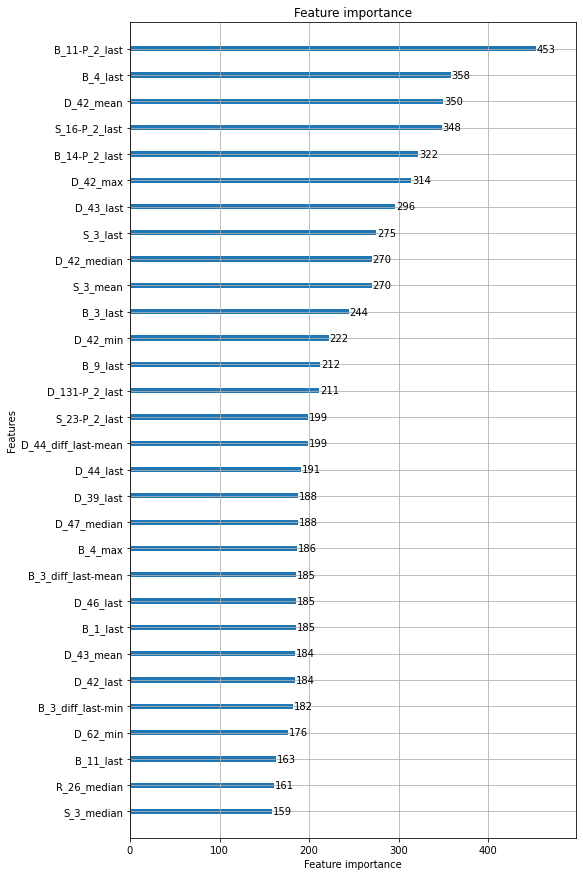

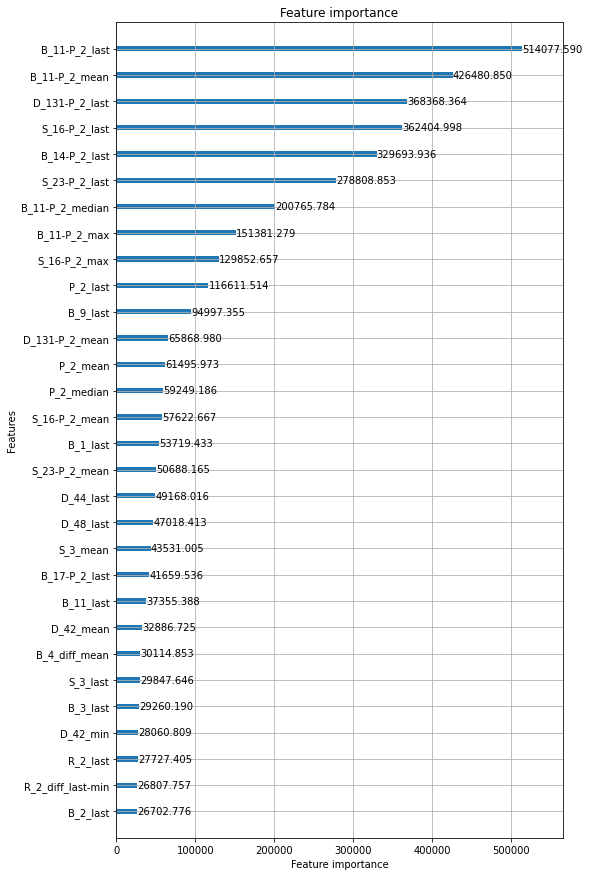

######################################## training model 2/5 ########################################
seed: 21


[50]	valid_0's amex_metric: 0.754359	valid_0's recall_at4: 0.607591	valid_0's norm_gini: 0.901128


[100]	valid_0's amex_metric: 0.770654	valid_0's recall_at4: 0.631953	valid_0's norm_gini: 0.909355


[150]	valid_0's amex_metric: 0.774155	valid_0's recall_at4: 0.635866	valid_0's norm_gini: 0.912445


[200]	valid_0's amex_metric: 0.777784	valid_0's recall_at4: 0.640495	valid_0's norm_gini: 0.915074


[250]	valid_0's amex_metric: 0.780189	valid_0's recall_at4: 0.643398	valid_0's norm_gini: 0.916979


[300]	valid_0's amex_metric: 0.784045	valid_0's recall_at4: 0.648994	valid_0's norm_gini: 0.919095


[350]	valid_0's amex_metric: 0.7853	valid_0's recall_at4: 0.650677	valid_0's norm_gini: 0.919923


[400]	valid_0's amex_metric: 0.786557	valid_0's recall_at4: 0.65236	valid_0's norm_gini: 0.920754


[450]	valid_0's amex_metric: 0.789009	valid_0's recall_at4: 0.656442	valid_0's norm_gini: 0.921576


[500]	valid_0's amex_metric: 0.790244	valid_0's recall_at4: 0.658251	valid_0's norm_gini: 0.922236


[550]	valid_0's amex_metric: 0.791436	valid_0's recall_at4: 0.659976	valid_0's norm_gini: 0.922896


[600]	valid_0's amex_metric: 0.79159	valid_0's recall_at4: 0.65985	valid_0's norm_gini: 0.92333


[650]	valid_0's amex_metric: 0.793109	valid_0's recall_at4: 0.662459	valid_0's norm_gini: 0.923758


[700]	valid_0's amex_metric: 0.794061	valid_0's recall_at4: 0.664142	valid_0's norm_gini: 0.923979


[750]	valid_0's amex_metric: 0.794424	valid_0's recall_at4: 0.664563	valid_0's norm_gini: 0.924285


[800]	valid_0's amex_metric: 0.794729	valid_0's recall_at4: 0.664984	valid_0's norm_gini: 0.924474


[850]	valid_0's amex_metric: 0.794477	valid_0's recall_at4: 0.66431	valid_0's norm_gini: 0.924643


[900]	valid_0's amex_metric: 0.794775	valid_0's recall_at4: 0.664731	valid_0's norm_gini: 0.924819


[950]	valid_0's amex_metric: 0.795589	valid_0's recall_at4: 0.666162	valid_0's norm_gini: 0.925016


[1000]	valid_0's amex_metric: 0.79671	valid_0's recall_at4: 0.668224	valid_0's norm_gini: 0.925196


[1050]	valid_0's amex_metric: 0.796791	valid_0's recall_at4: 0.668266	valid_0's norm_gini: 0.925317


[1100]	valid_0's amex_metric: 0.797269	valid_0's recall_at4: 0.669149	valid_0's norm_gini: 0.925389


[1150]	valid_0's amex_metric: 0.796788	valid_0's recall_at4: 0.668055	valid_0's norm_gini: 0.925521


[1200]	valid_0's amex_metric: 0.796747	valid_0's recall_at4: 0.667845	valid_0's norm_gini: 0.92565


[1250]	valid_0's amex_metric: 0.796489	valid_0's recall_at4: 0.667214	valid_0's norm_gini: 0.925763


[1300]	valid_0's amex_metric: 0.796248	valid_0's recall_at4: 0.666667	valid_0's norm_gini: 0.92583


[1350]	valid_0's amex_metric: 0.796628	valid_0's recall_at4: 0.667382	valid_0's norm_gini: 0.925873


[1400]	valid_0's amex_metric: 0.796438	valid_0's recall_at4: 0.666961	valid_0's norm_gini: 0.925915


[1450]	valid_0's amex_metric: 0.797141	valid_0's recall_at4: 0.668266	valid_0's norm_gini: 0.926016


[1500]	valid_0's amex_metric: 0.797351	valid_0's recall_at4: 0.668644	valid_0's norm_gini: 0.926059


[1550]	valid_0's amex_metric: 0.797555	valid_0's recall_at4: 0.668981	valid_0's norm_gini: 0.926129


[1600]	valid_0's amex_metric: 0.798023	valid_0's recall_at4: 0.669865	valid_0's norm_gini: 0.926181


[1650]	valid_0's amex_metric: 0.797708	valid_0's recall_at4: 0.669191	valid_0's norm_gini: 0.926224


[1700]	valid_0's amex_metric: 0.79787	valid_0's recall_at4: 0.669444	valid_0's norm_gini: 0.926296


[1750]	valid_0's amex_metric: 0.798147	valid_0's recall_at4: 0.669949	valid_0's norm_gini: 0.926345


[1800]	valid_0's amex_metric: 0.798113	valid_0's recall_at4: 0.669822	valid_0's norm_gini: 0.926404


[1850]	valid_0's amex_metric: 0.798145	valid_0's recall_at4: 0.669822	valid_0's norm_gini: 0.926467


[1900]	valid_0's amex_metric: 0.798838	valid_0's recall_at4: 0.671169	valid_0's norm_gini: 0.926506


[1950]	valid_0's amex_metric: 0.798463	valid_0's recall_at4: 0.670412	valid_0's norm_gini: 0.926514


[2000]	valid_0's amex_metric: 0.798699	valid_0's recall_at4: 0.670874	valid_0's norm_gini: 0.926524


[2050]	valid_0's amex_metric: 0.798734	valid_0's recall_at4: 0.670916	valid_0's norm_gini: 0.926552


[2100]	valid_0's amex_metric: 0.798736	valid_0's recall_at4: 0.670874	valid_0's norm_gini: 0.926597


[2150]	valid_0's amex_metric: 0.79839	valid_0's recall_at4: 0.670159	valid_0's norm_gini: 0.926621


[2200]	valid_0's amex_metric: 0.798792	valid_0's recall_at4: 0.670916	valid_0's norm_gini: 0.926668


[2250]	valid_0's amex_metric: 0.798998	valid_0's recall_at4: 0.671295	valid_0's norm_gini: 0.9267


[2300]	valid_0's amex_metric: 0.799311	valid_0's recall_at4: 0.671884	valid_0's norm_gini: 0.926738


[2350]	valid_0's amex_metric: 0.79881	valid_0's recall_at4: 0.670874	valid_0's norm_gini: 0.926746


[2400]	valid_0's amex_metric: 0.798878	valid_0's recall_at4: 0.671001	valid_0's norm_gini: 0.926754


[2450]	valid_0's amex_metric: 0.799043	valid_0's recall_at4: 0.671295	valid_0's norm_gini: 0.926791


[2500]	valid_0's amex_metric: 0.799516	valid_0's recall_at4: 0.672221	valid_0's norm_gini: 0.926811


[2550]	valid_0's amex_metric: 0.799571	valid_0's recall_at4: 0.672305	valid_0's norm_gini: 0.926837


[2600]	valid_0's amex_metric: 0.799517	valid_0's recall_at4: 0.672179	valid_0's norm_gini: 0.926854


[2650]	valid_0's amex_metric: 0.799175	valid_0's recall_at4: 0.671506	valid_0's norm_gini: 0.926845


[2700]	valid_0's amex_metric: 0.79912	valid_0's recall_at4: 0.671379	valid_0's norm_gini: 0.926861


[2750]	valid_0's amex_metric: 0.799543	valid_0's recall_at4: 0.672221	valid_0's norm_gini: 0.926866


[2800]	valid_0's amex_metric: 0.799568	valid_0's recall_at4: 0.672263	valid_0's norm_gini: 0.926874


[2850]	valid_0's amex_metric: 0.799728	valid_0's recall_at4: 0.672557	valid_0's norm_gini: 0.926899


[2900]	valid_0's amex_metric: 0.799394	valid_0's recall_at4: 0.671884	valid_0's norm_gini: 0.926904


[2950]	valid_0's amex_metric: 0.799452	valid_0's recall_at4: 0.67201	valid_0's norm_gini: 0.926894


[3000]	valid_0's amex_metric: 0.799855	valid_0's recall_at4: 0.67281	valid_0's norm_gini: 0.9269


[3050]	valid_0's amex_metric: 0.799528	valid_0's recall_at4: 0.672137	valid_0's norm_gini: 0.926918


[3100]	valid_0's amex_metric: 0.799799	valid_0's recall_at4: 0.672684	valid_0's norm_gini: 0.926915


[3150]	valid_0's amex_metric: 0.799615	valid_0's recall_at4: 0.672305	valid_0's norm_gini: 0.926925


[3200]	valid_0's amex_metric: 0.799642	valid_0's recall_at4: 0.672347	valid_0's norm_gini: 0.926937


[3250]	valid_0's amex_metric: 0.799732	valid_0's recall_at4: 0.672515	valid_0's norm_gini: 0.926948


[3300]	valid_0's amex_metric: 0.799586	valid_0's recall_at4: 0.672221	valid_0's norm_gini: 0.926951


[3350]	valid_0's amex_metric: 0.799839	valid_0's recall_at4: 0.672726	valid_0's norm_gini: 0.926953


[3400]	valid_0's amex_metric: 0.799478	valid_0's recall_at4: 0.67201	valid_0's norm_gini: 0.926946


[3450]	valid_0's amex_metric: 0.799706	valid_0's recall_at4: 0.672473	valid_0's norm_gini: 0.926938


[3500]	valid_0's amex_metric: 0.799367	valid_0's recall_at4: 0.6718	valid_0's norm_gini: 0.926934


[3550]	valid_0's amex_metric: 0.799323	valid_0's recall_at4: 0.671716	valid_0's norm_gini: 0.92693


[3600]	valid_0's amex_metric: 0.799321	valid_0's recall_at4: 0.671716	valid_0's norm_gini: 0.926926


[3650]	valid_0's amex_metric: 0.799373	valid_0's recall_at4: 0.6718	valid_0's norm_gini: 0.926946


[3700]	valid_0's amex_metric: 0.79957	valid_0's recall_at4: 0.672179	valid_0's norm_gini: 0.926962


[3750]	valid_0's amex_metric: 0.799907	valid_0's recall_at4: 0.672852	valid_0's norm_gini: 0.926961


[3800]	valid_0's amex_metric: 0.799609	valid_0's recall_at4: 0.672263	valid_0's norm_gini: 0.926955


[3850]	valid_0's amex_metric: 0.799831	valid_0's recall_at4: 0.672684	valid_0's norm_gini: 0.926978


[3900]	valid_0's amex_metric: 0.799687	valid_0's recall_at4: 0.672389	valid_0's norm_gini: 0.926986


[3950]	valid_0's amex_metric: 0.79982	valid_0's recall_at4: 0.672642	valid_0's norm_gini: 0.926998


[4000]	valid_0's amex_metric: 0.800005	valid_0's recall_at4: 0.67302	valid_0's norm_gini: 0.926991


[4050]	valid_0's amex_metric: 0.799898	valid_0's recall_at4: 0.67281	valid_0's norm_gini: 0.926985


[4100]	valid_0's amex_metric: 0.799366	valid_0's recall_at4: 0.671758	valid_0's norm_gini: 0.926973


[4150]	valid_0's amex_metric: 0.799879	valid_0's recall_at4: 0.672768	valid_0's norm_gini: 0.92699


[4200]	valid_0's amex_metric: 0.799635	valid_0's recall_at4: 0.672263	valid_0's norm_gini: 0.927006


[4250]	valid_0's amex_metric: 0.799401	valid_0's recall_at4: 0.6718	valid_0's norm_gini: 0.927001


[4300]	valid_0's amex_metric: 0.799672	valid_0's recall_at4: 0.672347	valid_0's norm_gini: 0.926997


[4350]	valid_0's amex_metric: 0.799501	valid_0's recall_at4: 0.67201	valid_0's norm_gini: 0.926992


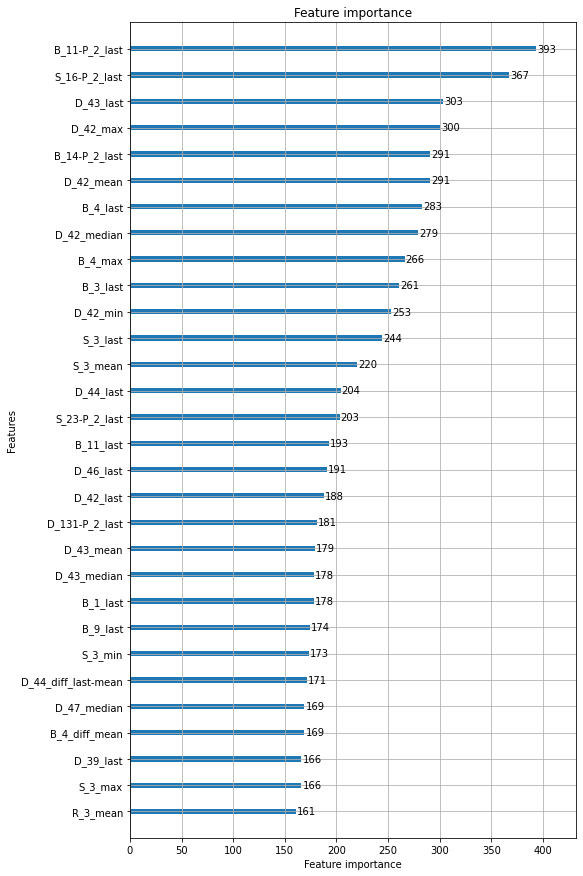

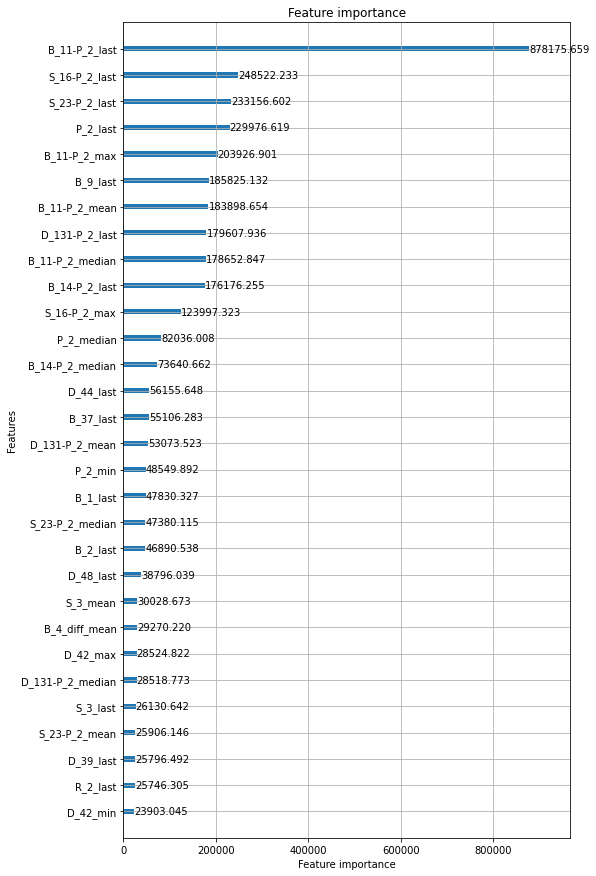

######################################## training model 3/5 ########################################
seed: 22


[50]	valid_0's amex_metric: 0.752736	valid_0's recall_at4: 0.603678	valid_0's norm_gini: 0.901794


[100]	valid_0's amex_metric: 0.759927	valid_0's recall_at4: 0.613481	valid_0's norm_gini: 0.906374


[150]	valid_0's amex_metric: 0.768122	valid_0's recall_at4: 0.625305	valid_0's norm_gini: 0.910939


[200]	valid_0's amex_metric: 0.773968	valid_0's recall_at4: 0.63431	valid_0's norm_gini: 0.913626


[250]	valid_0's amex_metric: 0.778538	valid_0's recall_at4: 0.641336	valid_0's norm_gini: 0.915739


[300]	valid_0's amex_metric: 0.782457	valid_0's recall_at4: 0.647311	valid_0's norm_gini: 0.917603


[350]	valid_0's amex_metric: 0.782363	valid_0's recall_at4: 0.64647	valid_0's norm_gini: 0.918256


[400]	valid_0's amex_metric: 0.784076	valid_0's recall_at4: 0.648994	valid_0's norm_gini: 0.919157


[450]	valid_0's amex_metric: 0.785531	valid_0's recall_at4: 0.651182	valid_0's norm_gini: 0.91988


[500]	valid_0's amex_metric: 0.786198	valid_0's recall_at4: 0.652108	valid_0's norm_gini: 0.920287


[550]	valid_0's amex_metric: 0.786981	valid_0's recall_at4: 0.653202	valid_0's norm_gini: 0.92076


[600]	valid_0's amex_metric: 0.787405	valid_0's recall_at4: 0.653623	valid_0's norm_gini: 0.921188


[650]	valid_0's amex_metric: 0.788398	valid_0's recall_at4: 0.65518	valid_0's norm_gini: 0.921616


[700]	valid_0's amex_metric: 0.788868	valid_0's recall_at4: 0.655895	valid_0's norm_gini: 0.921841


[750]	valid_0's amex_metric: 0.789505	valid_0's recall_at4: 0.656821	valid_0's norm_gini: 0.922189


[800]	valid_0's amex_metric: 0.790232	valid_0's recall_at4: 0.657957	valid_0's norm_gini: 0.922506


[850]	valid_0's amex_metric: 0.790402	valid_0's recall_at4: 0.658083	valid_0's norm_gini: 0.922721


[900]	valid_0's amex_metric: 0.791289	valid_0's recall_at4: 0.659682	valid_0's norm_gini: 0.922896


[950]	valid_0's amex_metric: 0.791586	valid_0's recall_at4: 0.660103	valid_0's norm_gini: 0.923069


[1000]	valid_0's amex_metric: 0.791727	valid_0's recall_at4: 0.660229	valid_0's norm_gini: 0.923225


[1050]	valid_0's amex_metric: 0.792158	valid_0's recall_at4: 0.660944	valid_0's norm_gini: 0.923371


[1100]	valid_0's amex_metric: 0.792881	valid_0's recall_at4: 0.662249	valid_0's norm_gini: 0.923513


[1150]	valid_0's amex_metric: 0.792164	valid_0's recall_at4: 0.660692	valid_0's norm_gini: 0.923637


[1200]	valid_0's amex_metric: 0.792663	valid_0's recall_at4: 0.661617	valid_0's norm_gini: 0.923708


[1250]	valid_0's amex_metric: 0.792496	valid_0's recall_at4: 0.661197	valid_0's norm_gini: 0.923795


[1300]	valid_0's amex_metric: 0.792623	valid_0's recall_at4: 0.661365	valid_0's norm_gini: 0.923882


[1350]	valid_0's amex_metric: 0.793135	valid_0's recall_at4: 0.662291	valid_0's norm_gini: 0.923979


[1400]	valid_0's amex_metric: 0.793548	valid_0's recall_at4: 0.663048	valid_0's norm_gini: 0.924049


[1450]	valid_0's amex_metric: 0.793867	valid_0's recall_at4: 0.663595	valid_0's norm_gini: 0.924138


[1500]	valid_0's amex_metric: 0.794055	valid_0's recall_at4: 0.66389	valid_0's norm_gini: 0.924221


[1550]	valid_0's amex_metric: 0.794465	valid_0's recall_at4: 0.664647	valid_0's norm_gini: 0.924282


[1600]	valid_0's amex_metric: 0.794162	valid_0's recall_at4: 0.663974	valid_0's norm_gini: 0.92435


[1650]	valid_0's amex_metric: 0.794137	valid_0's recall_at4: 0.663848	valid_0's norm_gini: 0.924427


[1700]	valid_0's amex_metric: 0.794308	valid_0's recall_at4: 0.664142	valid_0's norm_gini: 0.924473


[1750]	valid_0's amex_metric: 0.793932	valid_0's recall_at4: 0.663343	valid_0's norm_gini: 0.924522


[1800]	valid_0's amex_metric: 0.793977	valid_0's recall_at4: 0.663385	valid_0's norm_gini: 0.92457


[1850]	valid_0's amex_metric: 0.793953	valid_0's recall_at4: 0.663301	valid_0's norm_gini: 0.924605


[1900]	valid_0's amex_metric: 0.794524	valid_0's recall_at4: 0.664394	valid_0's norm_gini: 0.924653


[1950]	valid_0's amex_metric: 0.794041	valid_0's recall_at4: 0.663427	valid_0's norm_gini: 0.924656


[2000]	valid_0's amex_metric: 0.793633	valid_0's recall_at4: 0.662543	valid_0's norm_gini: 0.924723


[2050]	valid_0's amex_metric: 0.794099	valid_0's recall_at4: 0.663427	valid_0's norm_gini: 0.92477


[2100]	valid_0's amex_metric: 0.794472	valid_0's recall_at4: 0.664142	valid_0's norm_gini: 0.924803


[2150]	valid_0's amex_metric: 0.794334	valid_0's recall_at4: 0.663848	valid_0's norm_gini: 0.924821


[2200]	valid_0's amex_metric: 0.794341	valid_0's recall_at4: 0.663848	valid_0's norm_gini: 0.924834


[2250]	valid_0's amex_metric: 0.794311	valid_0's recall_at4: 0.663763	valid_0's norm_gini: 0.924858


[2300]	valid_0's amex_metric: 0.794601	valid_0's recall_at4: 0.664352	valid_0's norm_gini: 0.924849


[2350]	valid_0's amex_metric: 0.794795	valid_0's recall_at4: 0.664689	valid_0's norm_gini: 0.9249


[2400]	valid_0's amex_metric: 0.794666	valid_0's recall_at4: 0.664437	valid_0's norm_gini: 0.924895


[2450]	valid_0's amex_metric: 0.79468	valid_0's recall_at4: 0.664437	valid_0's norm_gini: 0.924924


[2500]	valid_0's amex_metric: 0.794595	valid_0's recall_at4: 0.664268	valid_0's norm_gini: 0.924922


[2550]	valid_0's amex_metric: 0.794819	valid_0's recall_at4: 0.664689	valid_0's norm_gini: 0.924948


[2600]	valid_0's amex_metric: 0.794702	valid_0's recall_at4: 0.664437	valid_0's norm_gini: 0.924968


[2650]	valid_0's amex_metric: 0.794636	valid_0's recall_at4: 0.66431	valid_0's norm_gini: 0.924962


[2700]	valid_0's amex_metric: 0.794825	valid_0's recall_at4: 0.664689	valid_0's norm_gini: 0.924961


[2750]	valid_0's amex_metric: 0.794546	valid_0's recall_at4: 0.6641	valid_0's norm_gini: 0.924993


[2800]	valid_0's amex_metric: 0.794898	valid_0's recall_at4: 0.664773	valid_0's norm_gini: 0.925022


[2850]	valid_0's amex_metric: 0.794901	valid_0's recall_at4: 0.664773	valid_0's norm_gini: 0.925029


[2900]	valid_0's amex_metric: 0.795478	valid_0's recall_at4: 0.665909	valid_0's norm_gini: 0.925046


[2950]	valid_0's amex_metric: 0.795123	valid_0's recall_at4: 0.665194	valid_0's norm_gini: 0.925052


[3000]	valid_0's amex_metric: 0.79493	valid_0's recall_at4: 0.664815	valid_0's norm_gini: 0.925044


[3050]	valid_0's amex_metric: 0.7946	valid_0's recall_at4: 0.664142	valid_0's norm_gini: 0.925057


[3100]	valid_0's amex_metric: 0.79502	valid_0's recall_at4: 0.664984	valid_0's norm_gini: 0.925057


[3150]	valid_0's amex_metric: 0.794666	valid_0's recall_at4: 0.664268	valid_0's norm_gini: 0.925064


[3200]	valid_0's amex_metric: 0.794693	valid_0's recall_at4: 0.66431	valid_0's norm_gini: 0.925076


[3250]	valid_0's amex_metric: 0.795028	valid_0's recall_at4: 0.664984	valid_0's norm_gini: 0.925072


[3300]	valid_0's amex_metric: 0.795458	valid_0's recall_at4: 0.665825	valid_0's norm_gini: 0.925091


[3350]	valid_0's amex_metric: 0.795165	valid_0's recall_at4: 0.665236	valid_0's norm_gini: 0.925095


[3400]	valid_0's amex_metric: 0.795338	valid_0's recall_at4: 0.665573	valid_0's norm_gini: 0.925103


[3450]	valid_0's amex_metric: 0.795654	valid_0's recall_at4: 0.666204	valid_0's norm_gini: 0.925105


[3500]	valid_0's amex_metric: 0.795432	valid_0's recall_at4: 0.665741	valid_0's norm_gini: 0.925122


[3550]	valid_0's amex_metric: 0.79575	valid_0's recall_at4: 0.666372	valid_0's norm_gini: 0.925128


[3600]	valid_0's amex_metric: 0.795583	valid_0's recall_at4: 0.666036	valid_0's norm_gini: 0.92513


[3650]	valid_0's amex_metric: 0.795476	valid_0's recall_at4: 0.665825	valid_0's norm_gini: 0.925127


[3700]	valid_0's amex_metric: 0.79594	valid_0's recall_at4: 0.666751	valid_0's norm_gini: 0.925129


[3750]	valid_0's amex_metric: 0.795618	valid_0's recall_at4: 0.66612	valid_0's norm_gini: 0.925116


[3800]	valid_0's amex_metric: 0.795694	valid_0's recall_at4: 0.666246	valid_0's norm_gini: 0.925142


[3850]	valid_0's amex_metric: 0.79559	valid_0's recall_at4: 0.666036	valid_0's norm_gini: 0.925144


[3900]	valid_0's amex_metric: 0.79552	valid_0's recall_at4: 0.665909	valid_0's norm_gini: 0.92513


[3950]	valid_0's amex_metric: 0.795536	valid_0's recall_at4: 0.665951	valid_0's norm_gini: 0.925121


[4000]	valid_0's amex_metric: 0.795462	valid_0's recall_at4: 0.665825	valid_0's norm_gini: 0.925098


[4050]	valid_0's amex_metric: 0.795069	valid_0's recall_at4: 0.665026	valid_0's norm_gini: 0.925112


[4100]	valid_0's amex_metric: 0.795512	valid_0's recall_at4: 0.665909	valid_0's norm_gini: 0.925115


[4150]	valid_0's amex_metric: 0.794898	valid_0's recall_at4: 0.664689	valid_0's norm_gini: 0.925107


[4200]	valid_0's amex_metric: 0.795202	valid_0's recall_at4: 0.665278	valid_0's norm_gini: 0.925125


[4250]	valid_0's amex_metric: 0.795223	valid_0's recall_at4: 0.66532	valid_0's norm_gini: 0.925126


[4300]	valid_0's amex_metric: 0.795157	valid_0's recall_at4: 0.665194	valid_0's norm_gini: 0.925121


[4350]	valid_0's amex_metric: 0.795467	valid_0's recall_at4: 0.665825	valid_0's norm_gini: 0.925109


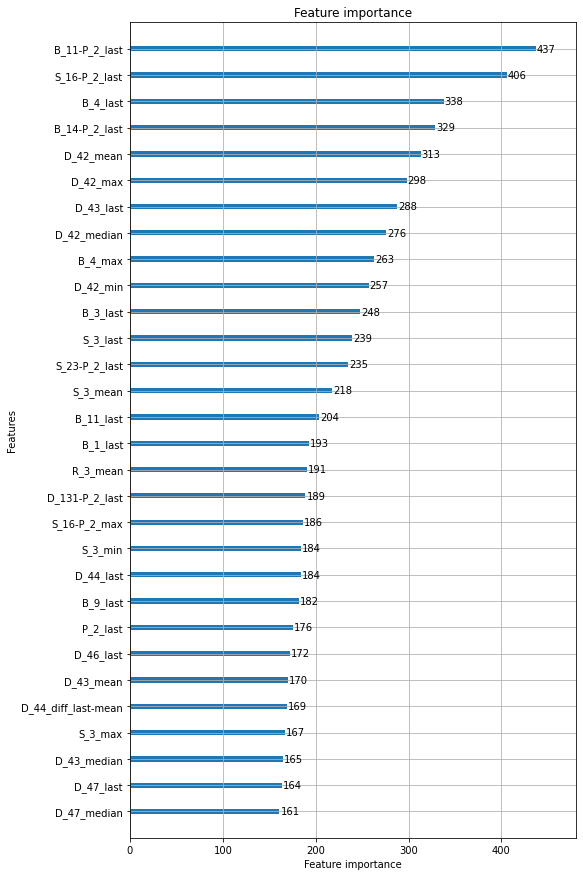

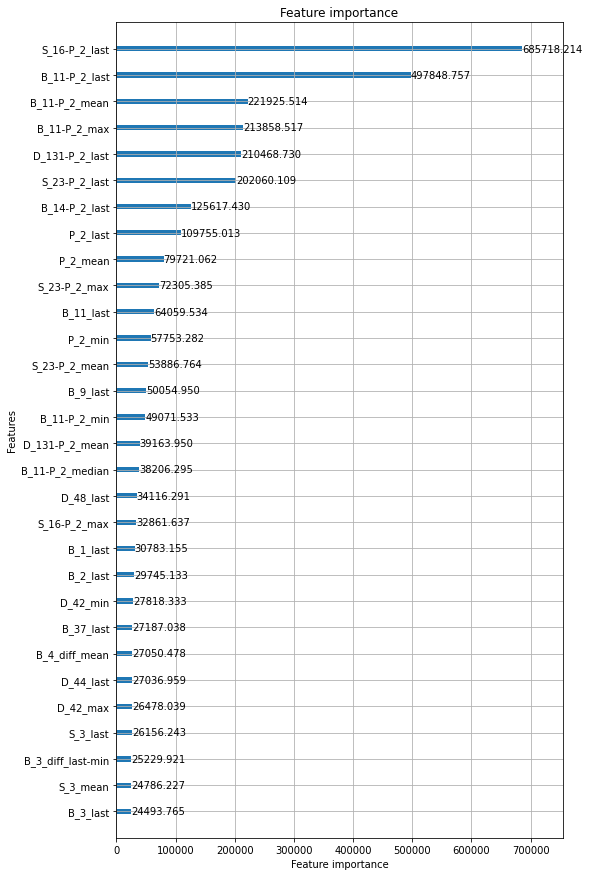

######################################## training model 4/5 ########################################
seed: 23


[50]	valid_0's amex_metric: 0.750585	valid_0's recall_at4: 0.60101	valid_0's norm_gini: 0.900159


[100]	valid_0's amex_metric: 0.762409	valid_0's recall_at4: 0.617505	valid_0's norm_gini: 0.907313


[150]	valid_0's amex_metric: 0.769571	valid_0's recall_at4: 0.627393	valid_0's norm_gini: 0.911749


[200]	valid_0's amex_metric: 0.772388	valid_0's recall_at4: 0.631096	valid_0's norm_gini: 0.91368


[250]	valid_0's amex_metric: 0.775739	valid_0's recall_at4: 0.636272	valid_0's norm_gini: 0.915206


[300]	valid_0's amex_metric: 0.779068	valid_0's recall_at4: 0.641616	valid_0's norm_gini: 0.916521


[350]	valid_0's amex_metric: 0.780676	valid_0's recall_at4: 0.643972	valid_0's norm_gini: 0.917381


[400]	valid_0's amex_metric: 0.782226	valid_0's recall_at4: 0.64616	valid_0's norm_gini: 0.918291


[450]	valid_0's amex_metric: 0.783406	valid_0's recall_at4: 0.647717	valid_0's norm_gini: 0.919095


[500]	valid_0's amex_metric: 0.784413	valid_0's recall_at4: 0.649232	valid_0's norm_gini: 0.919595


[550]	valid_0's amex_metric: 0.785478	valid_0's recall_at4: 0.650831	valid_0's norm_gini: 0.920125


[600]	valid_0's amex_metric: 0.786951	valid_0's recall_at4: 0.65323	valid_0's norm_gini: 0.920672


[650]	valid_0's amex_metric: 0.787915	valid_0's recall_at4: 0.654786	valid_0's norm_gini: 0.921044


[700]	valid_0's amex_metric: 0.787835	valid_0's recall_at4: 0.654366	valid_0's norm_gini: 0.921305


[750]	valid_0's amex_metric: 0.788409	valid_0's recall_at4: 0.655165	valid_0's norm_gini: 0.921653


[800]	valid_0's amex_metric: 0.788899	valid_0's recall_at4: 0.655881	valid_0's norm_gini: 0.921917


[850]	valid_0's amex_metric: 0.788589	valid_0's recall_at4: 0.655039	valid_0's norm_gini: 0.92214


[900]	valid_0's amex_metric: 0.789642	valid_0's recall_at4: 0.656932	valid_0's norm_gini: 0.922351


[950]	valid_0's amex_metric: 0.790388	valid_0's recall_at4: 0.658279	valid_0's norm_gini: 0.922496


[1000]	valid_0's amex_metric: 0.790808	valid_0's recall_at4: 0.65891	valid_0's norm_gini: 0.922705


[1050]	valid_0's amex_metric: 0.790971	valid_0's recall_at4: 0.659036	valid_0's norm_gini: 0.922905


[1100]	valid_0's amex_metric: 0.790943	valid_0's recall_at4: 0.658784	valid_0's norm_gini: 0.923102


[1150]	valid_0's amex_metric: 0.791525	valid_0's recall_at4: 0.659836	valid_0's norm_gini: 0.923215


[1200]	valid_0's amex_metric: 0.791833	valid_0's recall_at4: 0.660341	valid_0's norm_gini: 0.923326


[1250]	valid_0's amex_metric: 0.792048	valid_0's recall_at4: 0.660635	valid_0's norm_gini: 0.92346


[1300]	valid_0's amex_metric: 0.791791	valid_0's recall_at4: 0.660004	valid_0's norm_gini: 0.923579


[1350]	valid_0's amex_metric: 0.792143	valid_0's recall_at4: 0.660593	valid_0's norm_gini: 0.923693


[1400]	valid_0's amex_metric: 0.792784	valid_0's recall_at4: 0.661772	valid_0's norm_gini: 0.923797


[1450]	valid_0's amex_metric: 0.792812	valid_0's recall_at4: 0.661772	valid_0's norm_gini: 0.923853


[1500]	valid_0's amex_metric: 0.793204	valid_0's recall_at4: 0.662529	valid_0's norm_gini: 0.92388


[1550]	valid_0's amex_metric: 0.792803	valid_0's recall_at4: 0.661645	valid_0's norm_gini: 0.923961


[1600]	valid_0's amex_metric: 0.793052	valid_0's recall_at4: 0.662066	valid_0's norm_gini: 0.924037


[1650]	valid_0's amex_metric: 0.793141	valid_0's recall_at4: 0.662192	valid_0's norm_gini: 0.924091


[1700]	valid_0's amex_metric: 0.793316	valid_0's recall_at4: 0.662487	valid_0's norm_gini: 0.924145


[1750]	valid_0's amex_metric: 0.793095	valid_0's recall_at4: 0.662024	valid_0's norm_gini: 0.924166


[1800]	valid_0's amex_metric: 0.792586	valid_0's recall_at4: 0.660972	valid_0's norm_gini: 0.9242


[1850]	valid_0's amex_metric: 0.793128	valid_0's recall_at4: 0.662024	valid_0's norm_gini: 0.924232


[1900]	valid_0's amex_metric: 0.793402	valid_0's recall_at4: 0.662529	valid_0's norm_gini: 0.924275


[1950]	valid_0's amex_metric: 0.793719	valid_0's recall_at4: 0.663118	valid_0's norm_gini: 0.92432


[2000]	valid_0's amex_metric: 0.793476	valid_0's recall_at4: 0.662571	valid_0's norm_gini: 0.924381


[2050]	valid_0's amex_metric: 0.793451	valid_0's recall_at4: 0.662487	valid_0's norm_gini: 0.924415


[2100]	valid_0's amex_metric: 0.793074	valid_0's recall_at4: 0.661687	valid_0's norm_gini: 0.924462


[2150]	valid_0's amex_metric: 0.793068	valid_0's recall_at4: 0.661645	valid_0's norm_gini: 0.924491


[2200]	valid_0's amex_metric: 0.792681	valid_0's recall_at4: 0.660846	valid_0's norm_gini: 0.924517


[2250]	valid_0's amex_metric: 0.793088	valid_0's recall_at4: 0.661645	valid_0's norm_gini: 0.92453


[2300]	valid_0's amex_metric: 0.793153	valid_0's recall_at4: 0.661729	valid_0's norm_gini: 0.924577


[2350]	valid_0's amex_metric: 0.793252	valid_0's recall_at4: 0.661898	valid_0's norm_gini: 0.924606


[2400]	valid_0's amex_metric: 0.793475	valid_0's recall_at4: 0.662319	valid_0's norm_gini: 0.924632


[2450]	valid_0's amex_metric: 0.793144	valid_0's recall_at4: 0.661645	valid_0's norm_gini: 0.924642


[2500]	valid_0's amex_metric: 0.793109	valid_0's recall_at4: 0.661561	valid_0's norm_gini: 0.924656


[2550]	valid_0's amex_metric: 0.793525	valid_0's recall_at4: 0.662361	valid_0's norm_gini: 0.924689


[2600]	valid_0's amex_metric: 0.793489	valid_0's recall_at4: 0.662276	valid_0's norm_gini: 0.924701


[2650]	valid_0's amex_metric: 0.793812	valid_0's recall_at4: 0.662908	valid_0's norm_gini: 0.924716


[2700]	valid_0's amex_metric: 0.793501	valid_0's recall_at4: 0.662276	valid_0's norm_gini: 0.924725


[2750]	valid_0's amex_metric: 0.793526	valid_0's recall_at4: 0.662319	valid_0's norm_gini: 0.924734


[2800]	valid_0's amex_metric: 0.793662	valid_0's recall_at4: 0.662571	valid_0's norm_gini: 0.924753


[2850]	valid_0's amex_metric: 0.793446	valid_0's recall_at4: 0.662108	valid_0's norm_gini: 0.924785


[2900]	valid_0's amex_metric: 0.793875	valid_0's recall_at4: 0.66295	valid_0's norm_gini: 0.924801


[2950]	valid_0's amex_metric: 0.79371	valid_0's recall_at4: 0.662613	valid_0's norm_gini: 0.924807


[3000]	valid_0's amex_metric: 0.793425	valid_0's recall_at4: 0.662024	valid_0's norm_gini: 0.924826


[3050]	valid_0's amex_metric: 0.793722	valid_0's recall_at4: 0.662571	valid_0's norm_gini: 0.924873


[3100]	valid_0's amex_metric: 0.794463	valid_0's recall_at4: 0.664044	valid_0's norm_gini: 0.924883


[3150]	valid_0's amex_metric: 0.794603	valid_0's recall_at4: 0.664338	valid_0's norm_gini: 0.924867


[3200]	valid_0's amex_metric: 0.794514	valid_0's recall_at4: 0.664128	valid_0's norm_gini: 0.924901


[3250]	valid_0's amex_metric: 0.794893	valid_0's recall_at4: 0.664885	valid_0's norm_gini: 0.9249


[3300]	valid_0's amex_metric: 0.794653	valid_0's recall_at4: 0.66438	valid_0's norm_gini: 0.924926


[3350]	valid_0's amex_metric: 0.794414	valid_0's recall_at4: 0.663875	valid_0's norm_gini: 0.924954


[3400]	valid_0's amex_metric: 0.794582	valid_0's recall_at4: 0.664212	valid_0's norm_gini: 0.924951


[3450]	valid_0's amex_metric: 0.794664	valid_0's recall_at4: 0.66438	valid_0's norm_gini: 0.924949


[3500]	valid_0's amex_metric: 0.794641	valid_0's recall_at4: 0.664338	valid_0's norm_gini: 0.924944


[3550]	valid_0's amex_metric: 0.794978	valid_0's recall_at4: 0.665012	valid_0's norm_gini: 0.924945


[3600]	valid_0's amex_metric: 0.7948	valid_0's recall_at4: 0.664633	valid_0's norm_gini: 0.924968


[3650]	valid_0's amex_metric: 0.794823	valid_0's recall_at4: 0.664675	valid_0's norm_gini: 0.924971


[3700]	valid_0's amex_metric: 0.794565	valid_0's recall_at4: 0.66417	valid_0's norm_gini: 0.924959


[3750]	valid_0's amex_metric: 0.794272	valid_0's recall_at4: 0.663581	valid_0's norm_gini: 0.924963


[3800]	valid_0's amex_metric: 0.794373	valid_0's recall_at4: 0.663791	valid_0's norm_gini: 0.924954


[3850]	valid_0's amex_metric: 0.794546	valid_0's recall_at4: 0.664128	valid_0's norm_gini: 0.924965


[3900]	valid_0's amex_metric: 0.794971	valid_0's recall_at4: 0.66497	valid_0's norm_gini: 0.924972


[3950]	valid_0's amex_metric: 0.794537	valid_0's recall_at4: 0.664086	valid_0's norm_gini: 0.924989


[4000]	valid_0's amex_metric: 0.794496	valid_0's recall_at4: 0.664002	valid_0's norm_gini: 0.924991


[4050]	valid_0's amex_metric: 0.794556	valid_0's recall_at4: 0.664128	valid_0's norm_gini: 0.924984


[4100]	valid_0's amex_metric: 0.794305	valid_0's recall_at4: 0.663623	valid_0's norm_gini: 0.924986


[4150]	valid_0's amex_metric: 0.793904	valid_0's recall_at4: 0.662823	valid_0's norm_gini: 0.924985


[4200]	valid_0's amex_metric: 0.794679	valid_0's recall_at4: 0.66438	valid_0's norm_gini: 0.924978


[4250]	valid_0's amex_metric: 0.79483	valid_0's recall_at4: 0.664675	valid_0's norm_gini: 0.924986


[4300]	valid_0's amex_metric: 0.795105	valid_0's recall_at4: 0.665222	valid_0's norm_gini: 0.924988


[4350]	valid_0's amex_metric: 0.794712	valid_0's recall_at4: 0.664422	valid_0's norm_gini: 0.925002


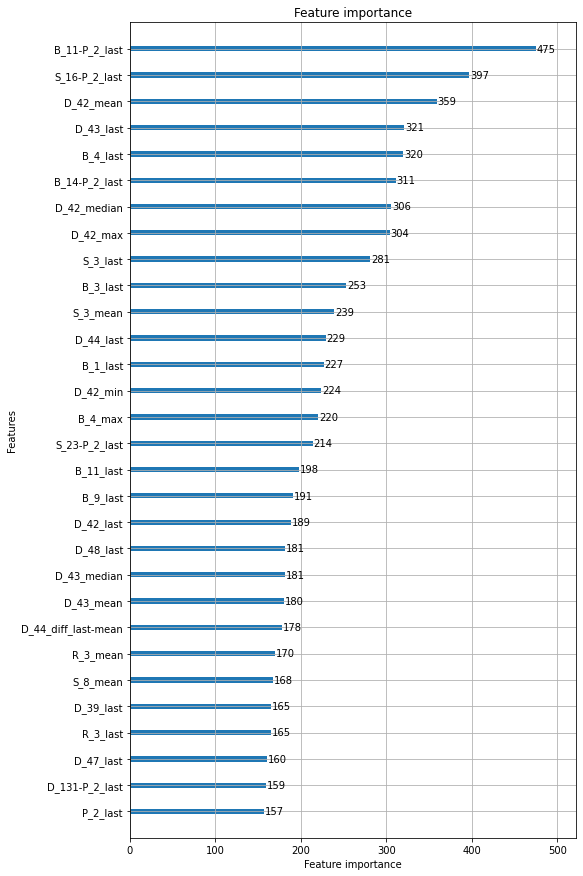

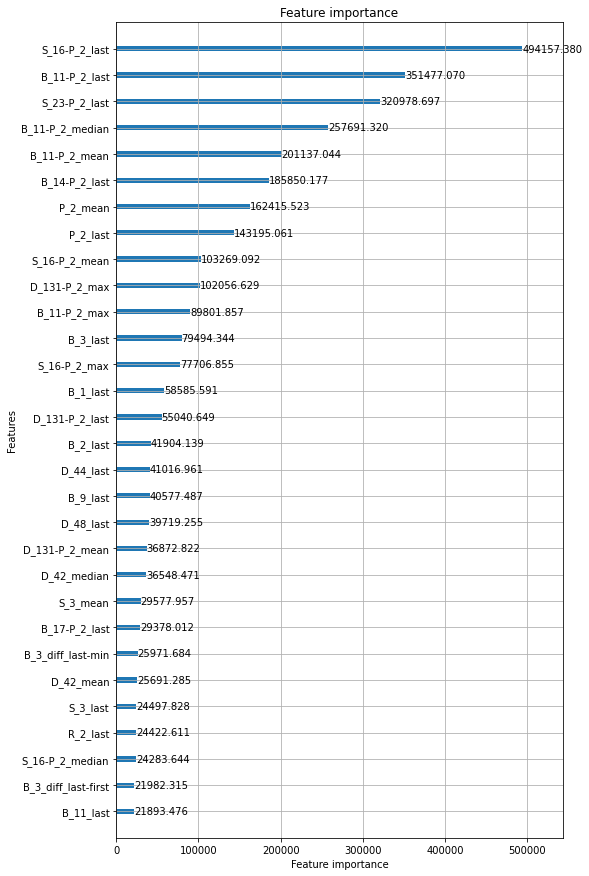

######################################## training model 5/5 ########################################
seed: 24


[50]	valid_0's amex_metric: 0.74732	valid_0's recall_at4: 0.596844	valid_0's norm_gini: 0.897795


[100]	valid_0's amex_metric: 0.757068	valid_0's recall_at4: 0.610267	valid_0's norm_gini: 0.903869


[150]	valid_0's amex_metric: 0.765133	valid_0's recall_at4: 0.622133	valid_0's norm_gini: 0.908132


[200]	valid_0's amex_metric: 0.770407	valid_0's recall_at4: 0.628824	valid_0's norm_gini: 0.911991


[250]	valid_0's amex_metric: 0.773958	valid_0's recall_at4: 0.633873	valid_0's norm_gini: 0.914043


[300]	valid_0's amex_metric: 0.776417	valid_0's recall_at4: 0.637282	valid_0's norm_gini: 0.915553


[350]	valid_0's amex_metric: 0.779757	valid_0's recall_at4: 0.642584	valid_0's norm_gini: 0.91693


[400]	valid_0's amex_metric: 0.781184	valid_0's recall_at4: 0.644519	valid_0's norm_gini: 0.917849


[450]	valid_0's amex_metric: 0.781936	valid_0's recall_at4: 0.645277	valid_0's norm_gini: 0.918596


[500]	valid_0's amex_metric: 0.783002	valid_0's recall_at4: 0.64696	valid_0's norm_gini: 0.919044


[550]	valid_0's amex_metric: 0.784088	valid_0's recall_at4: 0.648643	valid_0's norm_gini: 0.919533


[600]	valid_0's amex_metric: 0.78525	valid_0's recall_at4: 0.650452	valid_0's norm_gini: 0.920047


[650]	valid_0's amex_metric: 0.786199	valid_0's recall_at4: 0.652009	valid_0's norm_gini: 0.920389


[700]	valid_0's amex_metric: 0.786051	valid_0's recall_at4: 0.651504	valid_0's norm_gini: 0.920597


[750]	valid_0's amex_metric: 0.786972	valid_0's recall_at4: 0.653061	valid_0's norm_gini: 0.920882


[800]	valid_0's amex_metric: 0.787199	valid_0's recall_at4: 0.65323	valid_0's norm_gini: 0.921168


[850]	valid_0's amex_metric: 0.788138	valid_0's recall_at4: 0.654913	valid_0's norm_gini: 0.921363


[900]	valid_0's amex_metric: 0.788511	valid_0's recall_at4: 0.655418	valid_0's norm_gini: 0.921604


[950]	valid_0's amex_metric: 0.78842	valid_0's recall_at4: 0.654997	valid_0's norm_gini: 0.921844


[1000]	valid_0's amex_metric: 0.788626	valid_0's recall_at4: 0.655249	valid_0's norm_gini: 0.922003


[1050]	valid_0's amex_metric: 0.788798	valid_0's recall_at4: 0.65546	valid_0's norm_gini: 0.922137


[1100]	valid_0's amex_metric: 0.788788	valid_0's recall_at4: 0.655333	valid_0's norm_gini: 0.922243


[1150]	valid_0's amex_metric: 0.789683	valid_0's recall_at4: 0.656975	valid_0's norm_gini: 0.922391


[1200]	valid_0's amex_metric: 0.78971	valid_0's recall_at4: 0.65689	valid_0's norm_gini: 0.922529


[1250]	valid_0's amex_metric: 0.789625	valid_0's recall_at4: 0.656596	valid_0's norm_gini: 0.922654


[1300]	valid_0's amex_metric: 0.790194	valid_0's recall_at4: 0.657606	valid_0's norm_gini: 0.922782


[1350]	valid_0's amex_metric: 0.790401	valid_0's recall_at4: 0.6579	valid_0's norm_gini: 0.922902


[1400]	valid_0's amex_metric: 0.790541	valid_0's recall_at4: 0.658069	valid_0's norm_gini: 0.923013


[1450]	valid_0's amex_metric: 0.790915	valid_0's recall_at4: 0.658658	valid_0's norm_gini: 0.923172


[1500]	valid_0's amex_metric: 0.791154	valid_0's recall_at4: 0.659078	valid_0's norm_gini: 0.923229


[1550]	valid_0's amex_metric: 0.791028	valid_0's recall_at4: 0.658742	valid_0's norm_gini: 0.923314


[1600]	valid_0's amex_metric: 0.790898	valid_0's recall_at4: 0.658405	valid_0's norm_gini: 0.923392


[1650]	valid_0's amex_metric: 0.791013	valid_0's recall_at4: 0.658574	valid_0's norm_gini: 0.923453


[1700]	valid_0's amex_metric: 0.791193	valid_0's recall_at4: 0.658868	valid_0's norm_gini: 0.923517


[1750]	valid_0's amex_metric: 0.791229	valid_0's recall_at4: 0.65891	valid_0's norm_gini: 0.923548


[1800]	valid_0's amex_metric: 0.791623	valid_0's recall_at4: 0.659625	valid_0's norm_gini: 0.92362


[1850]	valid_0's amex_metric: 0.791297	valid_0's recall_at4: 0.65891	valid_0's norm_gini: 0.923684


[1900]	valid_0's amex_metric: 0.791401	valid_0's recall_at4: 0.659078	valid_0's norm_gini: 0.923723


[1950]	valid_0's amex_metric: 0.791439	valid_0's recall_at4: 0.659121	valid_0's norm_gini: 0.923756


[2000]	valid_0's amex_metric: 0.79172	valid_0's recall_at4: 0.659668	valid_0's norm_gini: 0.923772


[2050]	valid_0's amex_metric: 0.791948	valid_0's recall_at4: 0.660088	valid_0's norm_gini: 0.923808


[2100]	valid_0's amex_metric: 0.791853	valid_0's recall_at4: 0.659878	valid_0's norm_gini: 0.923828


[2150]	valid_0's amex_metric: 0.792742	valid_0's recall_at4: 0.661645	valid_0's norm_gini: 0.923839


[2200]	valid_0's amex_metric: 0.792662	valid_0's recall_at4: 0.661435	valid_0's norm_gini: 0.92389


[2250]	valid_0's amex_metric: 0.792342	valid_0's recall_at4: 0.660762	valid_0's norm_gini: 0.923922


[2300]	valid_0's amex_metric: 0.792374	valid_0's recall_at4: 0.660804	valid_0's norm_gini: 0.923944


[2350]	valid_0's amex_metric: 0.792552	valid_0's recall_at4: 0.66114	valid_0's norm_gini: 0.923963


[2400]	valid_0's amex_metric: 0.79247	valid_0's recall_at4: 0.660972	valid_0's norm_gini: 0.923968


[2450]	valid_0's amex_metric: 0.792588	valid_0's recall_at4: 0.661182	valid_0's norm_gini: 0.923994


[2500]	valid_0's amex_metric: 0.792447	valid_0's recall_at4: 0.660888	valid_0's norm_gini: 0.924007


[2550]	valid_0's amex_metric: 0.792967	valid_0's recall_at4: 0.661898	valid_0's norm_gini: 0.924036


[2600]	valid_0's amex_metric: 0.792766	valid_0's recall_at4: 0.661477	valid_0's norm_gini: 0.924054


[2650]	valid_0's amex_metric: 0.792648	valid_0's recall_at4: 0.661224	valid_0's norm_gini: 0.924071


[2700]	valid_0's amex_metric: 0.793102	valid_0's recall_at4: 0.662108	valid_0's norm_gini: 0.924096


[2750]	valid_0's amex_metric: 0.793717	valid_0's recall_at4: 0.663328	valid_0's norm_gini: 0.924105


[2800]	valid_0's amex_metric: 0.793784	valid_0's recall_at4: 0.663455	valid_0's norm_gini: 0.924114


[2850]	valid_0's amex_metric: 0.793705	valid_0's recall_at4: 0.663286	valid_0's norm_gini: 0.924124


[2900]	valid_0's amex_metric: 0.793331	valid_0's recall_at4: 0.662529	valid_0's norm_gini: 0.924134


[2950]	valid_0's amex_metric: 0.793547	valid_0's recall_at4: 0.66295	valid_0's norm_gini: 0.924144


[3000]	valid_0's amex_metric: 0.793539	valid_0's recall_at4: 0.662908	valid_0's norm_gini: 0.92417


[3050]	valid_0's amex_metric: 0.793333	valid_0's recall_at4: 0.662487	valid_0's norm_gini: 0.92418


[3100]	valid_0's amex_metric: 0.793129	valid_0's recall_at4: 0.662066	valid_0's norm_gini: 0.924191


[3150]	valid_0's amex_metric: 0.793544	valid_0's recall_at4: 0.662908	valid_0's norm_gini: 0.92418


[3200]	valid_0's amex_metric: 0.793766	valid_0's recall_at4: 0.663328	valid_0's norm_gini: 0.924203


[3250]	valid_0's amex_metric: 0.793835	valid_0's recall_at4: 0.663455	valid_0's norm_gini: 0.924216


[3300]	valid_0's amex_metric: 0.793569	valid_0's recall_at4: 0.662908	valid_0's norm_gini: 0.92423


[3350]	valid_0's amex_metric: 0.79316	valid_0's recall_at4: 0.662108	valid_0's norm_gini: 0.924213


[3400]	valid_0's amex_metric: 0.793041	valid_0's recall_at4: 0.661856	valid_0's norm_gini: 0.924226


[3450]	valid_0's amex_metric: 0.793076	valid_0's recall_at4: 0.661898	valid_0's norm_gini: 0.924254


[3500]	valid_0's amex_metric: 0.793482	valid_0's recall_at4: 0.662697	valid_0's norm_gini: 0.924267


[3550]	valid_0's amex_metric: 0.792934	valid_0's recall_at4: 0.661603	valid_0's norm_gini: 0.924264


[3600]	valid_0's amex_metric: 0.793052	valid_0's recall_at4: 0.661856	valid_0's norm_gini: 0.924249


[3650]	valid_0's amex_metric: 0.792953	valid_0's recall_at4: 0.661645	valid_0's norm_gini: 0.92426


[3700]	valid_0's amex_metric: 0.793172	valid_0's recall_at4: 0.662066	valid_0's norm_gini: 0.924279


[3750]	valid_0's amex_metric: 0.793148	valid_0's recall_at4: 0.662024	valid_0's norm_gini: 0.924273


[3800]	valid_0's amex_metric: 0.792952	valid_0's recall_at4: 0.661645	valid_0's norm_gini: 0.924258


[3850]	valid_0's amex_metric: 0.793533	valid_0's recall_at4: 0.662781	valid_0's norm_gini: 0.924284


[3900]	valid_0's amex_metric: 0.79339	valid_0's recall_at4: 0.662487	valid_0's norm_gini: 0.924293


[3950]	valid_0's amex_metric: 0.793441	valid_0's recall_at4: 0.662571	valid_0's norm_gini: 0.924311


[4000]	valid_0's amex_metric: 0.792979	valid_0's recall_at4: 0.661645	valid_0's norm_gini: 0.924312


[4050]	valid_0's amex_metric: 0.792967	valid_0's recall_at4: 0.661603	valid_0's norm_gini: 0.924331


[4100]	valid_0's amex_metric: 0.793335	valid_0's recall_at4: 0.662319	valid_0's norm_gini: 0.924351


[4150]	valid_0's amex_metric: 0.793582	valid_0's recall_at4: 0.662823	valid_0's norm_gini: 0.92434


[4200]	valid_0's amex_metric: 0.793346	valid_0's recall_at4: 0.662361	valid_0's norm_gini: 0.924332


[4250]	valid_0's amex_metric: 0.793546	valid_0's recall_at4: 0.662739	valid_0's norm_gini: 0.924353


[4300]	valid_0's amex_metric: 0.793439	valid_0's recall_at4: 0.662529	valid_0's norm_gini: 0.924349


[4350]	valid_0's amex_metric: 0.793202	valid_0's recall_at4: 0.662066	valid_0's norm_gini: 0.924337


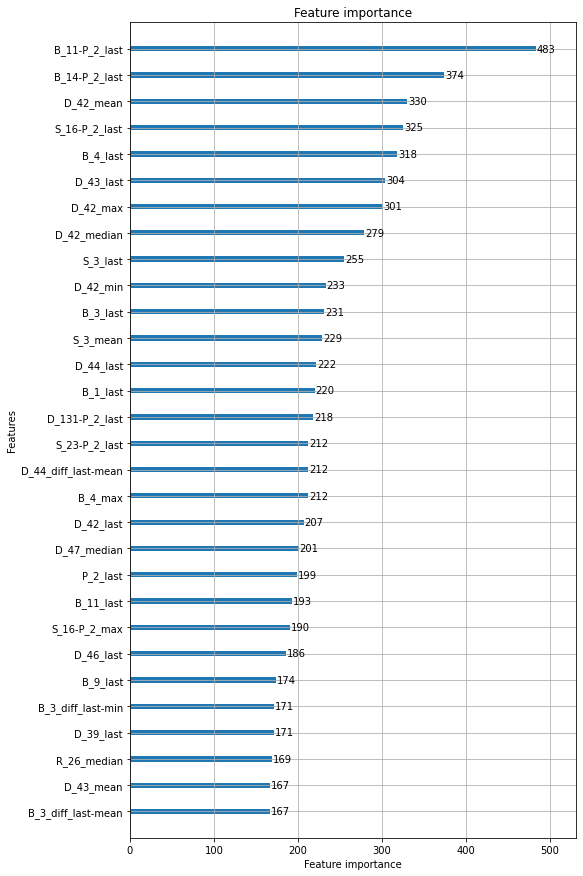

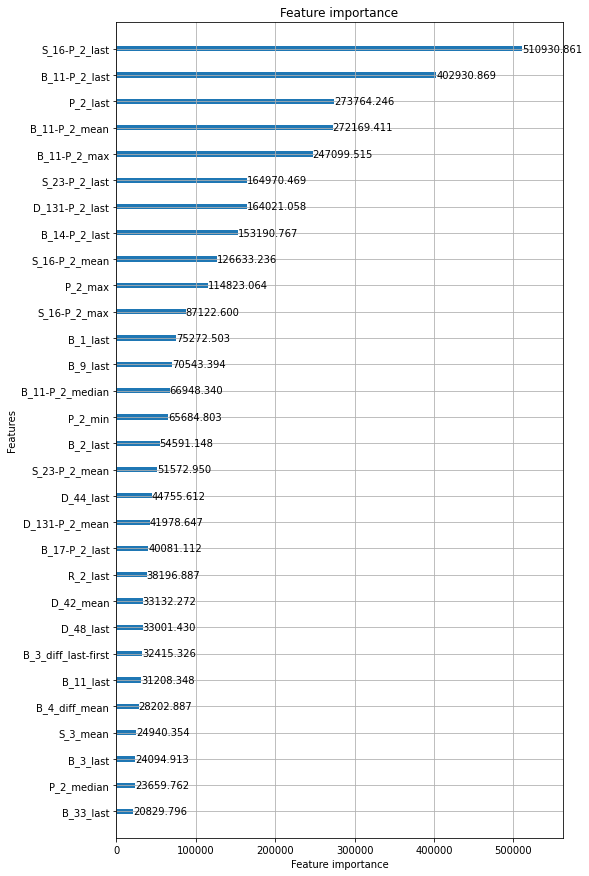

Training time: 34.258731436729434 min.
OOF recall_at4: 0.667149156764399
OOF normalized_gini: 0.925337408765332
OOF competition metric: 0.7962432827648656


CPU times: user 2d 14h 38min 32s, sys: 3min 5s, total: 2d 14h 41min 38s
Wall time: 2h 51min 41s


In [11]:
%%time 

all_models = list()
all_oof_dfs = list()

for repetition in range(N_REPEATS):
    print(f" repeated cross-validation step: {repetition+1}/{N_REPEATS} ".center(100, "#"))

    folds = pd.read_csv(f'../data/processed/cv{repetition}.csv', index_col="customer_ID")
    _train = pd.merge(train, folds, how="inner", left_index=True, right_index=True).reset_index(drop=True)
    
    tic = time.time()
    models,oof = train_models(_train)
    tac = time.time()
    print(f"Training time: {(tac-tic)/60} min.")
          
    # oof metrics
    print("OOF recall_at4:", compute_recall_at4(oof.target.values, oof.pred.values))
    print("OOF normalized_gini:", compute_normalized_gini(oof.target.values, oof.pred.values))
    print("OOF competition metric:", compute_amex_metric(oof.target.values, oof.pred.values))
    
    all_models.append(models)
    all_oof_dfs.append(oof)
    
    # save oof predictions
    oof.to_csv(OOF_PATH/f"oof-cv{repetition}.csv", index=False)
    # save models
    for fold,_model in enumerate(models):
        _model.save_model(ART_PATH/f"/model-cv{repetition}-fold{fold}.txt")
          
    del _train, folds; gc.collect()

In [12]:
results = list()

for oof in all_oof_dfs:  
    r = {
        "recall_at4": compute_recall_at4(oof.target.values, oof.pred.values),
        "gini": compute_normalized_gini(oof.target.values, oof.pred.values),
        "metric": compute_amex_metric(oof.target.values, oof.pred.values),
    }
    results.append(r)

results = pd.DataFrame(results)
display(results)

print("\nmean:")
display(results.mean(axis=0))

print("\nstd:")
display(results.std(axis=0))

recall_at4      gini    metric
0    0.667604  0.925303  0.796453
1    0.668462  0.925345  0.796904
2    0.667158  0.925389  0.796273
3    0.667326  0.925315  0.796321
4    0.667149  0.925337  0.796243


mean:


recall_at4    0.667540
gini          0.925338
metric        0.796439
dtype: float64


std:


recall_at4    0.000547
gini          0.000033
metric        0.000272
dtype: float64

In [13]:
del train
gc.collect()

21

***
## make predictions and submit

In [14]:
def make_predictions(dataframe:pd.DataFrame, input_feats:list, models:list) -> np.array:
    preds = [model.predict(dataframe[input_feats]) for model in models]
    return np.mean(preds, axis=0)    

In [15]:
test = pd.read_parquet(f"../data/processed/dsv{DATASET_VERSION}/test.parquet")
sub = pd.read_csv("../data/raw/sample_submission.csv")

In [16]:
%%time

all_preds = list()

for repetition in range(N_REPEATS):
    if "prediction" in sub.columns:
        sub.drop("prediction", axis=1, inplace=True)
    if "prediction" in test.columns:
        test.drop("prediction", axis=1, inplace=True)
        
    models = all_models[repetition]
    preds = make_predictions(test, input_feats, models)
    all_preds.append(preds)
       
    test["prediction"] = preds
    sub["prediction"] = test.loc[sub.customer_ID.values,"prediction"].values
    assert sub.prediction.isna().sum() == 0
    sub.to_csv(SUB_PATH/f"submission-cv{repetition}.csv", index=False)

CPU times: user 3h 29min 35s, sys: 1min 12s, total: 3h 30min 47s
Wall time: 9min 43s


In [17]:
%%time
# predict using all the trained models
if "prediction" in sub.columns:
    sub.drop("prediction", axis=1, inplace=True)
if "prediction" in test.columns:
    test.drop("prediction", axis=1, inplace=True)

test["prediction"] = np.mean(all_preds, axis=0)
sub["prediction"] = test.loc[sub.customer_ID.values,"prediction"].values
assert sub.prediction.isna().sum() == 0
sub.to_csv(SUB_PATH/f"submission-all.csv", index=False)

CPU times: user 3.45 s, sys: 714 ms, total: 4.17 s
Wall time: 4.47 s


***